In [114]:
from typing import Dict, List, Tuple, Union
from skimage import exposure, img_as_ubyte
import rasterio
import pathlib
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [115]:
def load_landsat_image(
    img_folder: Union[str, None],
    bands: Union[List[str], None]
) -> Dict:
    """
    Take a folder path and return a dict with the raw vectors extracted from the Earth Engine.
    """
    # Dictionary to save the image.
    images_dict = {}

    if img_folder:
        # Use the provided path.
        path = pathlib.Path(img_folder)
    else:
        # Get the path to retrieve.
        path = pathlib.Path(__file__).parent

    # Get the list of all files.
    files = [f.name for f in path.glob('**/*.tif')]
    # Parse all of filenames to get the unique ones.
    files = set([re.search('_[0-9](.*)[0-9]_', x).group() for x in files])
    # Dict of images to return.
    images_dict = {}

    # Iterate over the files.
    for pat in files:
        image = {}
        # Iterate over the bands.
        for band in bands:
            file = next(path.glob(f'*{pat}{band}.tif'))
            print(f'Opening file {file}')
            ds = rasterio.open(file)
            image.update({band: ds.read(1)})
        # Update the main dict.
        images_dict.update(
            {pat.replace('_','') : image}
        )

    return images_dict

def display_rgb(
    img: Union[Dict, None], 
    alpha=1., 
    figsize=(10, 10)
    ) -> None:
    rgb = np.stack(
        [img['B4'], img['B3'], img['B2']],
        axis=-1
    )
    rgb = rgb/rgb.max() * alpha
    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    
def convert_to_eight_bits(
    img: Union[Dict, None]
) -> np.array:
    """
    To reescale image to 8 bits.
    """
    img_stack = np.stack(
        [img['B4'], img['B3'], img['B2']]
        , axis=-1)

    scaled_img = img_as_ubyte(
        exposure.rescale_intensity(img_stack)
    )
    
    return scaled_img

In [116]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/'
band_labels = ["B4", "B3", "B2"]
images = load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())

Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/S-HARMONIZED_20200515T172859_20200515T173444_T14UNV_15May2020_B4.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/S-HARMONIZED_20200515T172859_20200515T173444_T14UNV_15May2020_B3.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/S-HARMONIZED_20200515T172859_20200515T173444_T14UNV_15May2020_B2.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/S-HARMONIZED_20200714T172859_20200714T172950_T14UNV_14Jul2020_B4.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/S-HARMONIZED_20200714T172859_20200714T172950_T14UNV_14Jul2020_B3.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/S-HARMONIZED_20200714T172859_20200714T172950_T14UNV_14Jul2020_B2.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatia

In [117]:
#Edge detection

def edge_detection_preprocessing(image_data, canny_parameter1=100, canny_parameter2=100, band="all"):

    if band == "all":

        image = convert_to_eight_bits(image_data)

        hsv_filter = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        grayscale_filter = cv2.cvtColor(cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2HSV_FULL), cv2.COLOR_RGB2GRAY)
        gaussian_filter = cv2.GaussianBlur(hsv_filter, (1,1), 0)
        grayscale_gaussian_filter = cv2.GaussianBlur(grayscale_filter, (1,1), 0)

        grayscale_canny = cv2.Canny(grayscale_filter, canny_parameter1, canny_parameter2)
        gaussian_canny = cv2.Canny(gaussian_filter, canny_parameter1, canny_parameter2)
        grayscale_gaussian_canny = cv2.Canny(grayscale_gaussian_filter, canny_parameter1, canny_parameter2)

        return image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny
    
    elif band == "R":

        image = image_data["B4"]
        image = image.astype(np.uint8)
        gaussian_filter = cv2.GaussianBlur(image, (5,5), 0)
        gaussian_canny = cv2.Canny(gaussian_filter, canny_parameter1, canny_parameter2)

        return image, gaussian_filter, gaussian_canny

    elif band == "G":

        image = image_data["B3"]
        image = image.astype(np.uint8)
        gaussian_filter = cv2.GaussianBlur(image, (5,5), 0)
        gaussian_canny = cv2.Canny(gaussian_filter, canny_parameter1, canny_parameter2)

        return image, gaussian_filter, gaussian_canny


    elif band == "B":

        image = image_data["B2"]
        image = image.astype(np.uint8)
        gaussian_filter = cv2.GaussianBlur(image, (5,5), 0)
        gaussian_canny = cv2.Canny(gaussian_filter, canny_parameter1, canny_parameter2)

        return image, gaussian_filter, gaussian_canny


    else:

        print("Not a valid color band")

def visualize_edge_detection(image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny):
    fig, axes = plt.subplots(4, 2, figsize=(7, 10))

    fig.subplots_adjust()
    fig.tight_layout()
    axes = axes.ravel()

    axes[0].imshow(image)
    axes[0].set_title('Original Image'), axes[0].set_xticks([]), axes[0].set_yticks([])
    axes[1].imshow(hsv_filter)
    axes[1].set_title('HSV Filter'), axes[1].set_xticks([]), axes[1].set_yticks([])
    axes[2].imshow(gaussian_filter)
    axes[2].set_title("Gaussian Filter"), axes[2].set_xticks([]), axes[2].set_yticks([])
    axes[3].imshow(gaussian_canny)
    axes[3].set_title("Canny (Gaussian)"), axes[3].set_xticks([]), axes[3].set_yticks([])
    axes[4].imshow(grayscale_filter, cmap = "gray")
    axes[4].set_title("Grayscale"), axes[4].set_xticks([]), axes[4].set_yticks([])
    axes[5].imshow(grayscale_canny, cmap = "gray")
    axes[5].set_title("Canny (Grayscale)"), axes[5].set_xticks([]), axes[5].set_yticks([])
    axes[6].imshow(grayscale_gaussian_filter, cmap = "gray")
    axes[6].set_title("Gaussian + Grayscale"), axes[6].set_xticks([]), axes[6].set_yticks([])
    axes[7].imshow(grayscale_gaussian_canny, cmap = "gray")
    axes[7].set_title("Canny (Gaussian + Grayscale)"), axes[7].set_xticks([]), axes[7].set_yticks([])
    plt.show()

def visualize_filter_edges(filters, edges, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
    fig.suptitle(title)
    fig.subplots_adjust()
    axes = axes.ravel()


    axes[0].imshow(filters)
    axes[0].set_title('Original Filter'), axes[0].set_xticks([]), axes[0].set_yticks([])
    axes[1].imshow(edges)
    axes[1].set_title('Edges'), axes[1].set_xticks([]), axes[1].set_yticks([])

    plt.show()

def draw_grid(image_data, shape=(3,3), thickness=1, color=(255,255,255)):

    h, w, _ = image_data.shape
    rows, cols = shape
    dy, dx = h / rows, w / cols

    #vertical
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv2.line(image_data, (x, 0), (x, h), color=color, thickness=thickness)

    #horizontal
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv2.line(image_data, (0, y), (w, y), color=color, thickness=thickness)

    return image_data

def split_image(image_data, grid_shape=(3,3)):

    drawing = image_data.copy()
    h, w, _ = image_data.shape
    rows, cols = grid_shape
    quadrant = ''
    quadrants_dict = {}

    dy, dx = round(h/rows), round(w/cols)

    for y in range(0, h, dy):
        for x in range(0, w, dx):
            y1 = y + dy
            x1 = x + dx

            tiles = image_data[y:y+dy, x:x+dx]
            quadrant = str(x) + "X" + "_" + str(y) + "Y" + "_" + "quadrant"
            quadrants_dict[quadrant] = tiles
            cv2.rectangle(drawing, (x,y), (x1,y1), (255, 255, 255))

            plt.imshow(drawing)

    return quadrants_dict

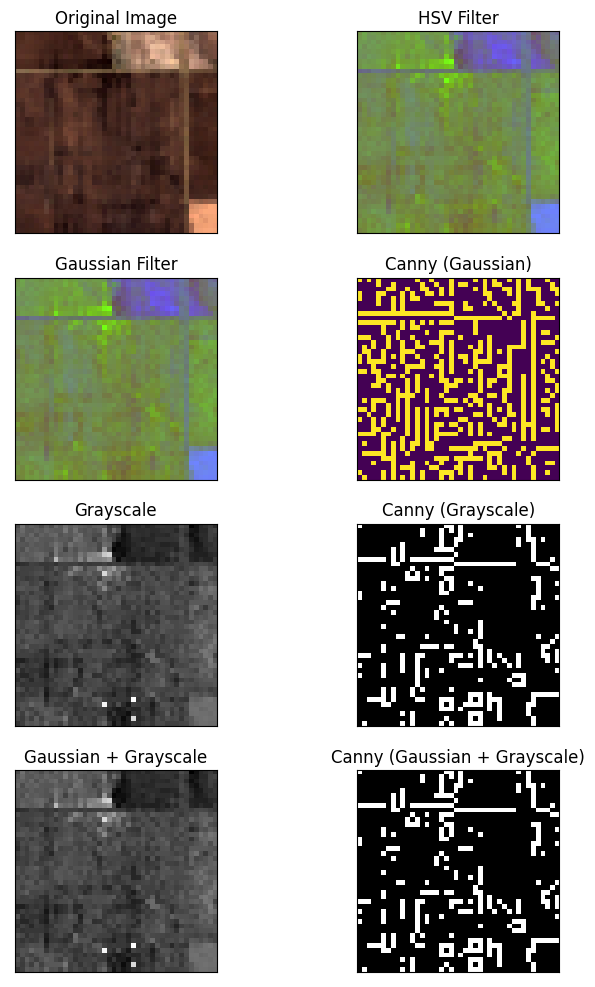

In [118]:
image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny = edge_detection_preprocessing(images[img_keys[0]], 50, 50)

visualize_edge_detection(image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny)

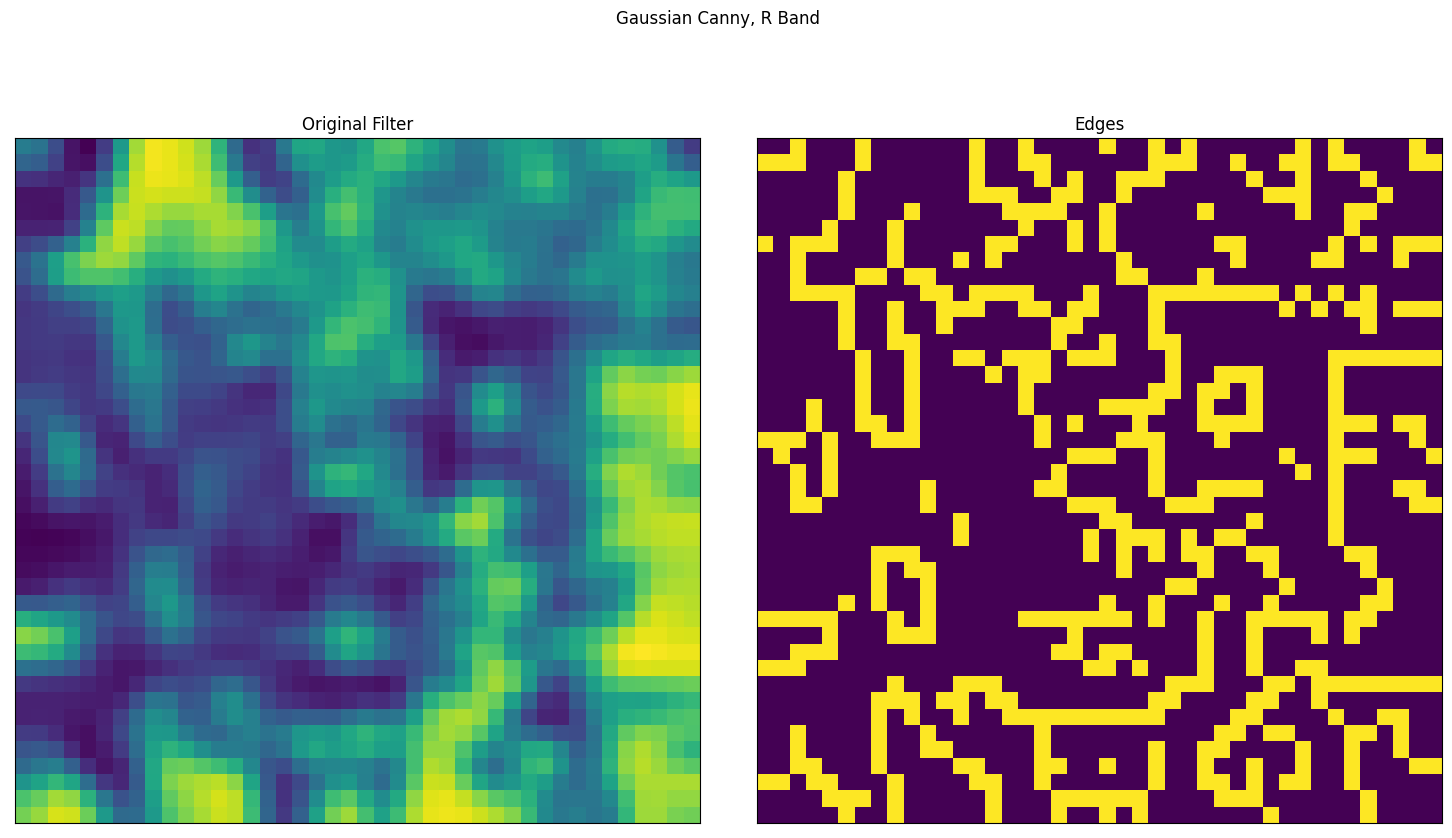

In [119]:
image, gaussian_filter, gaussian_canny = edge_detection_preprocessing(images[img_keys[0]], 150, 150, "B")
visualize_filter_edges(gaussian_filter, gaussian_canny, "Gaussian Canny, R Band")

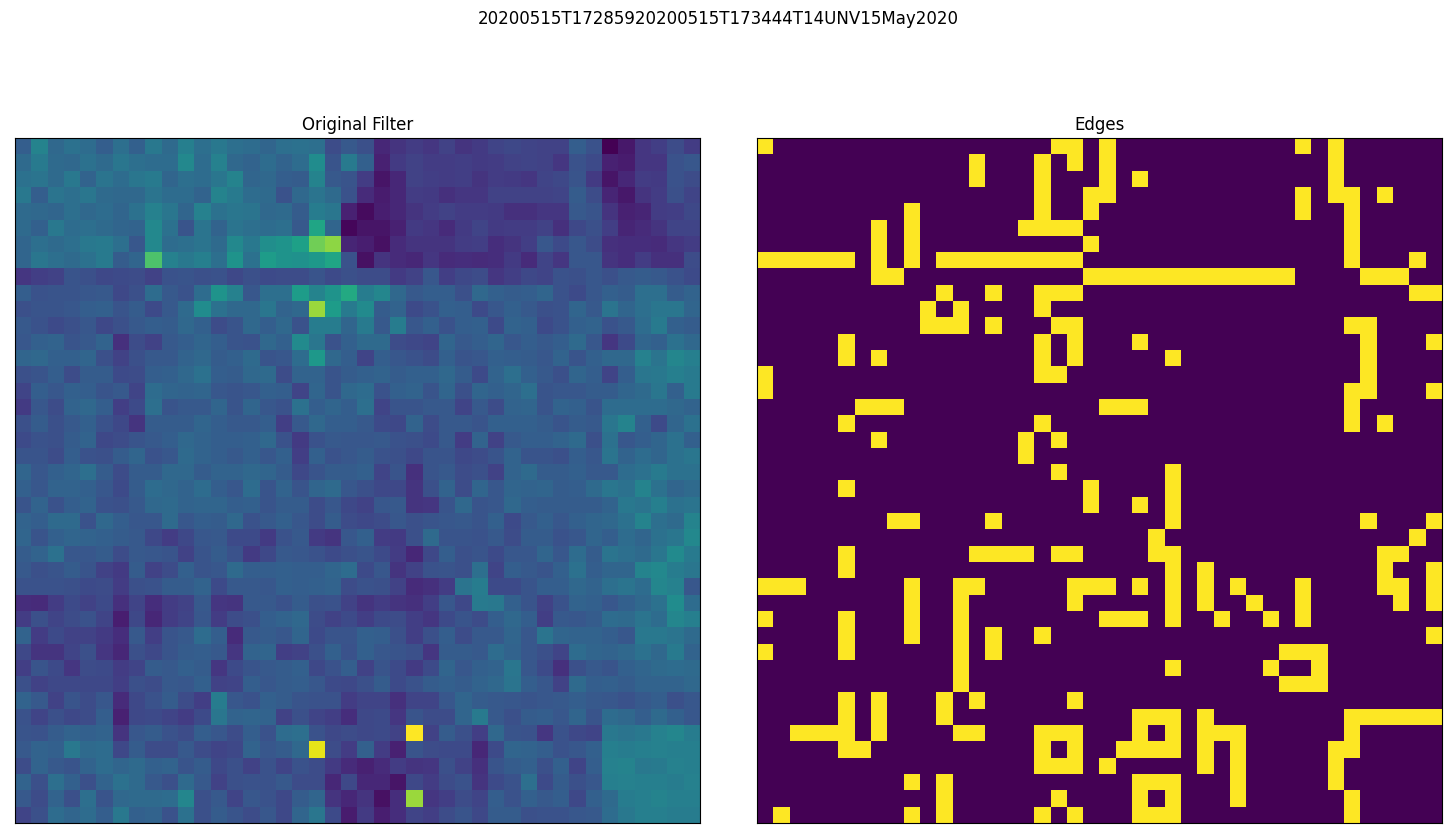

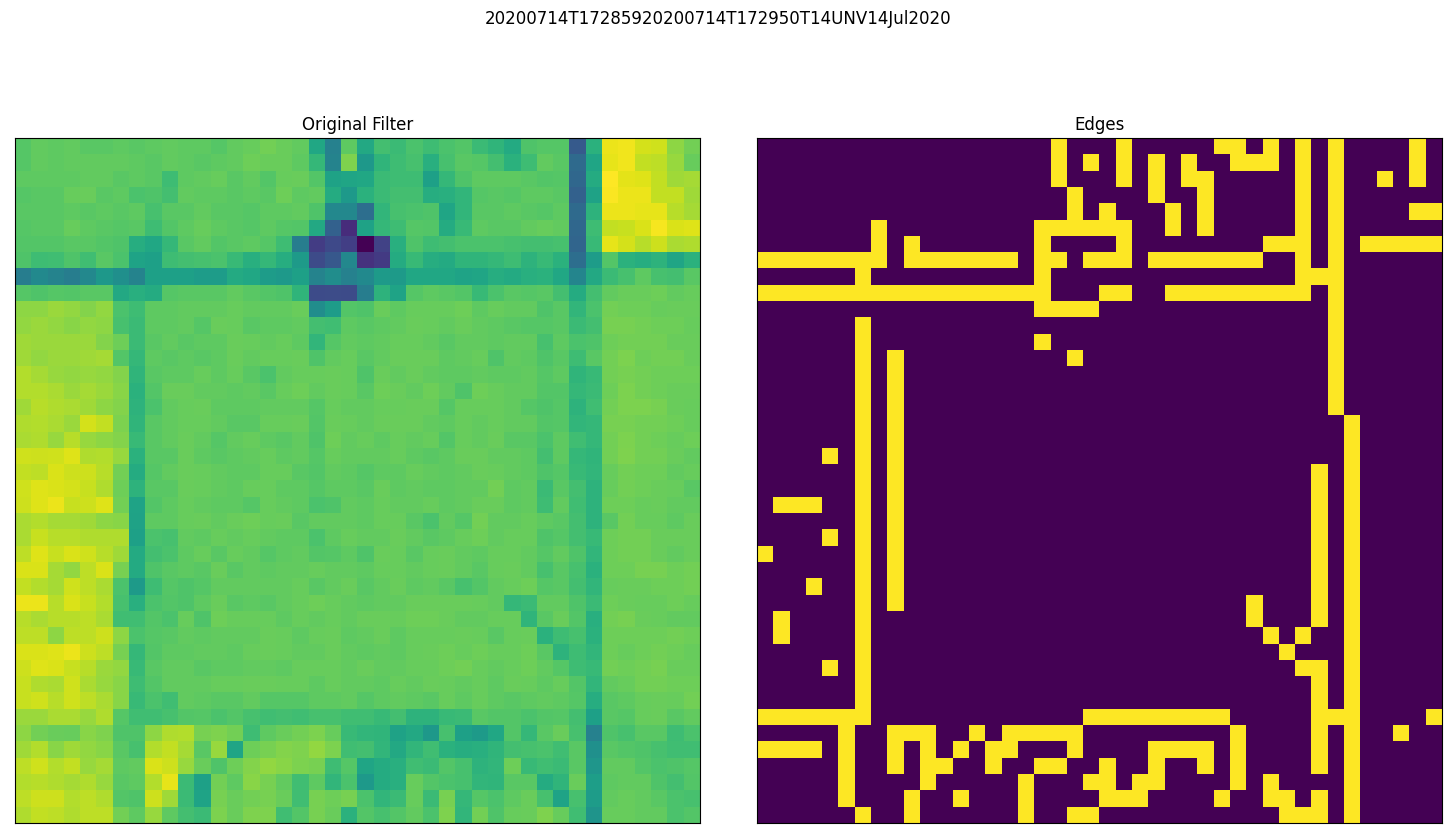

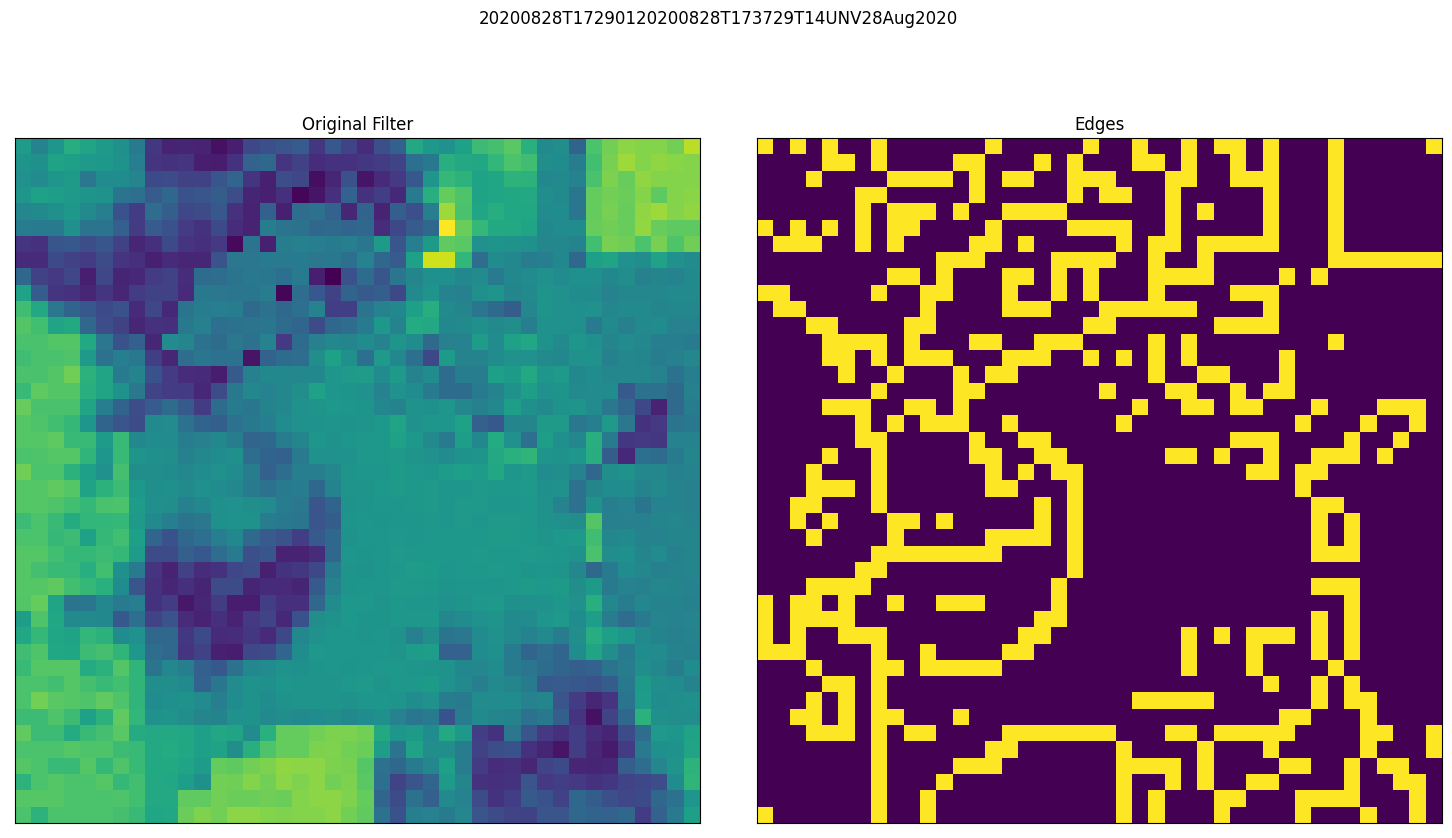

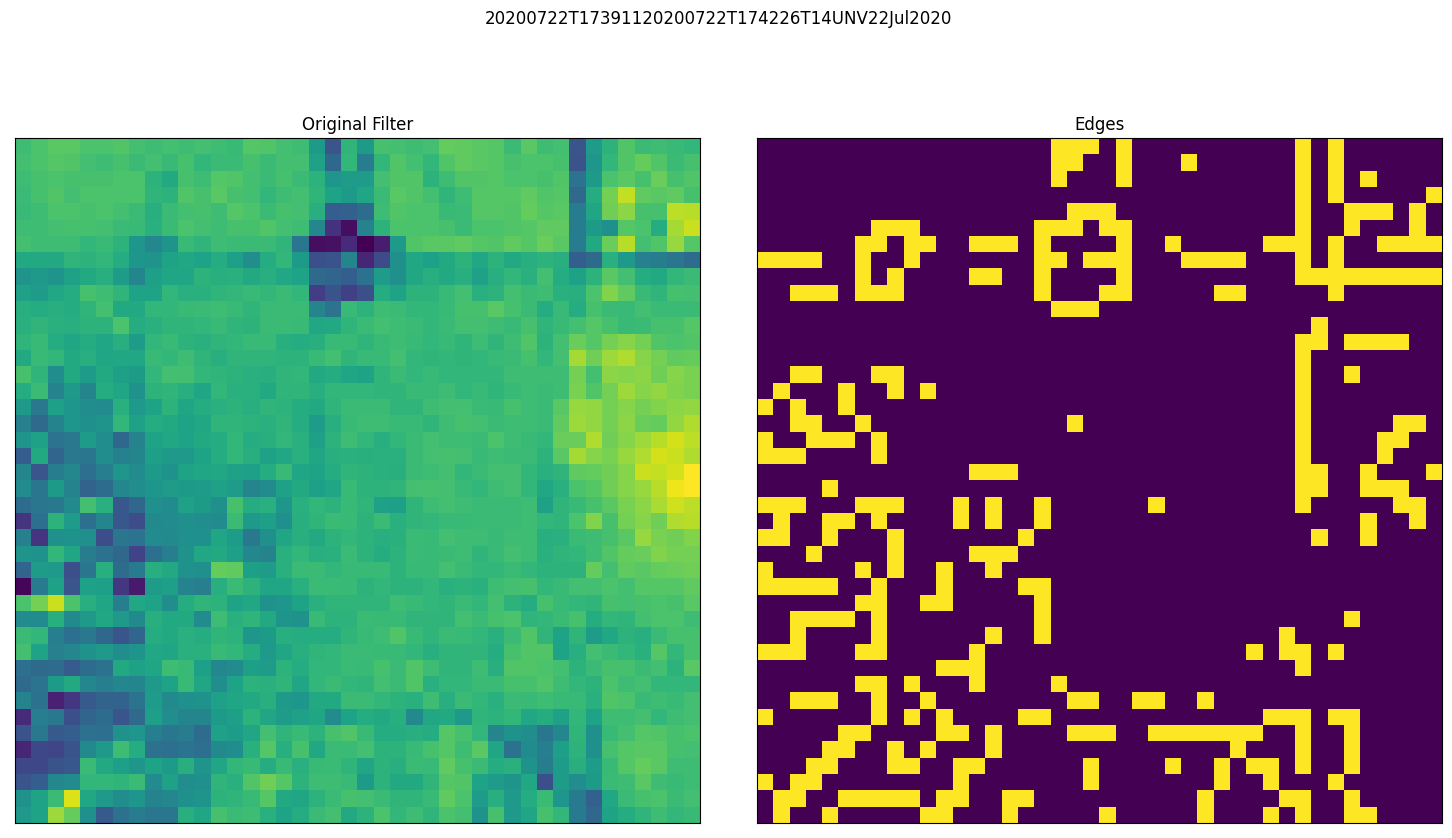

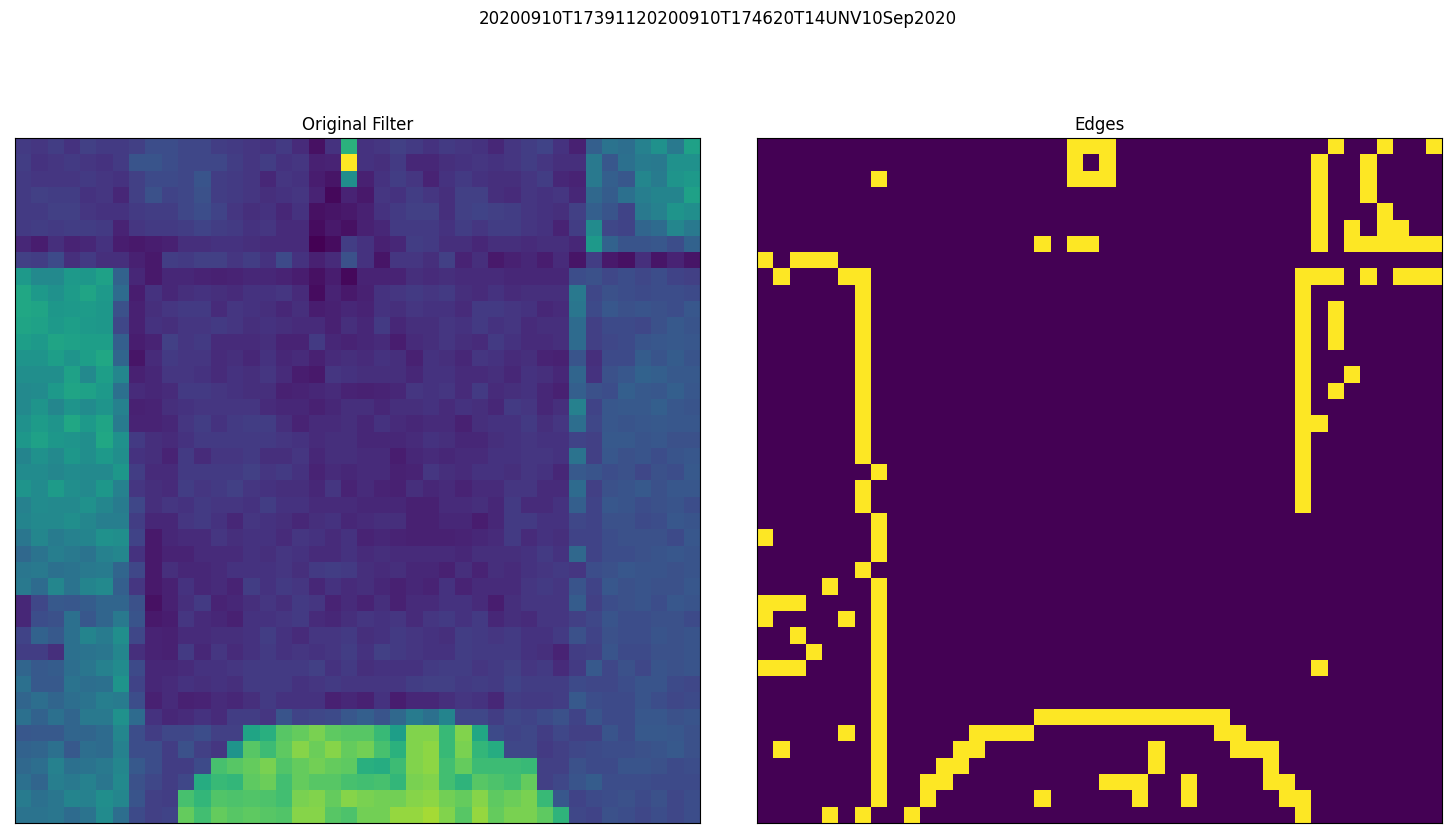

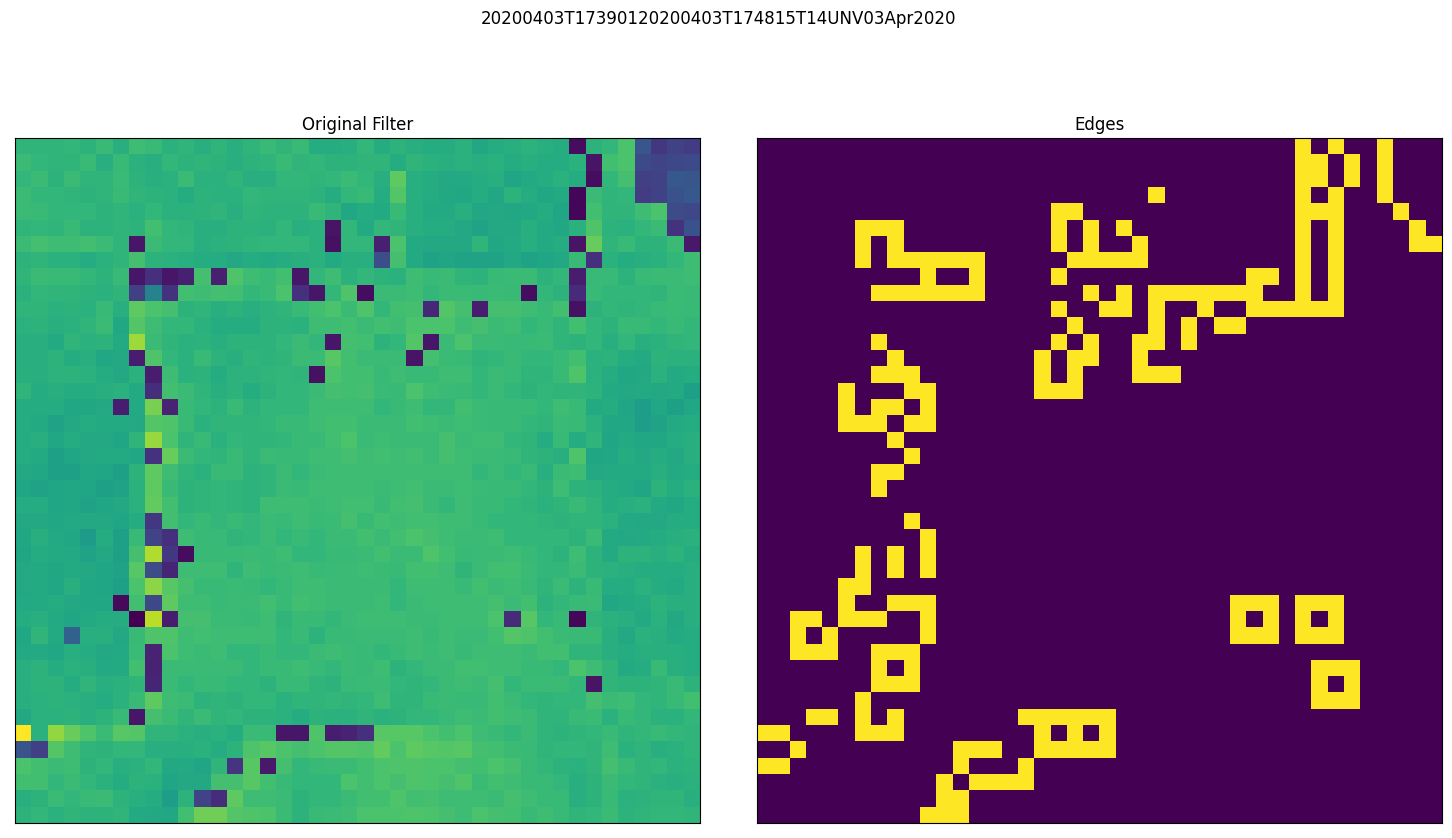

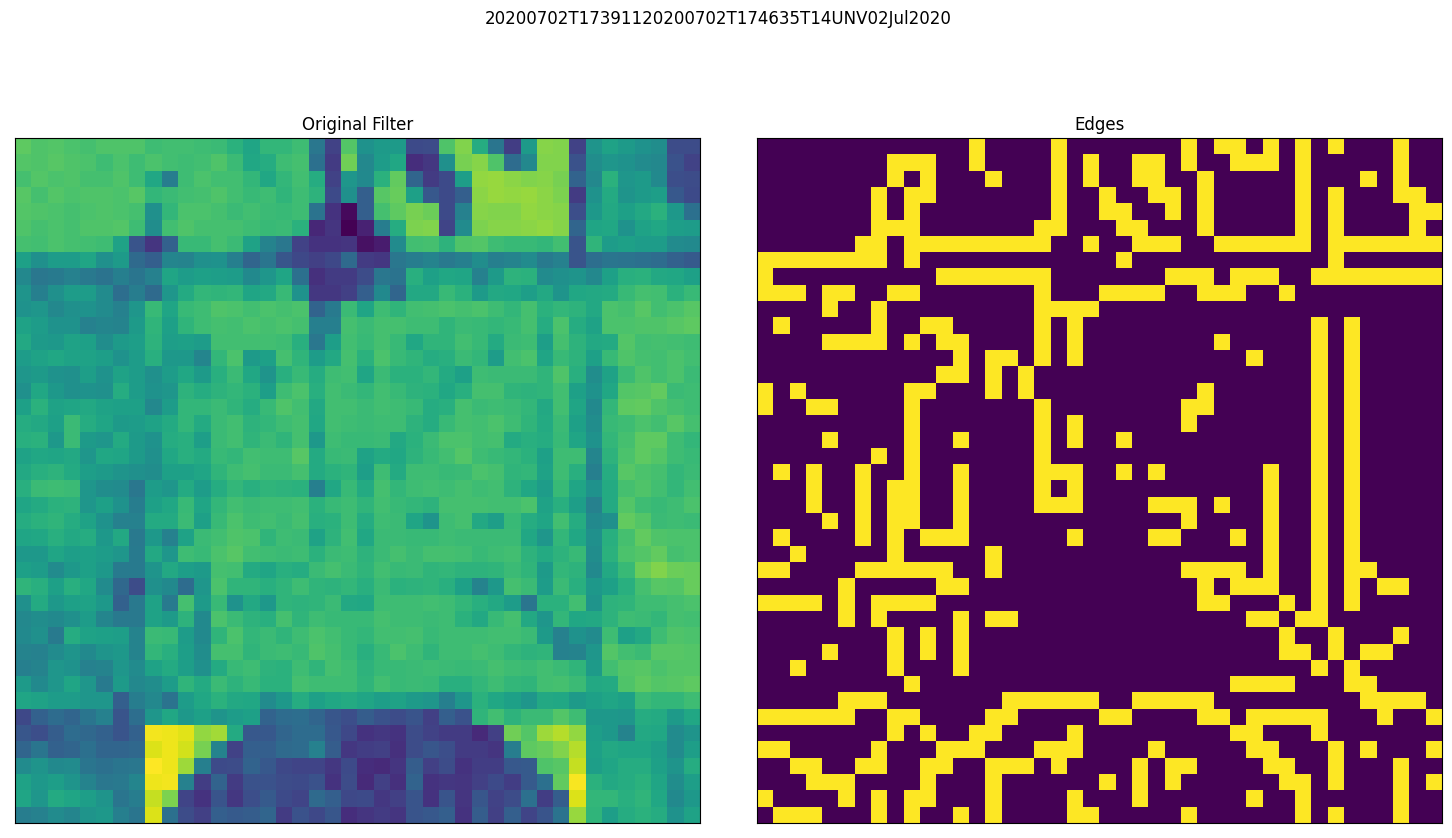

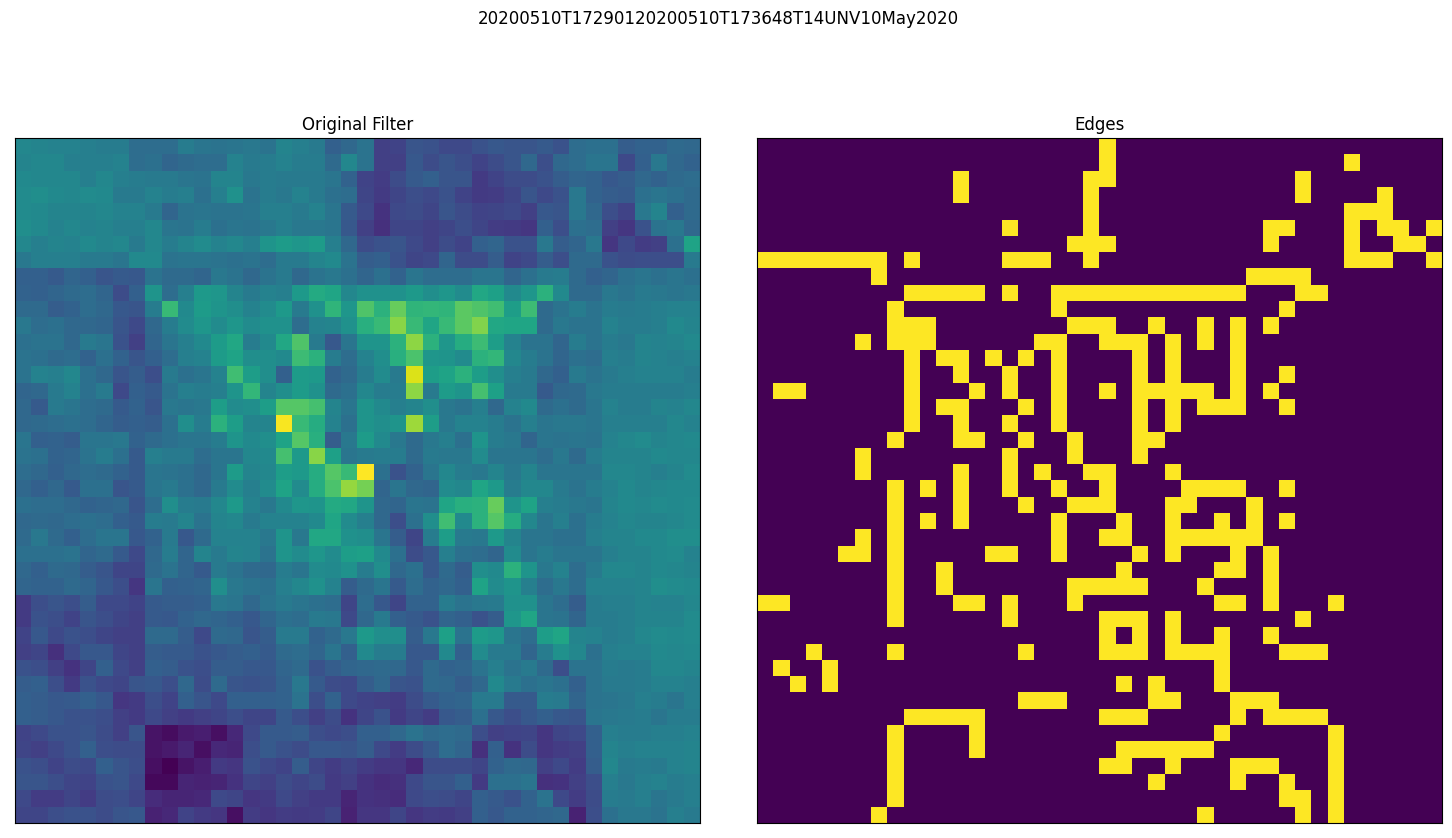

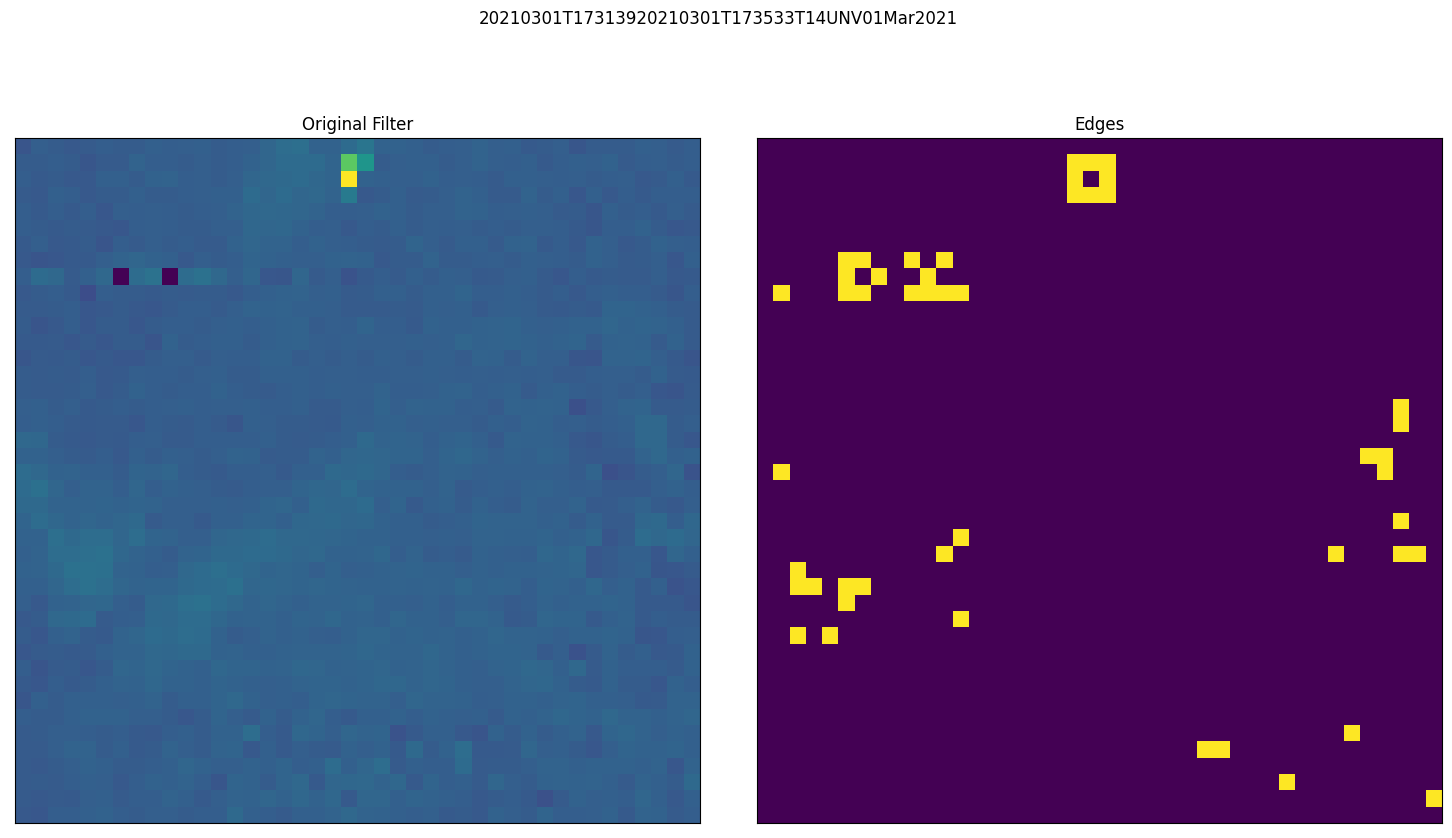

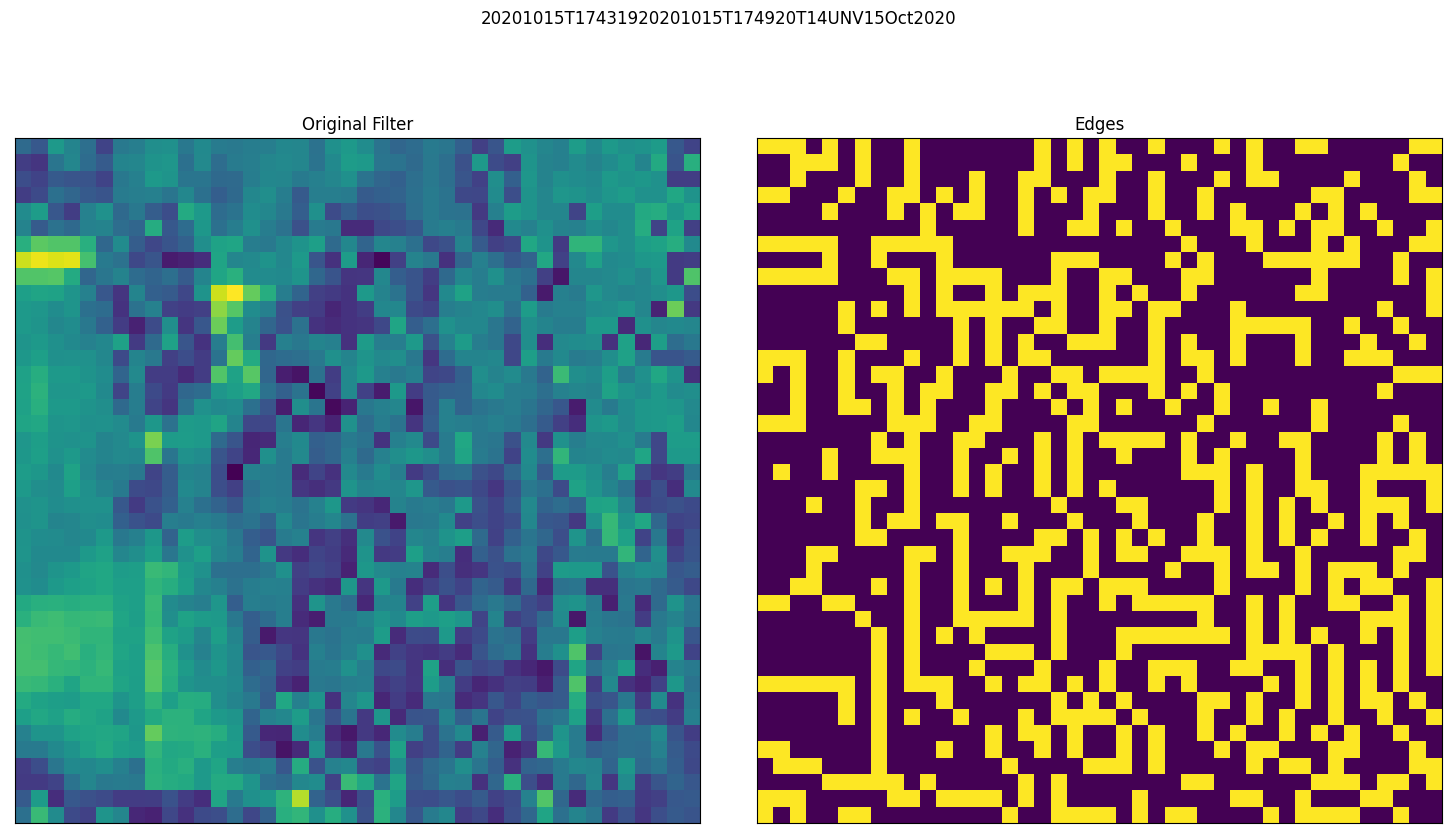

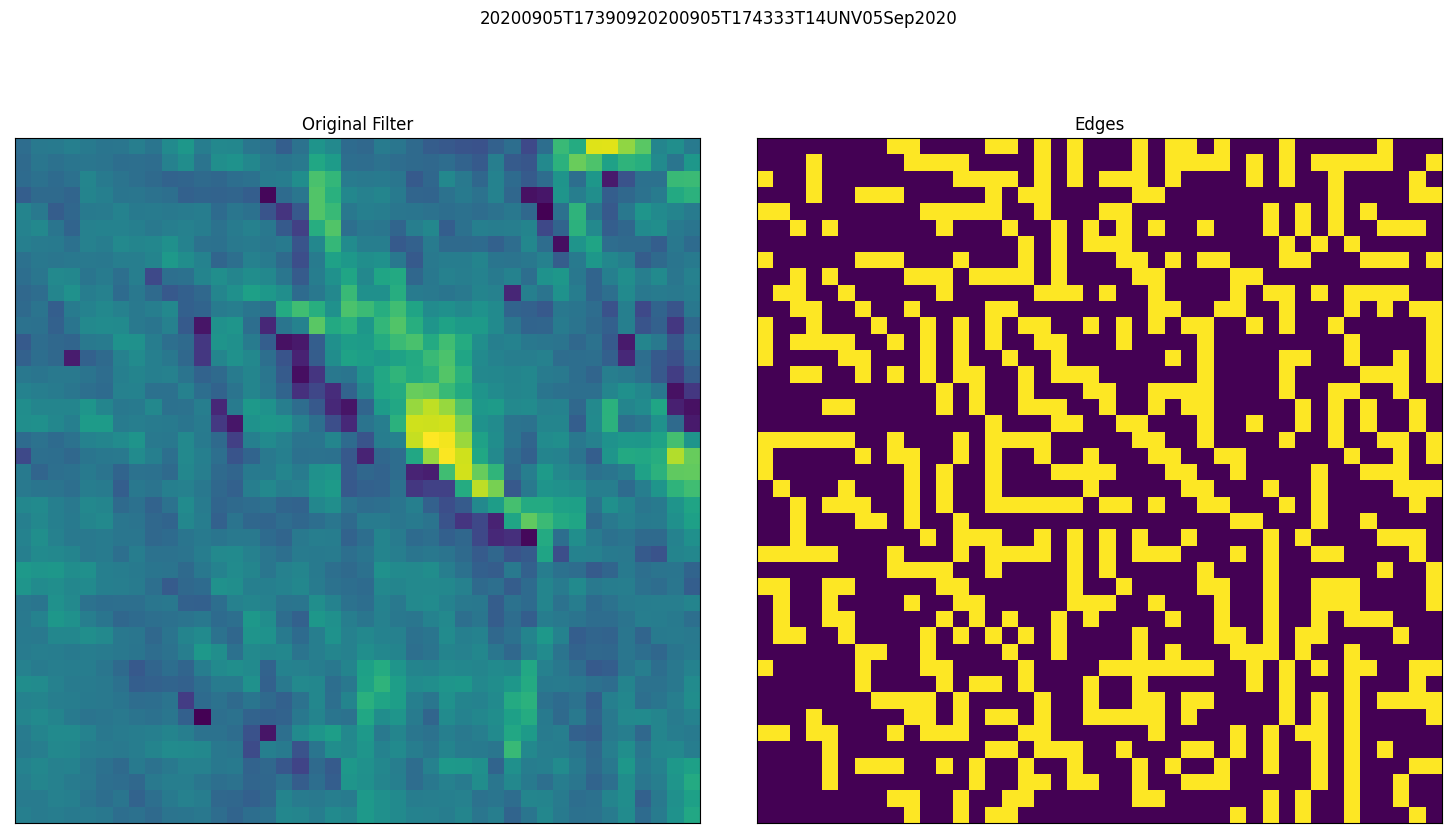

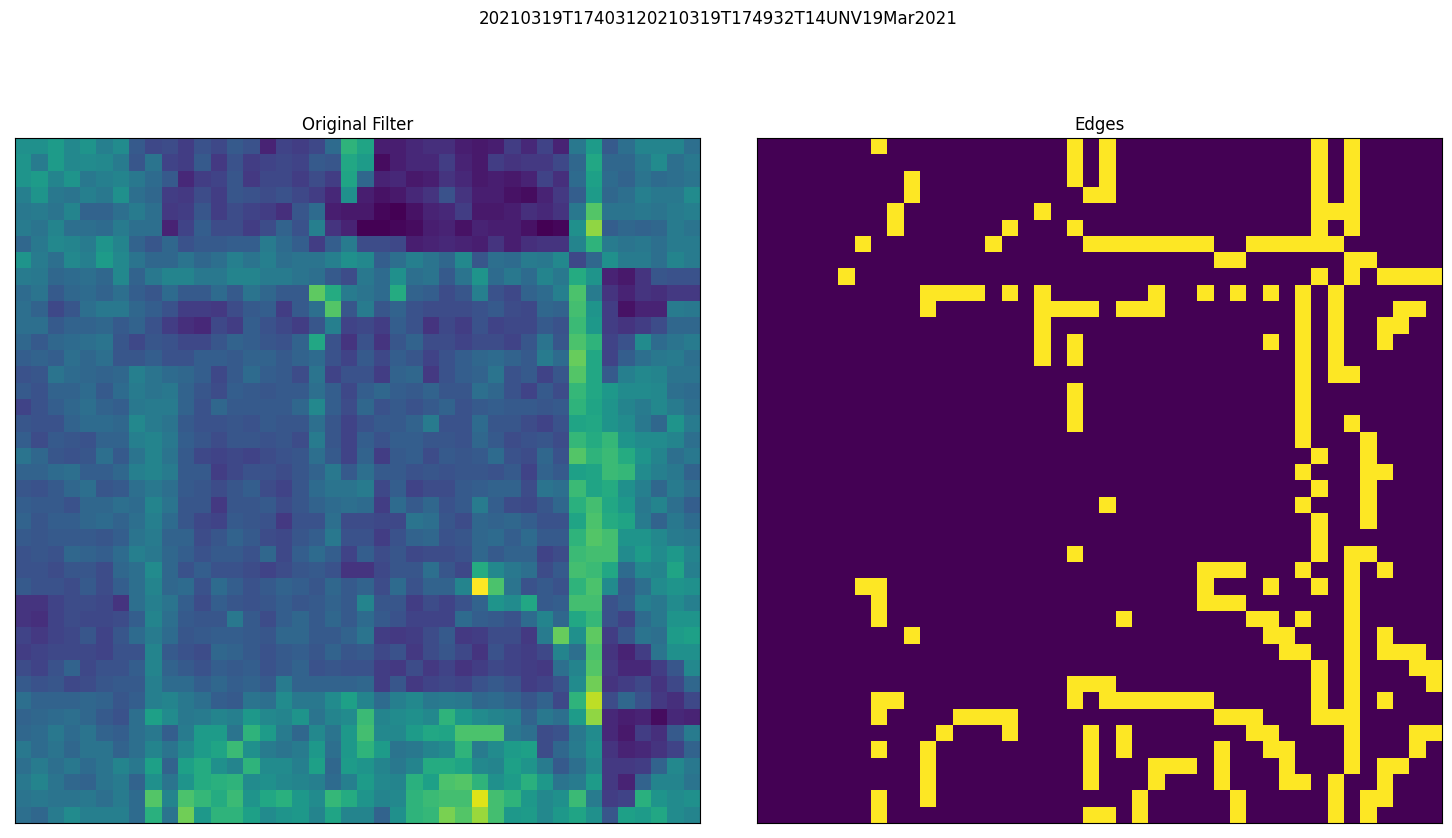

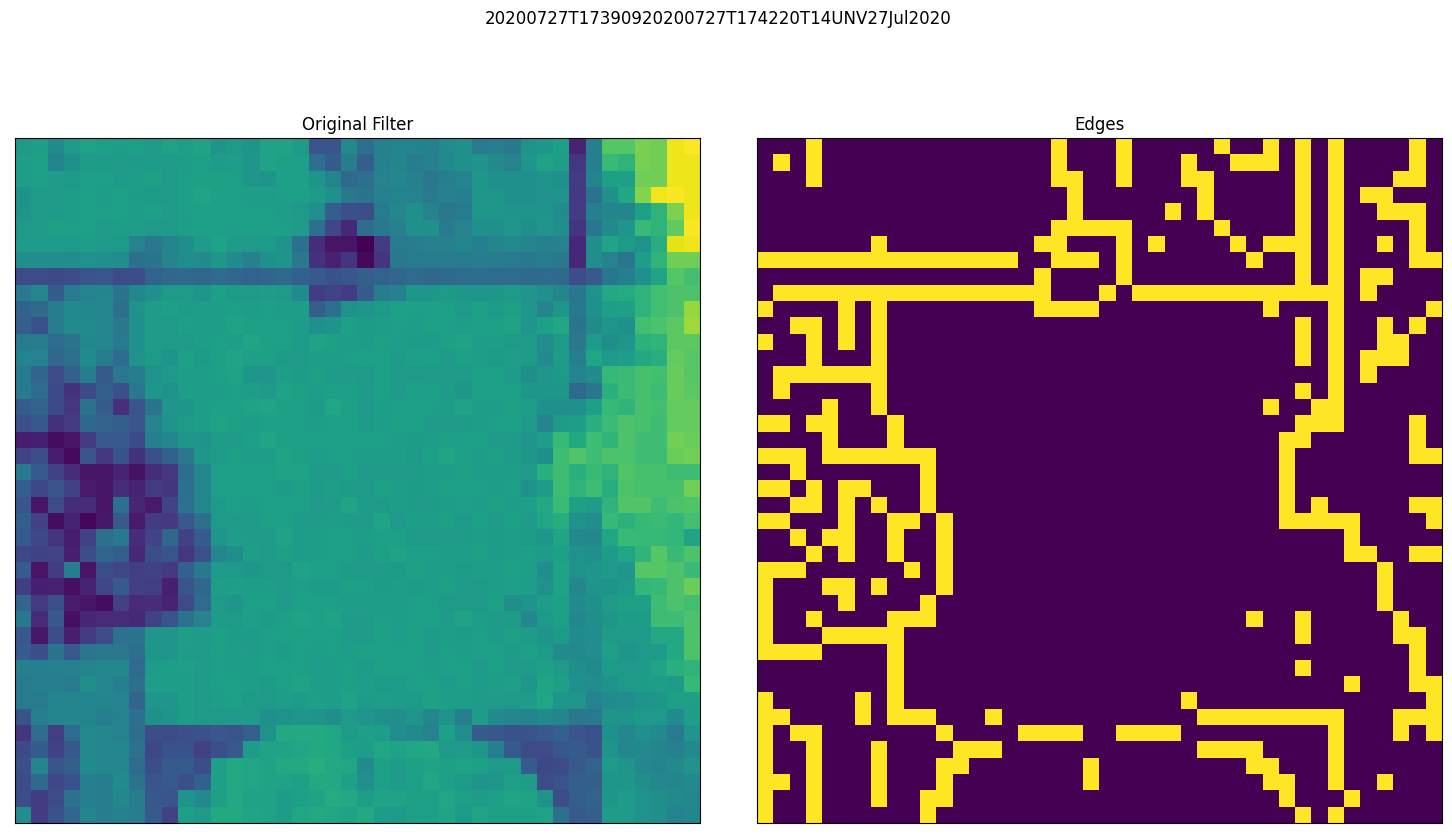

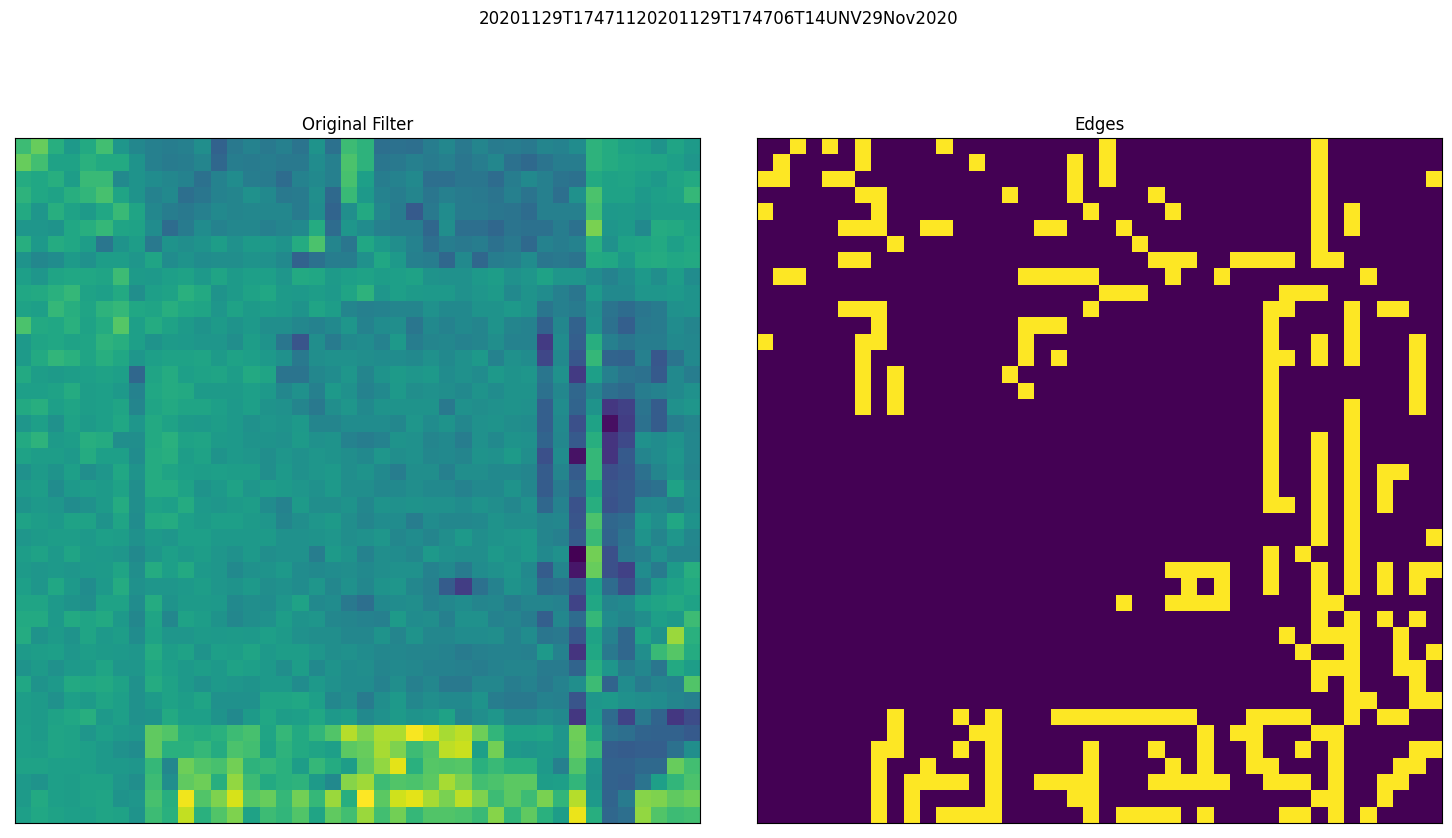

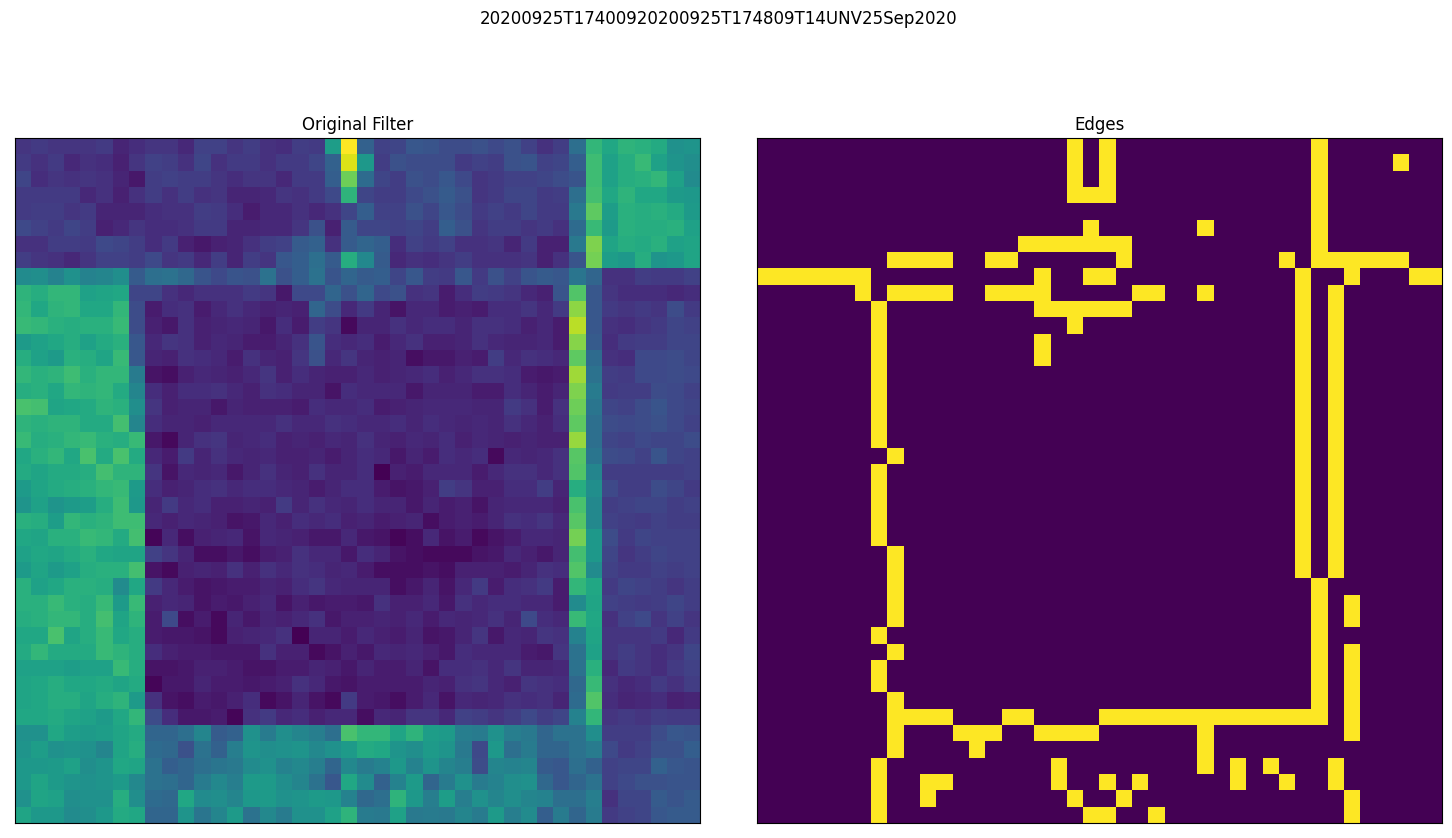

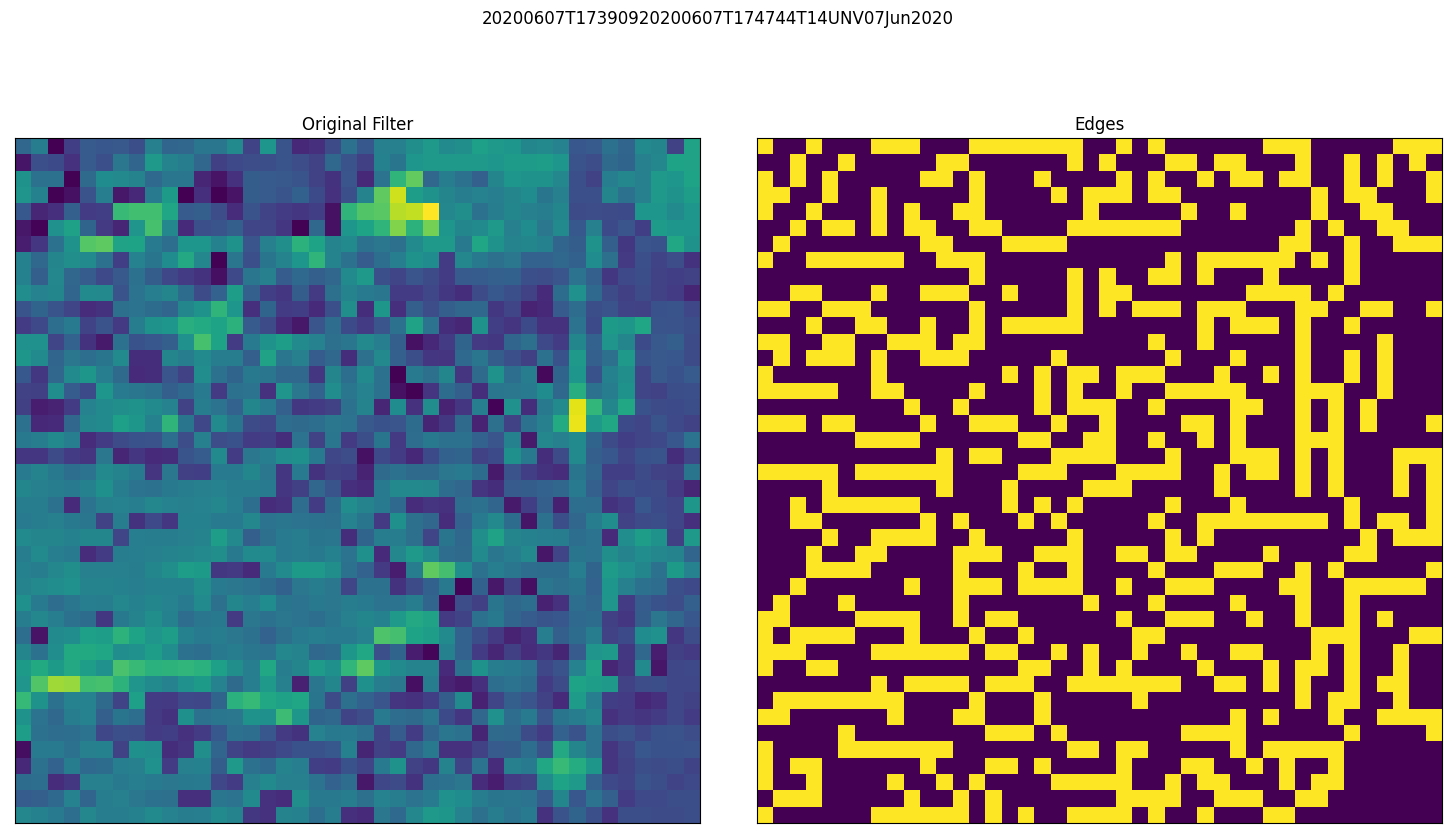

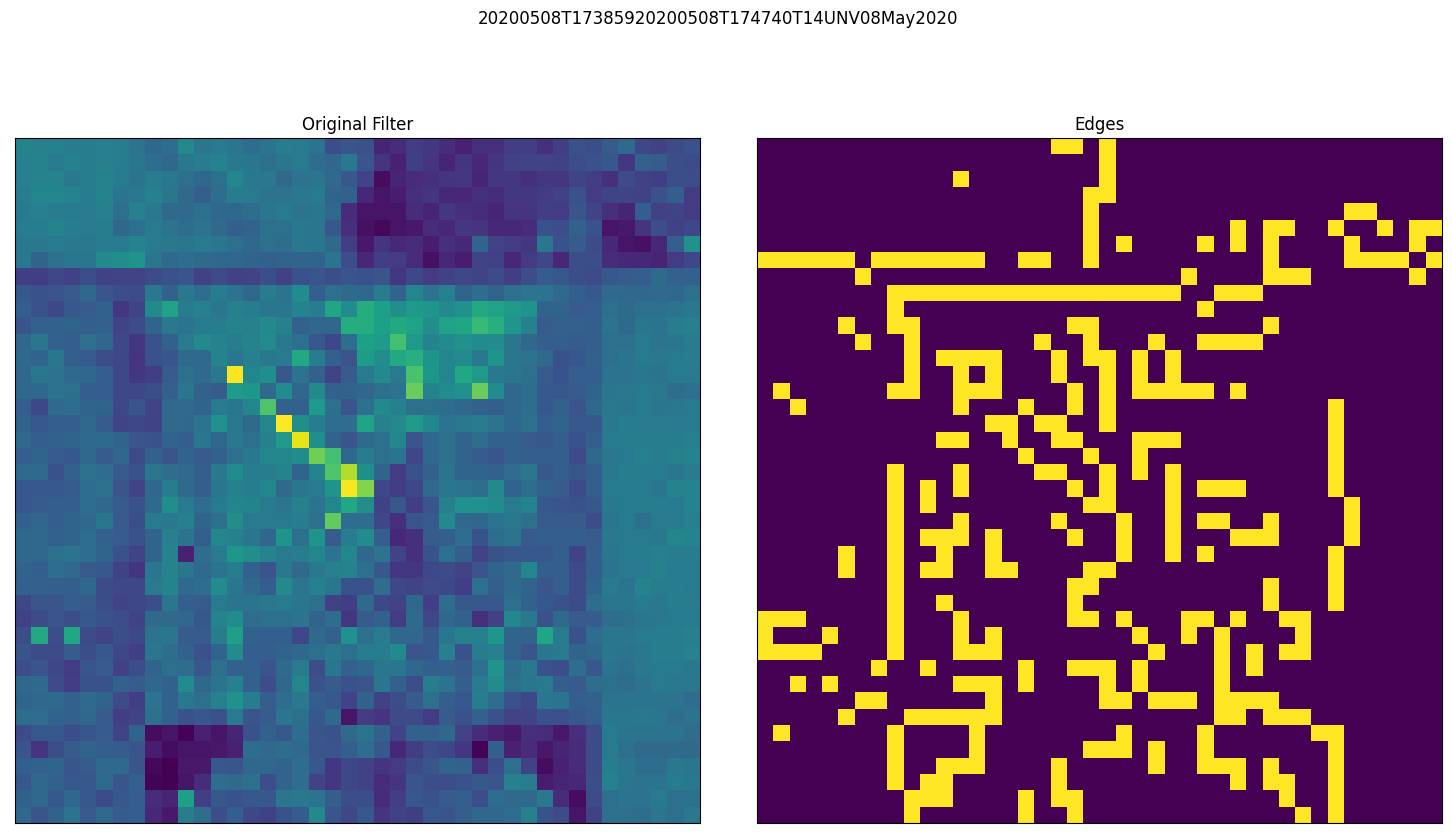

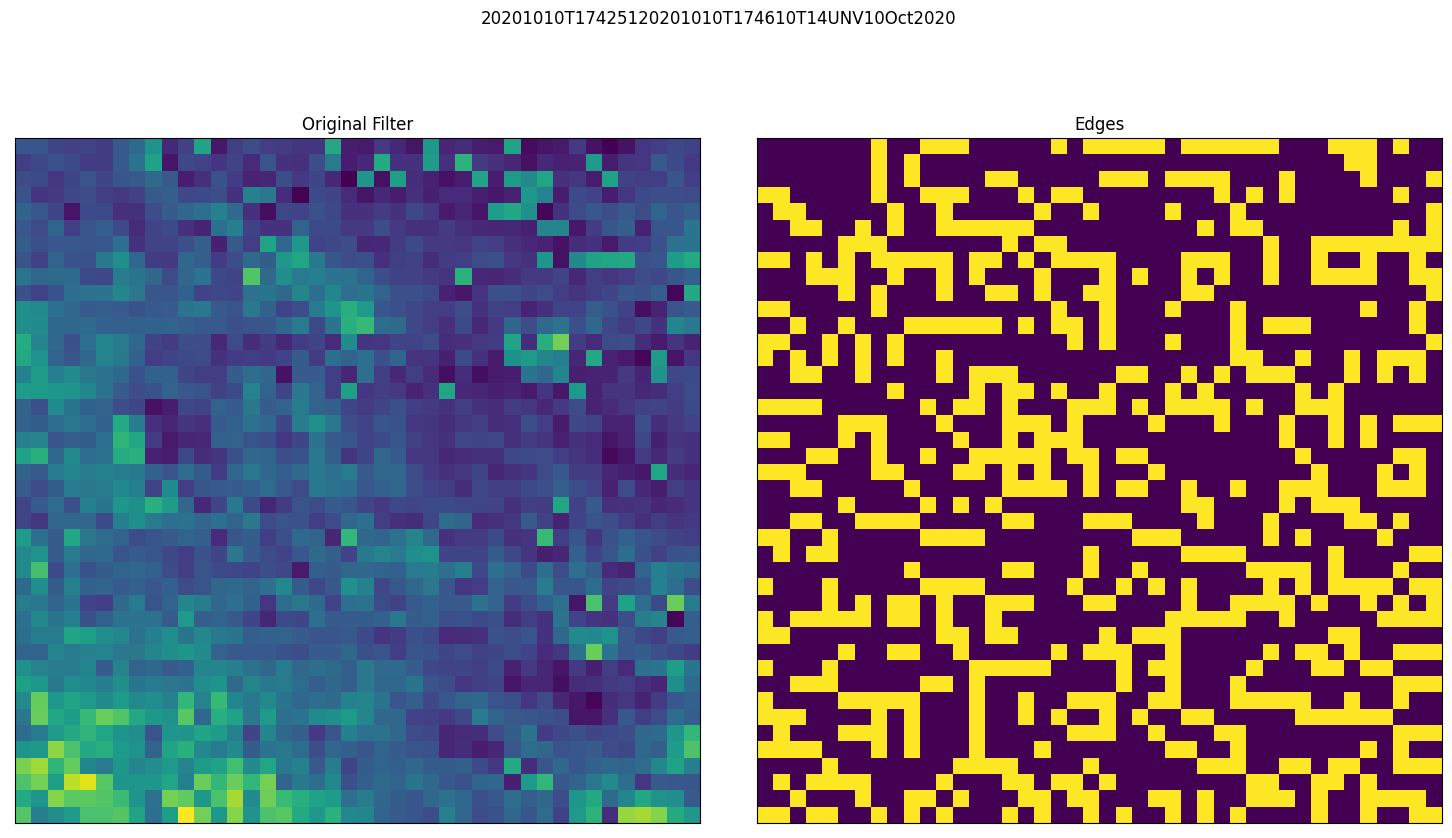

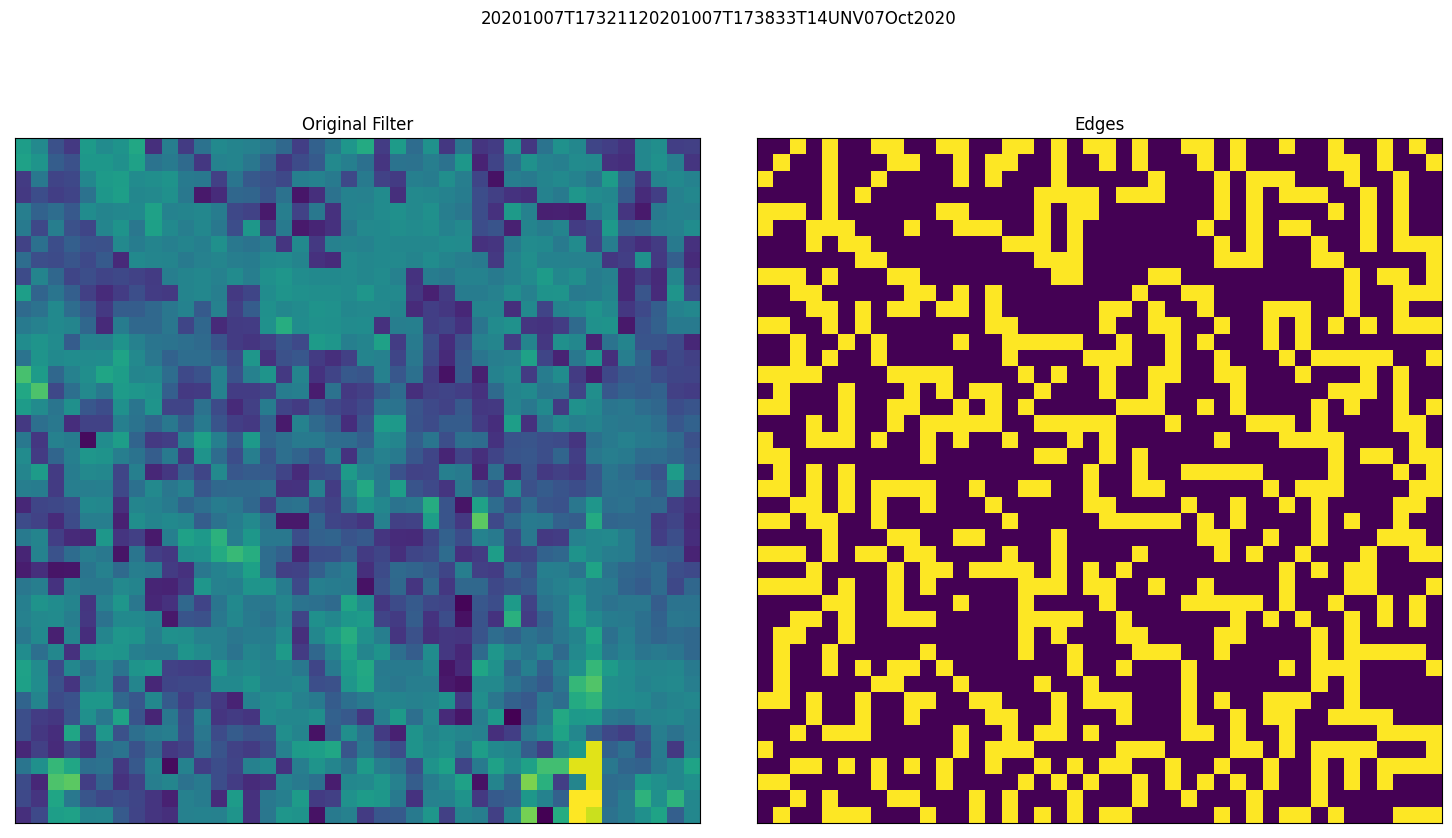

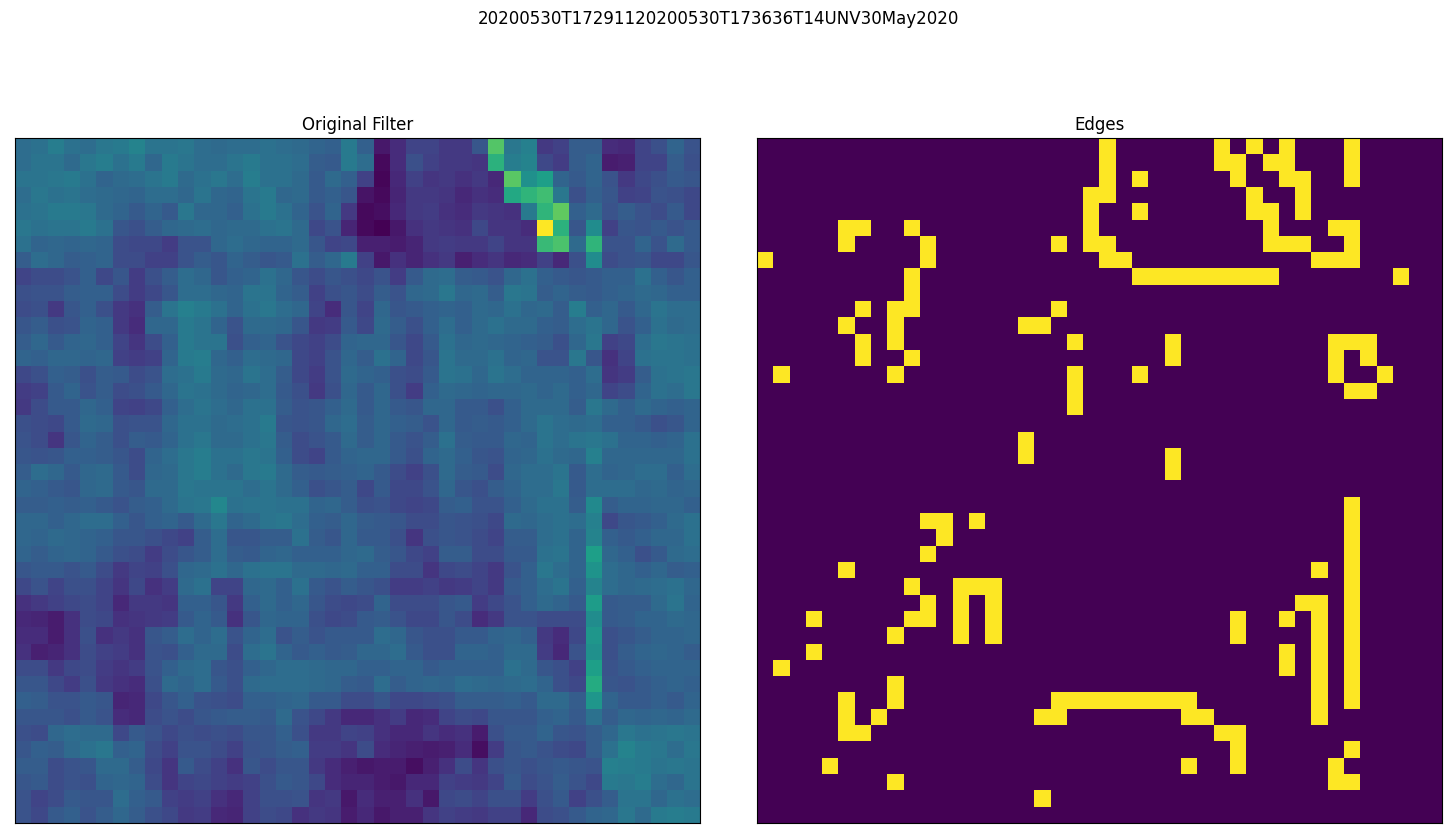

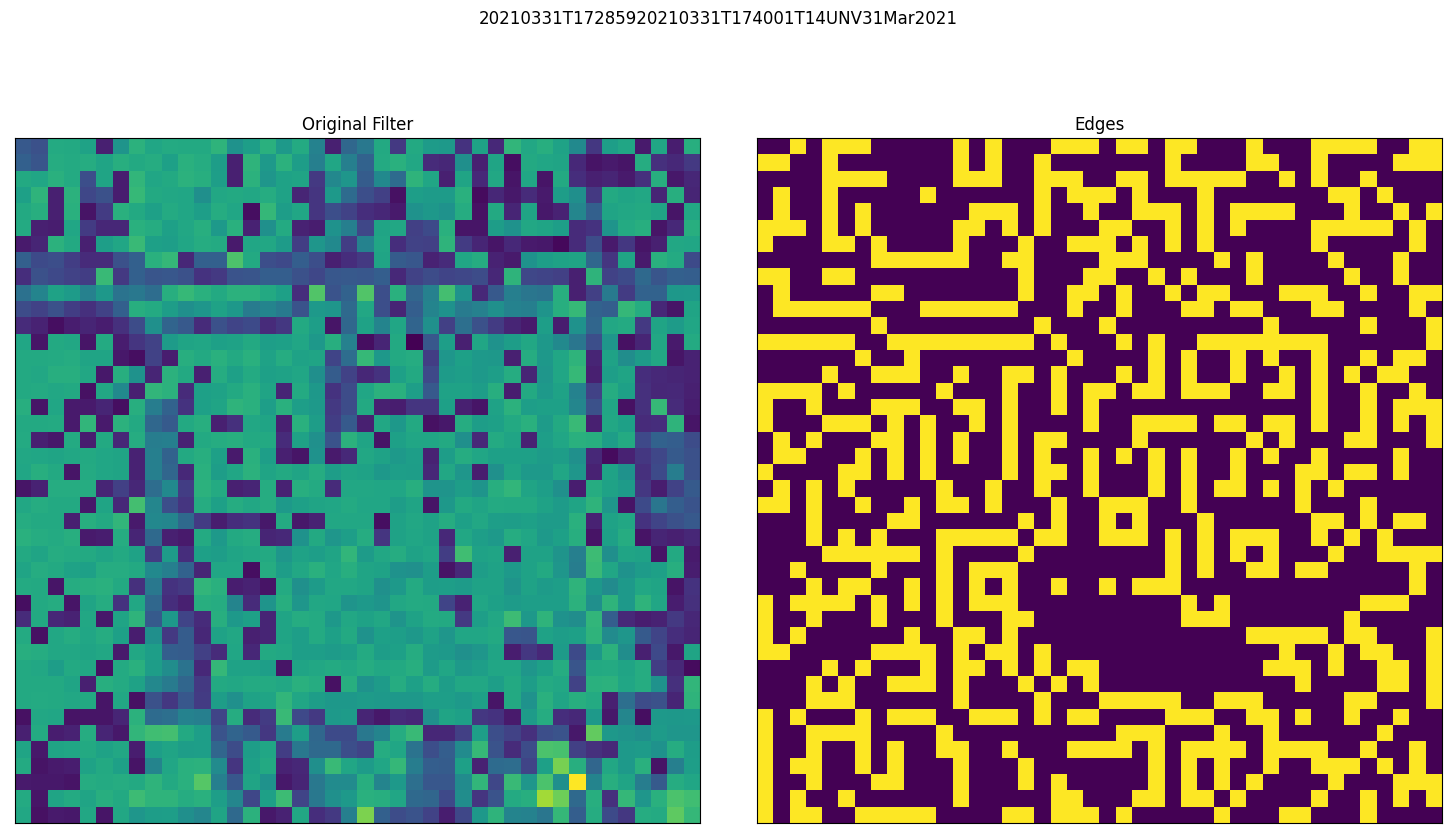

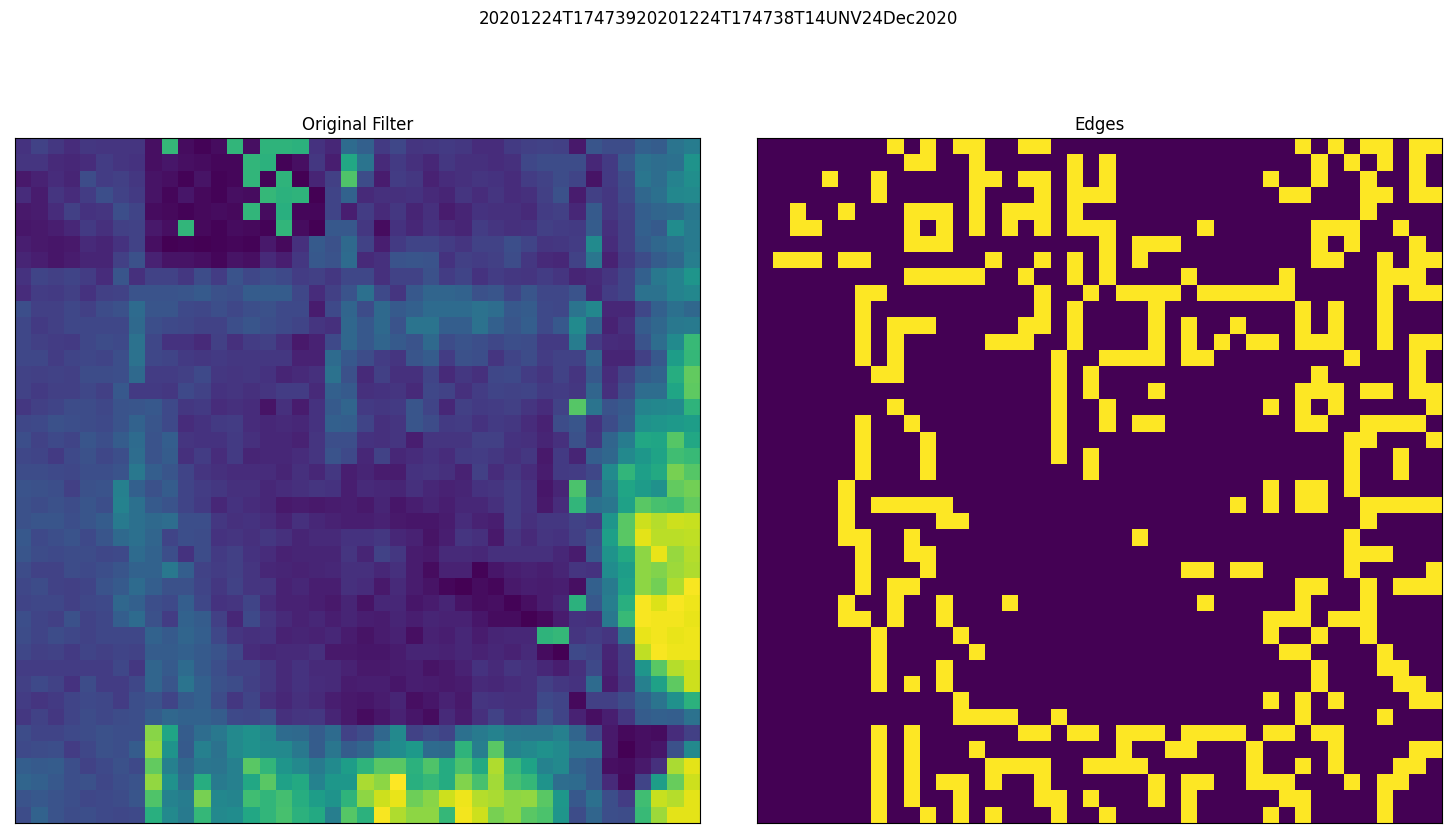

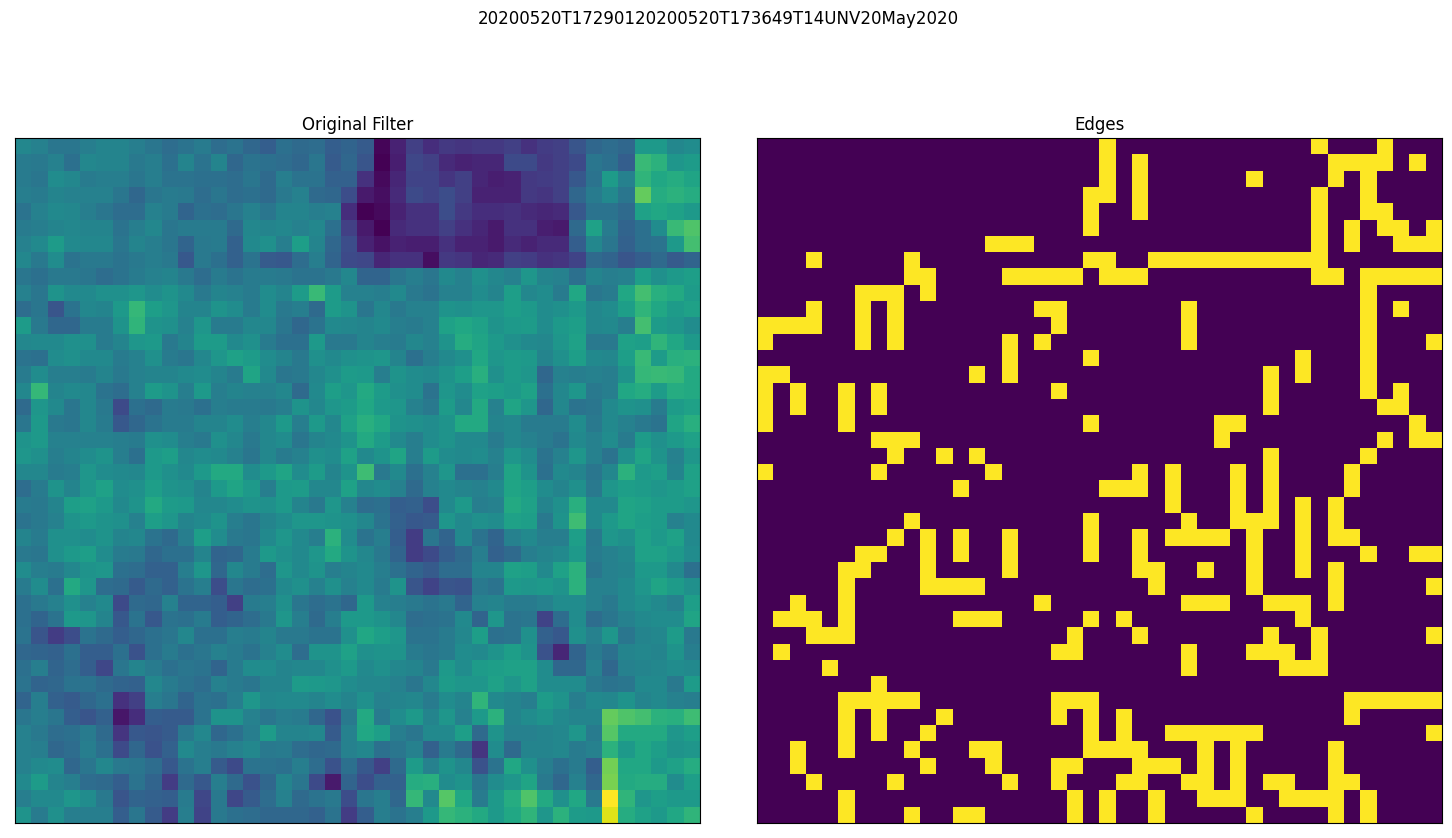

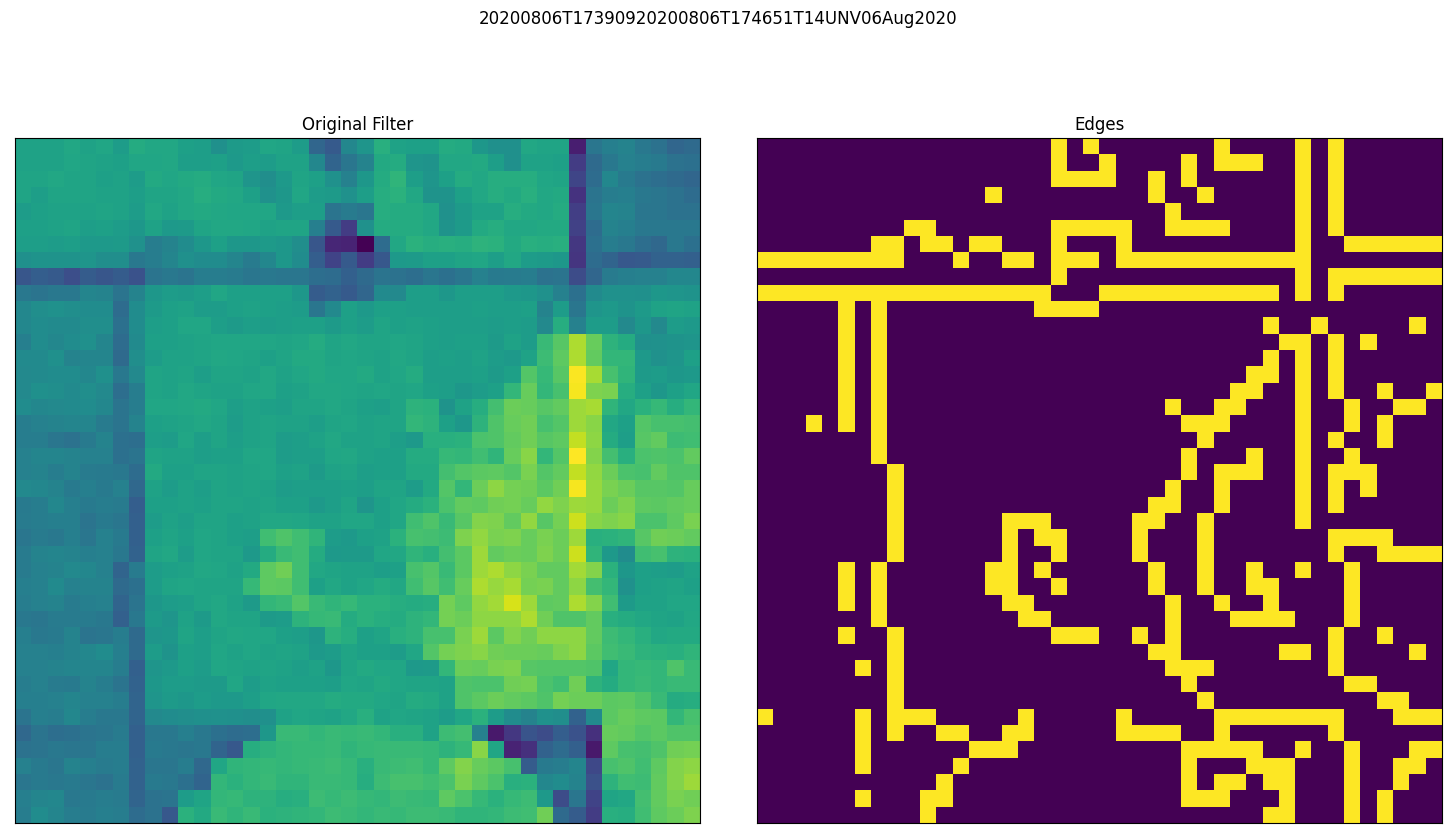

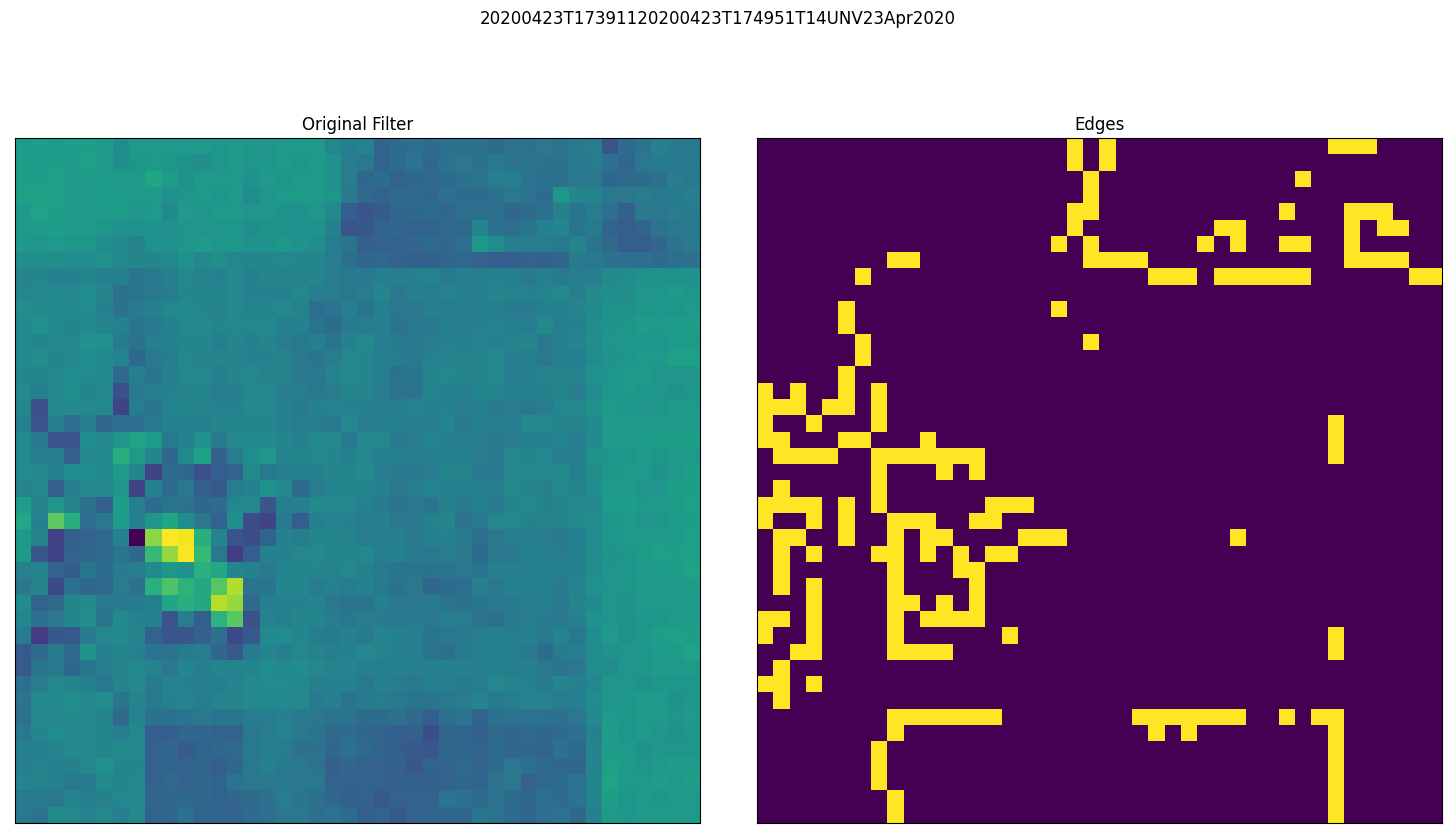

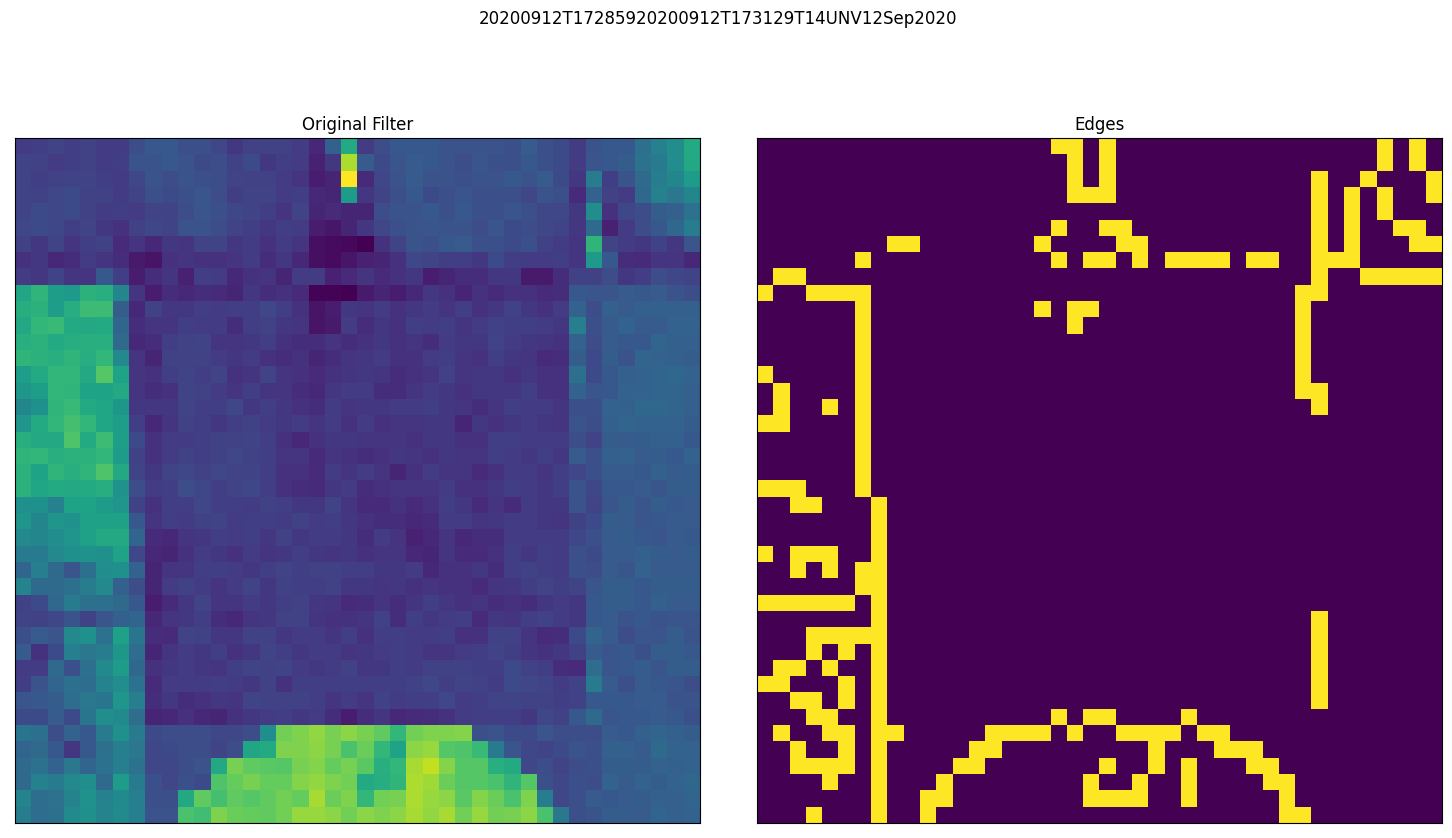

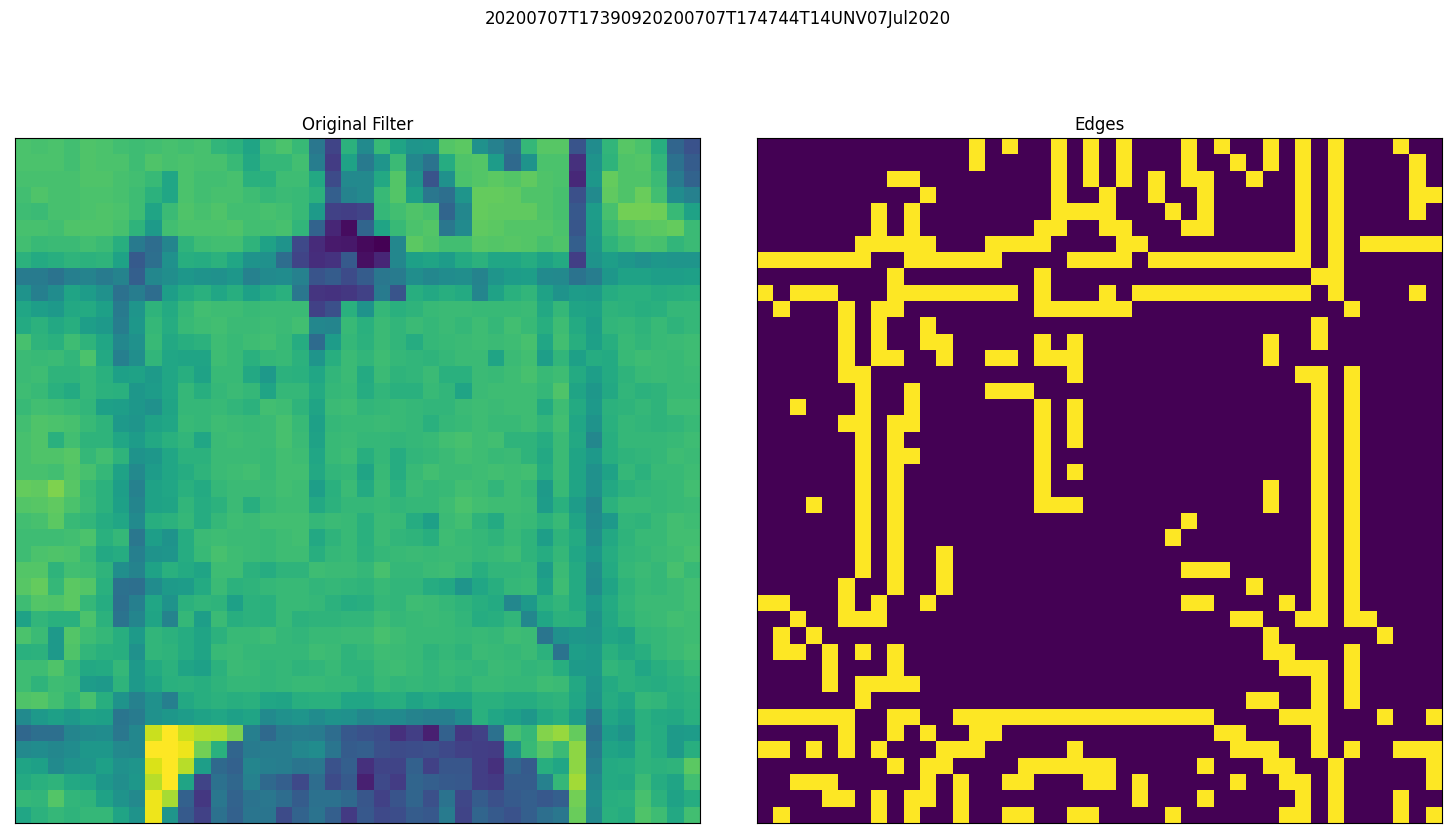

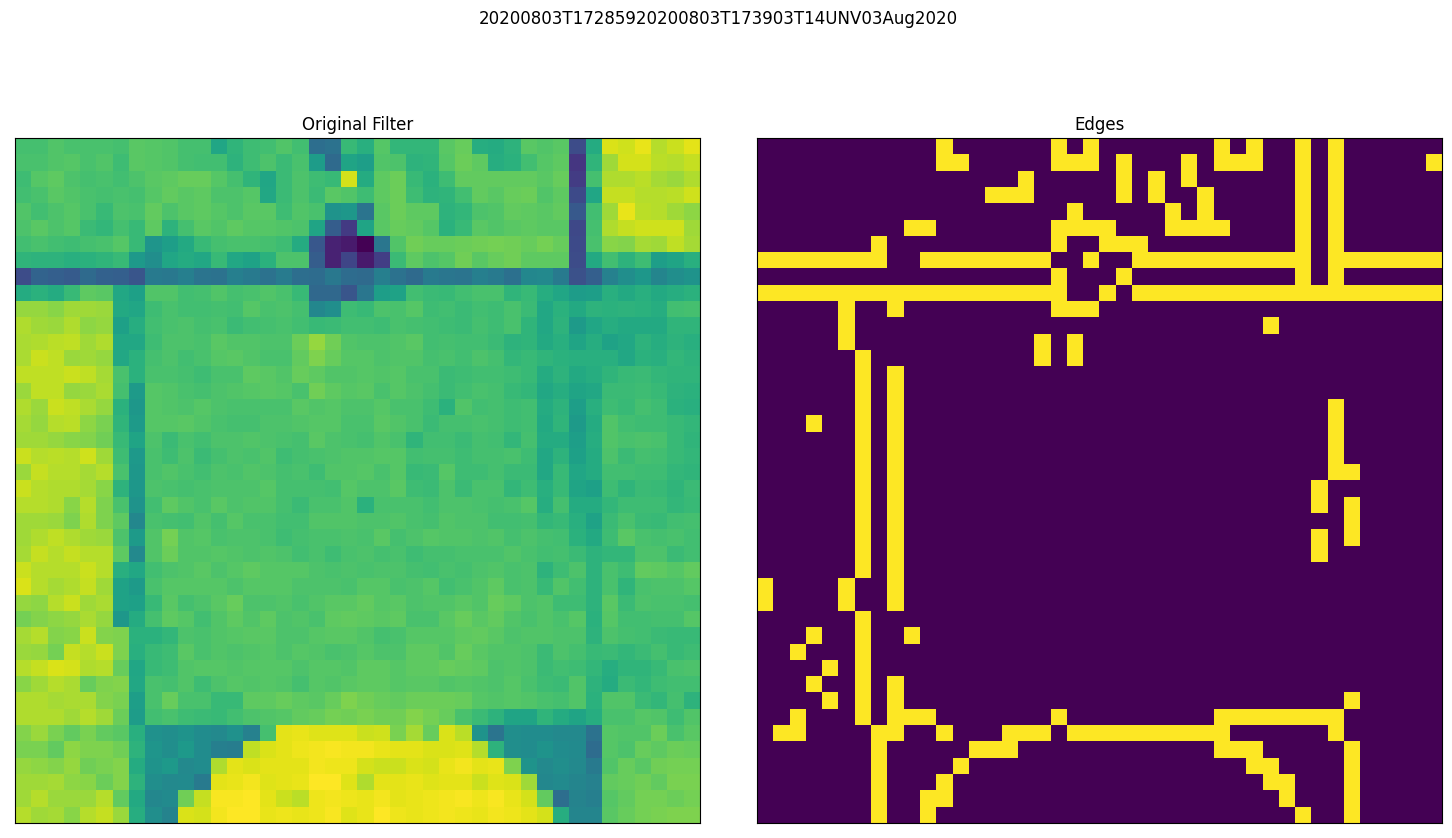

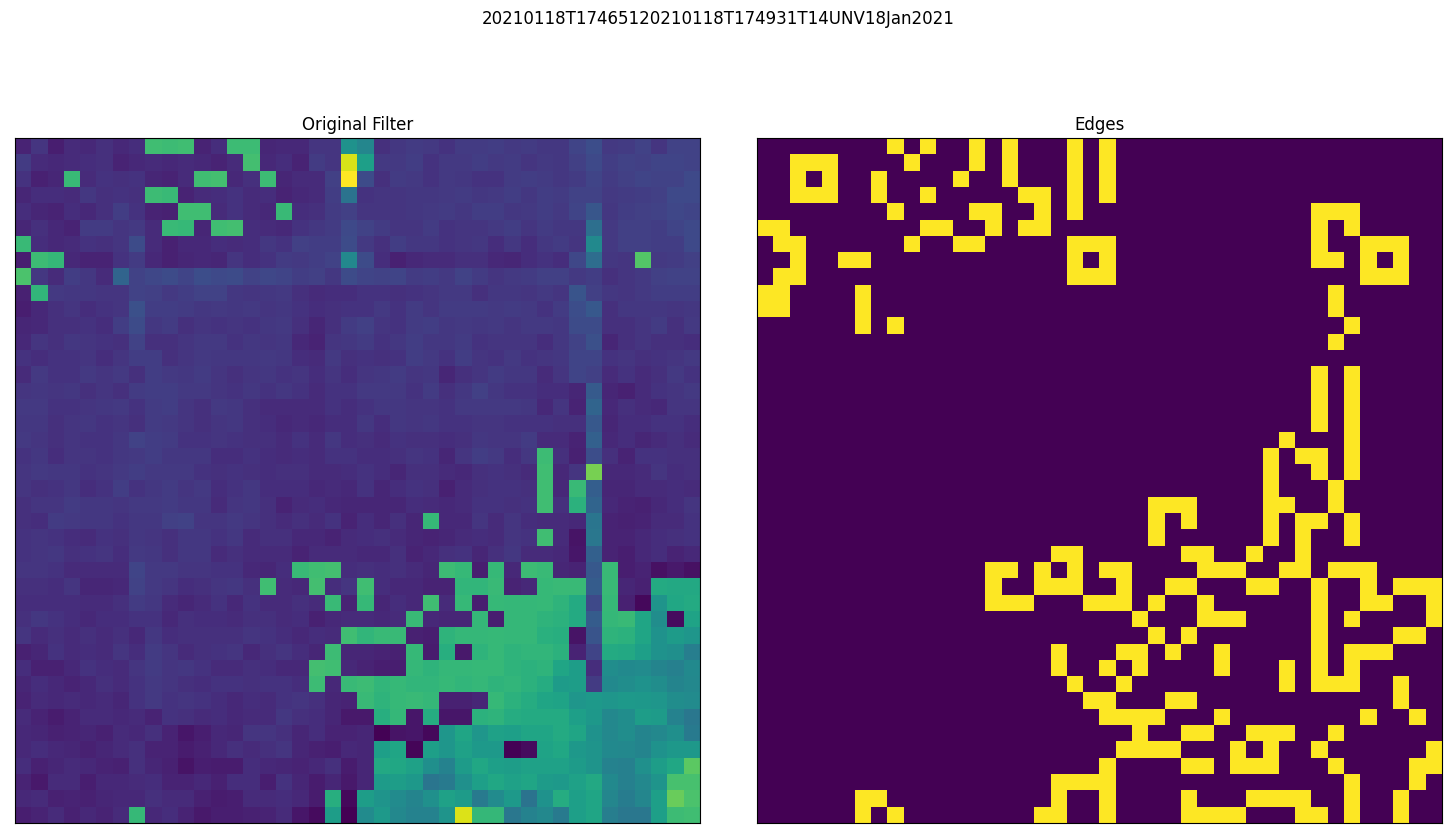

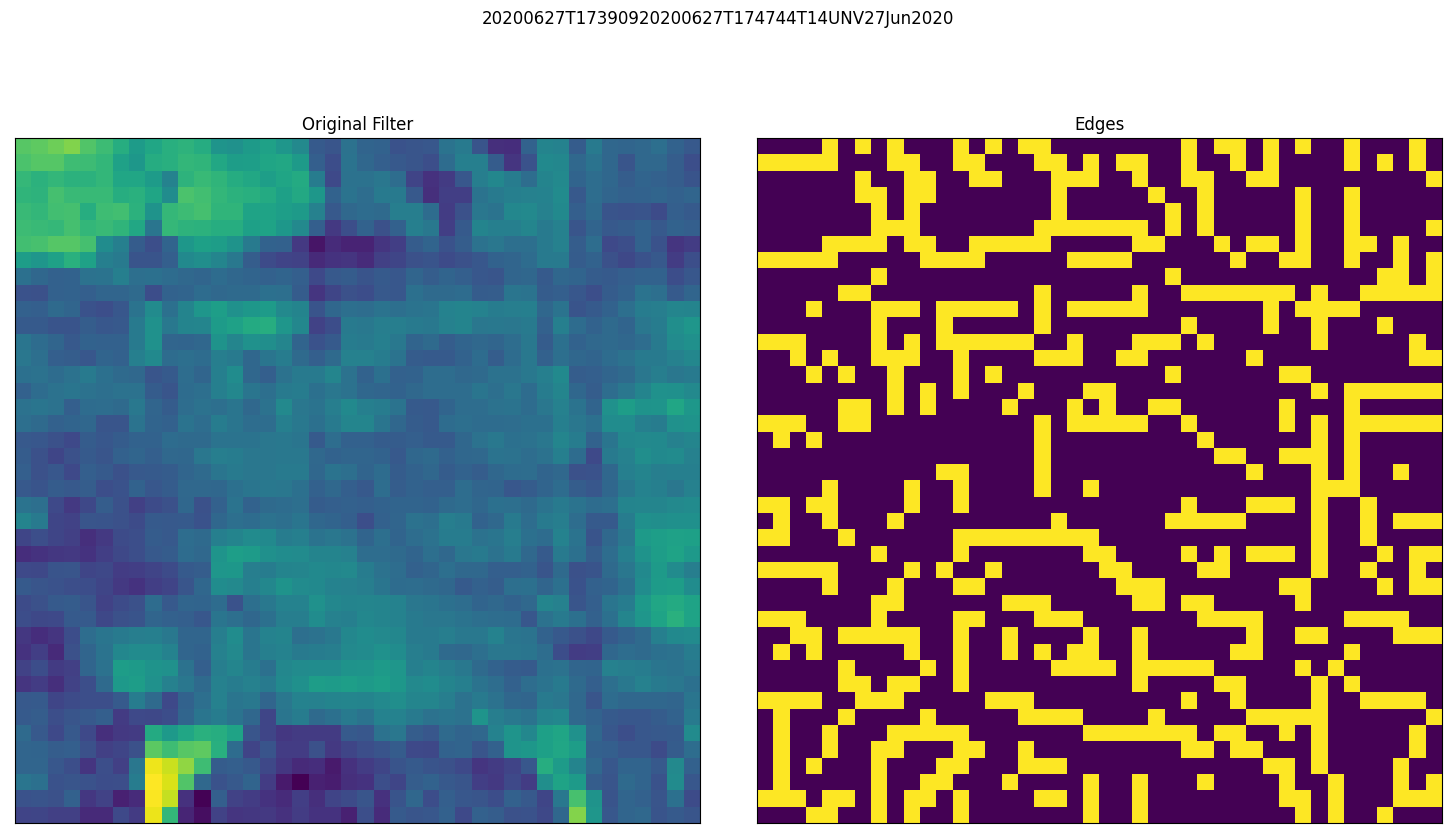

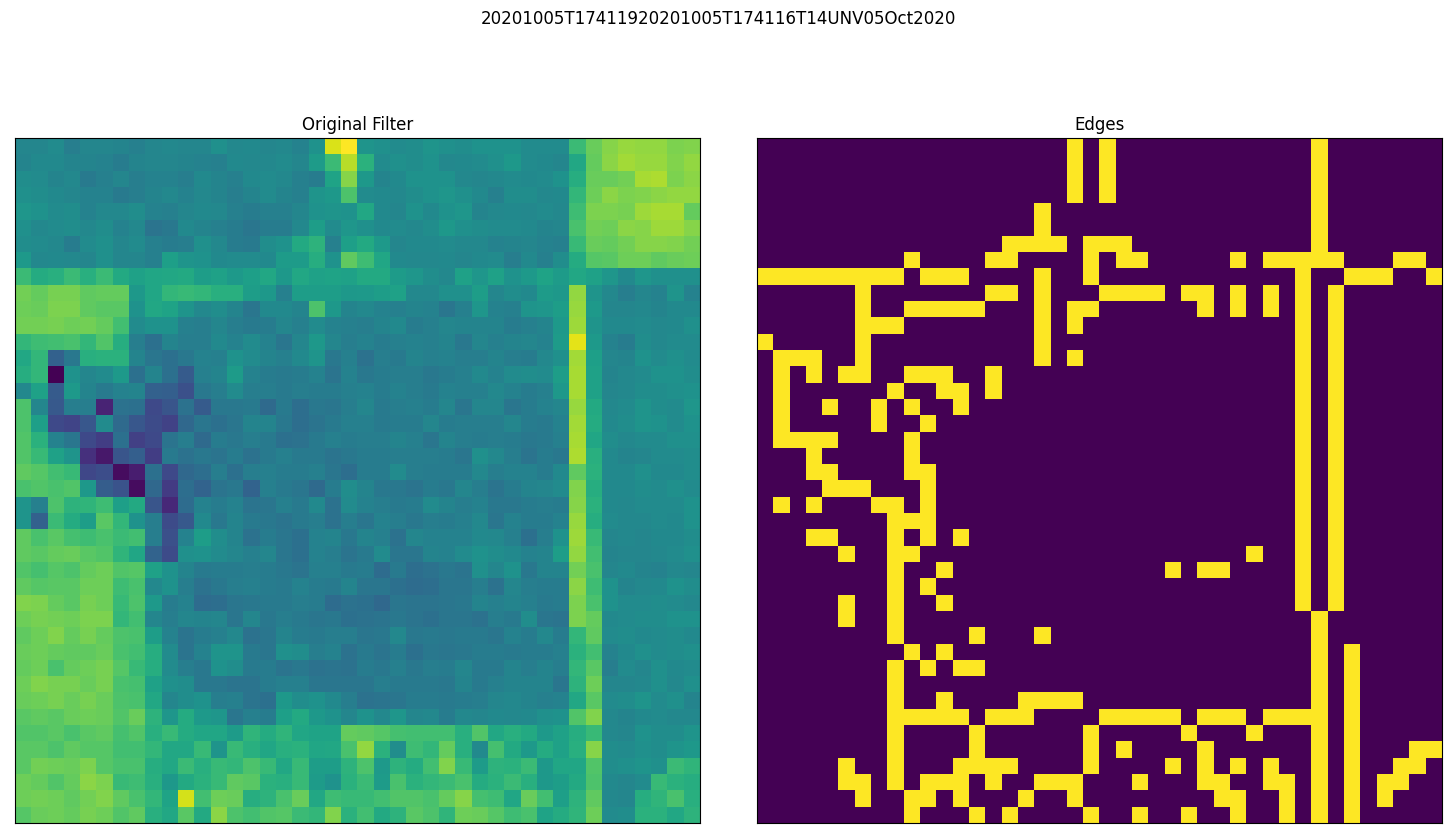

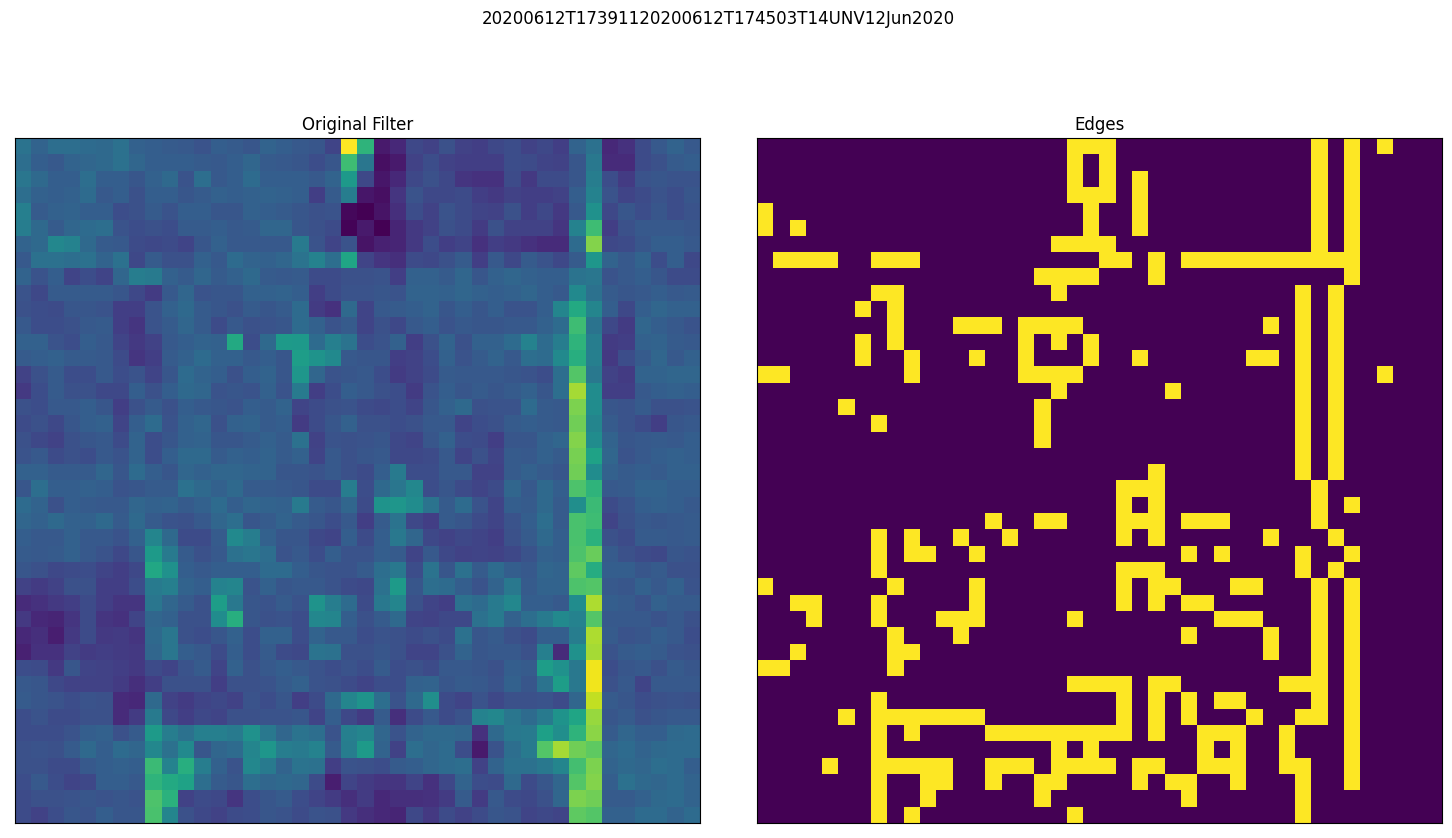

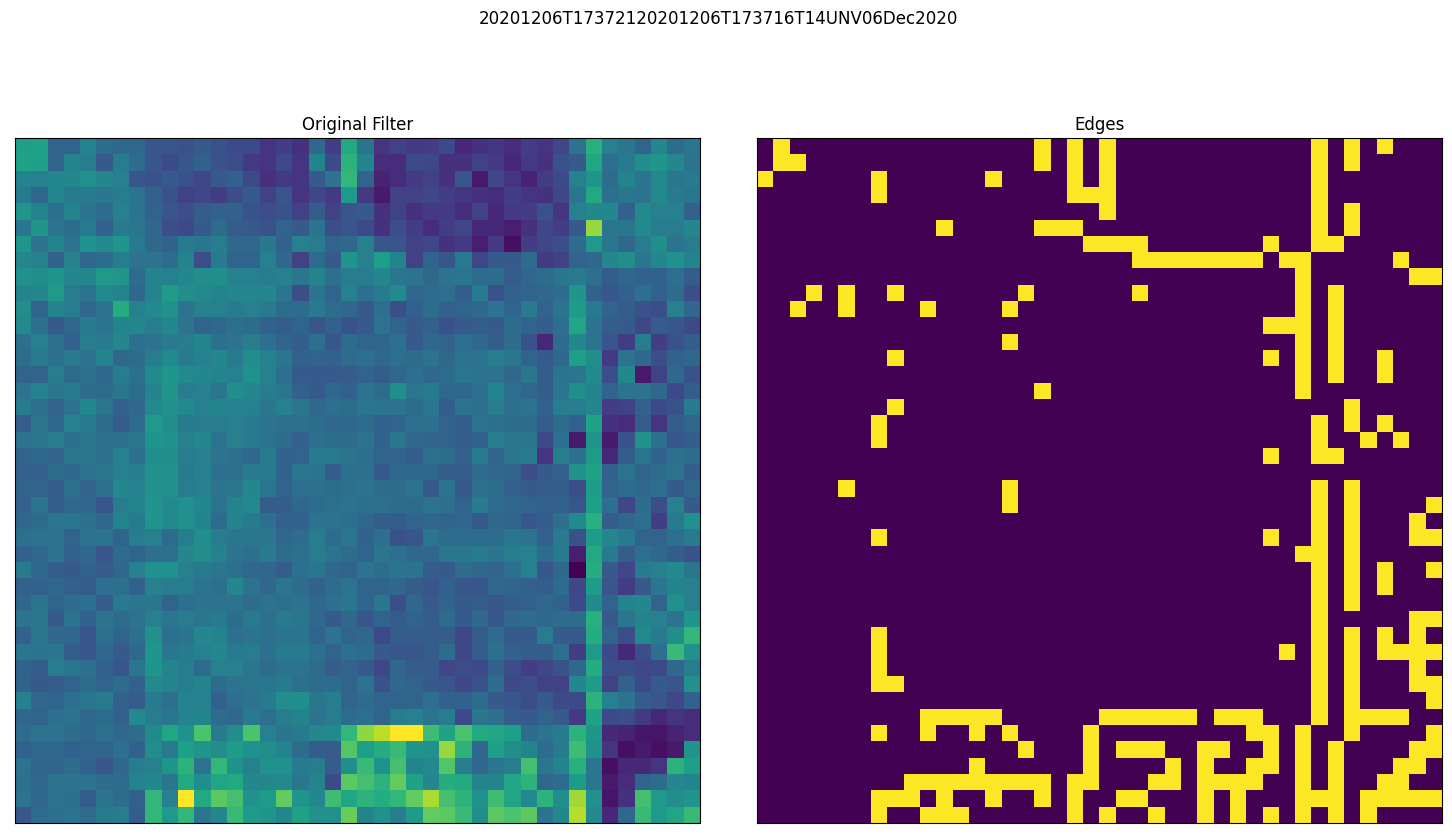

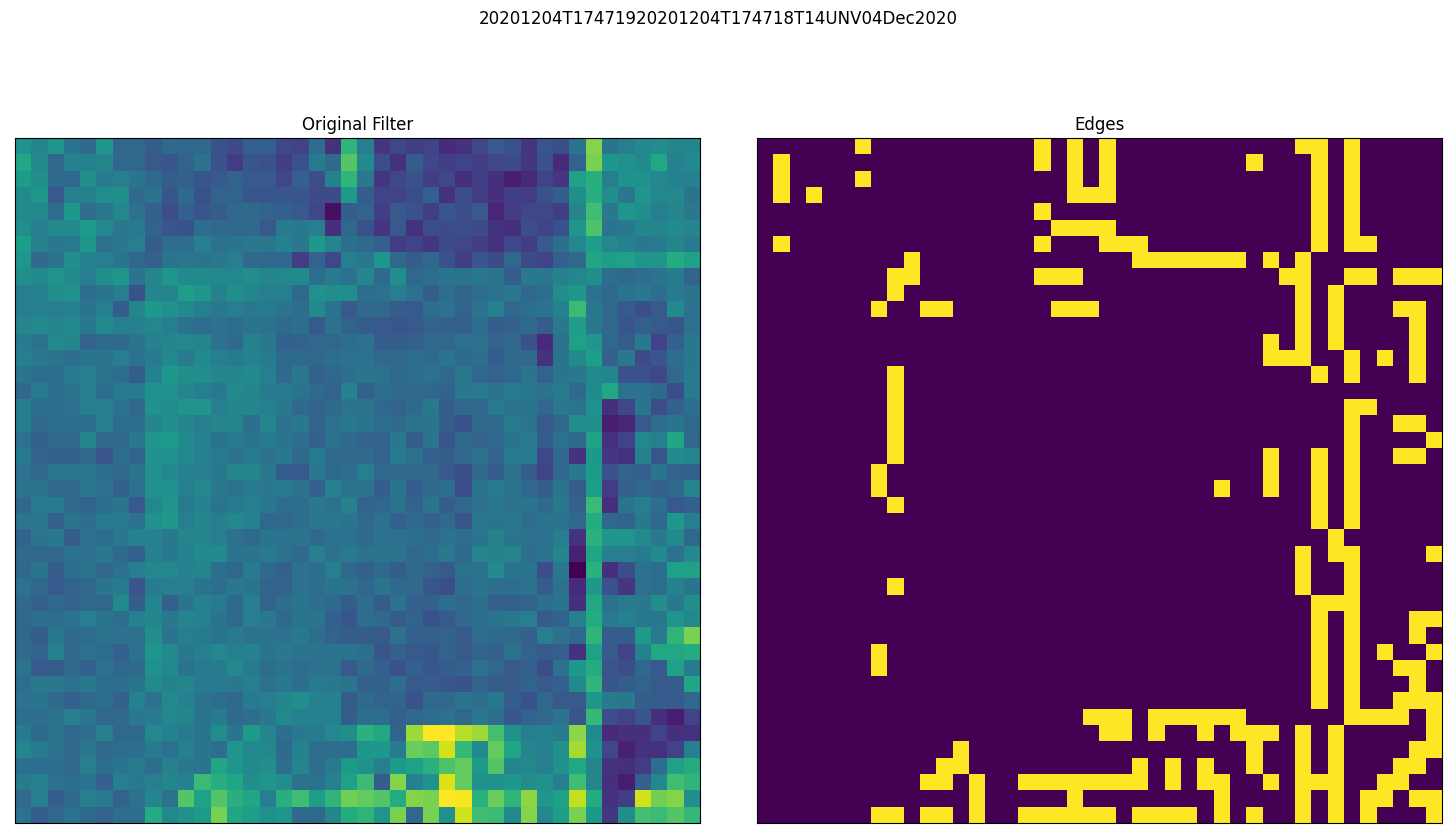

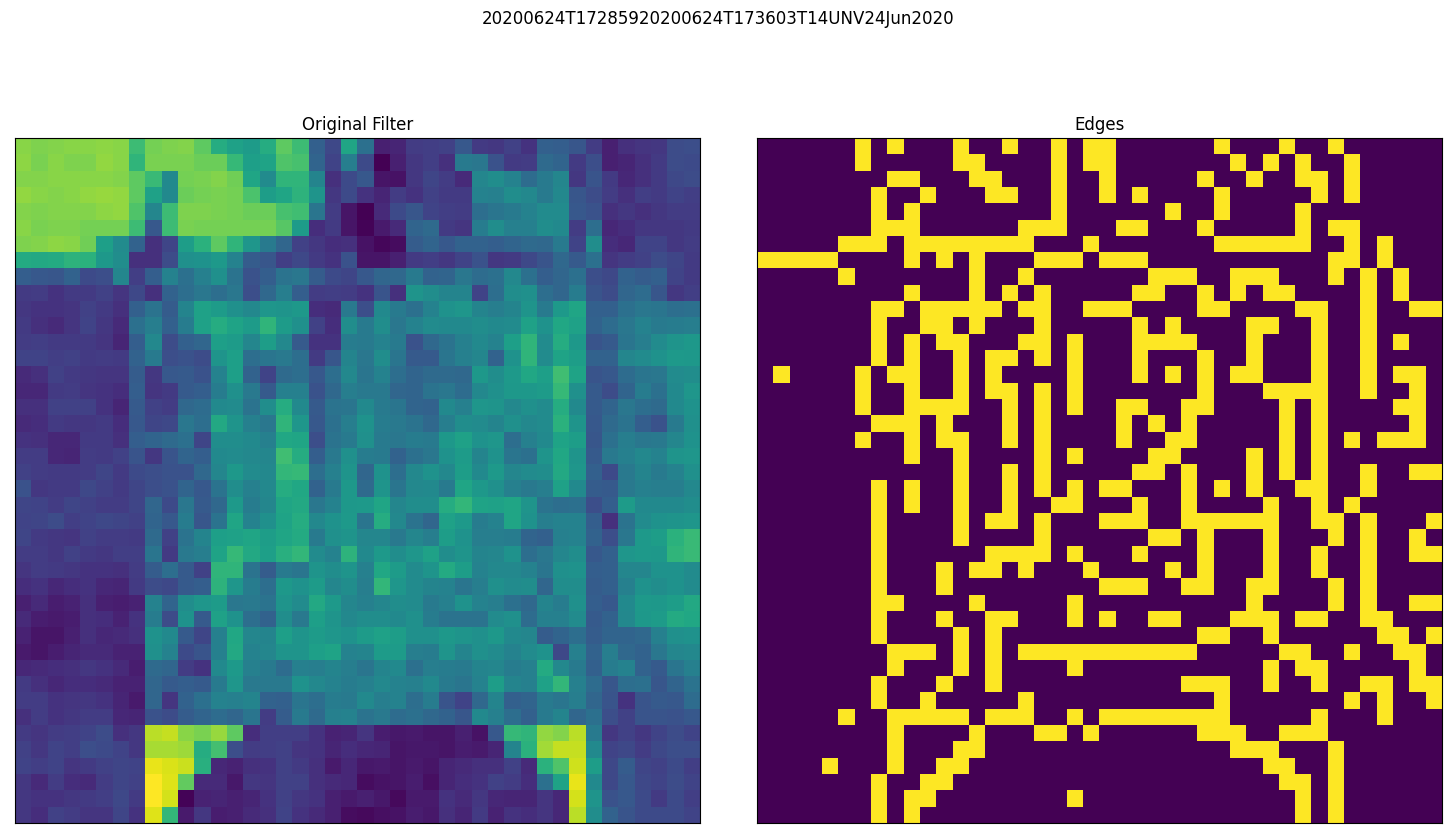

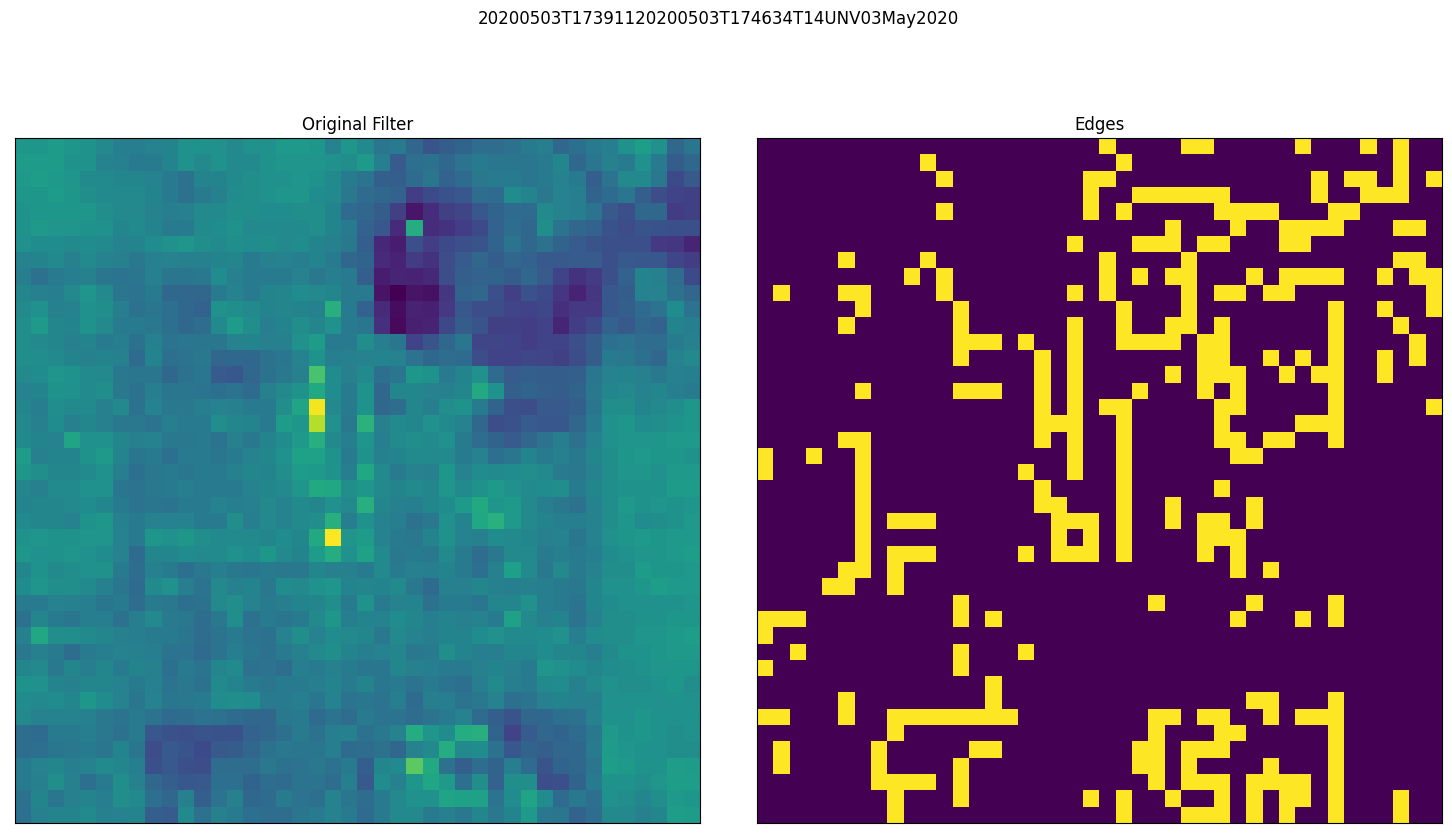

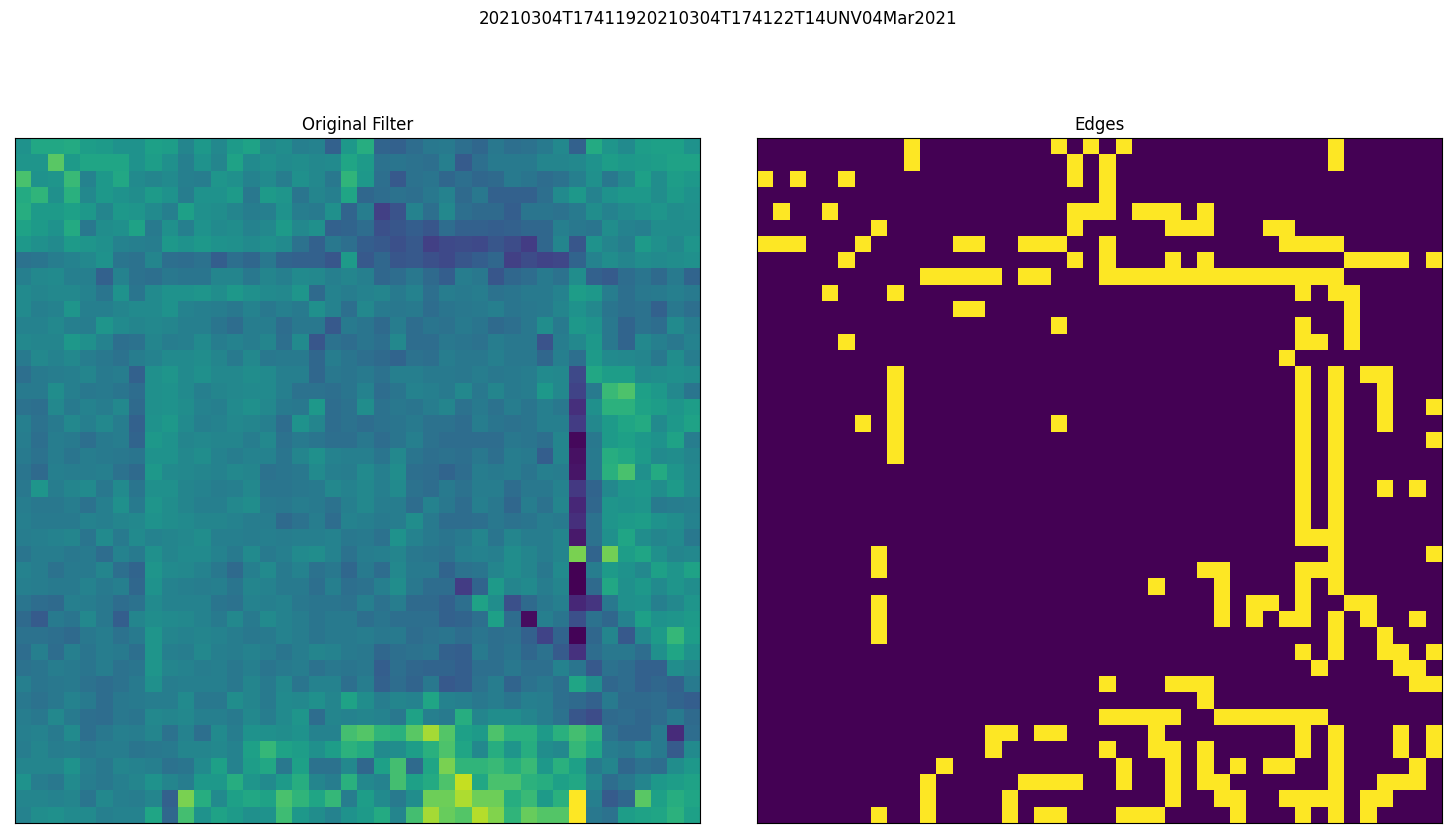

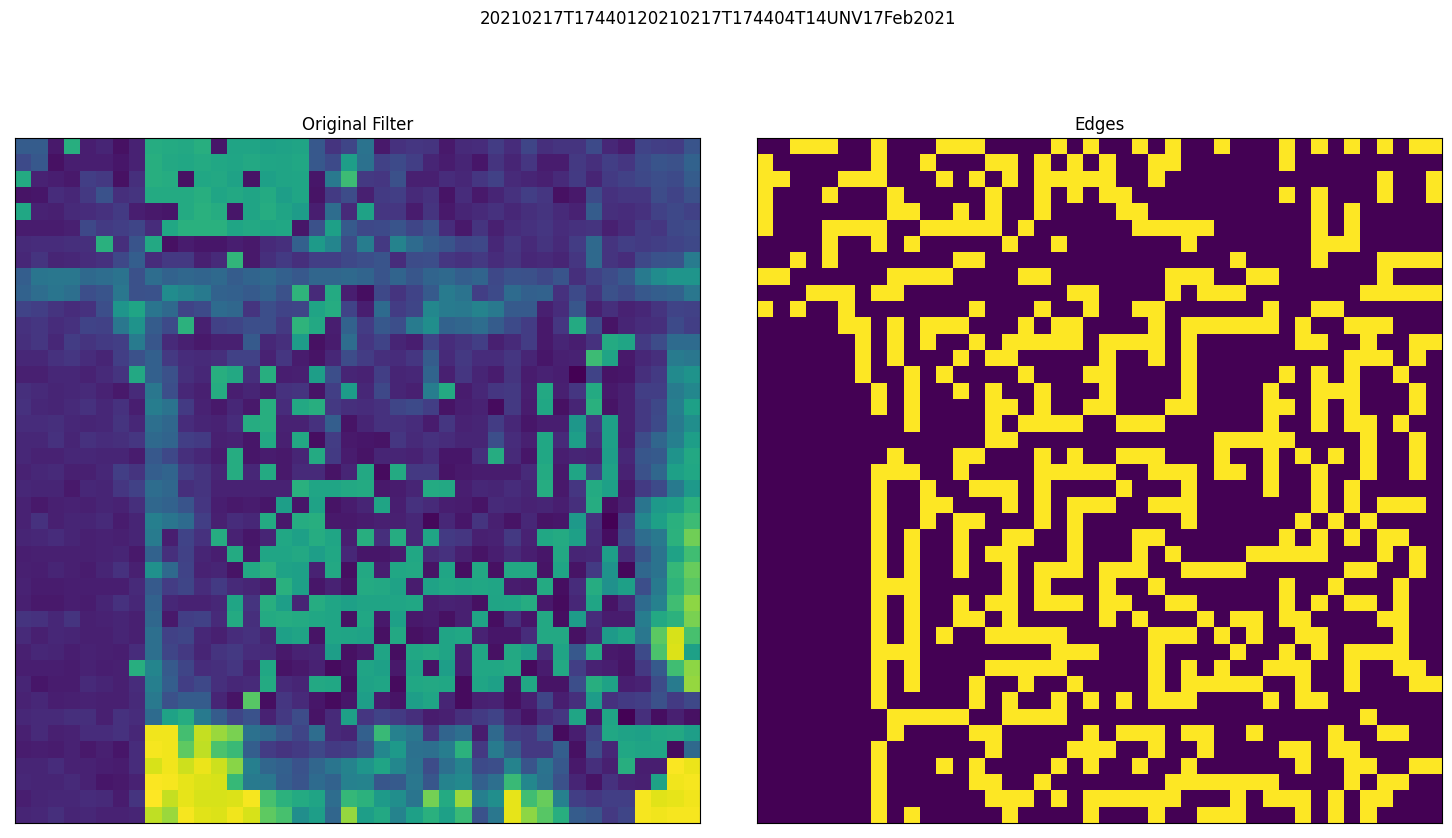

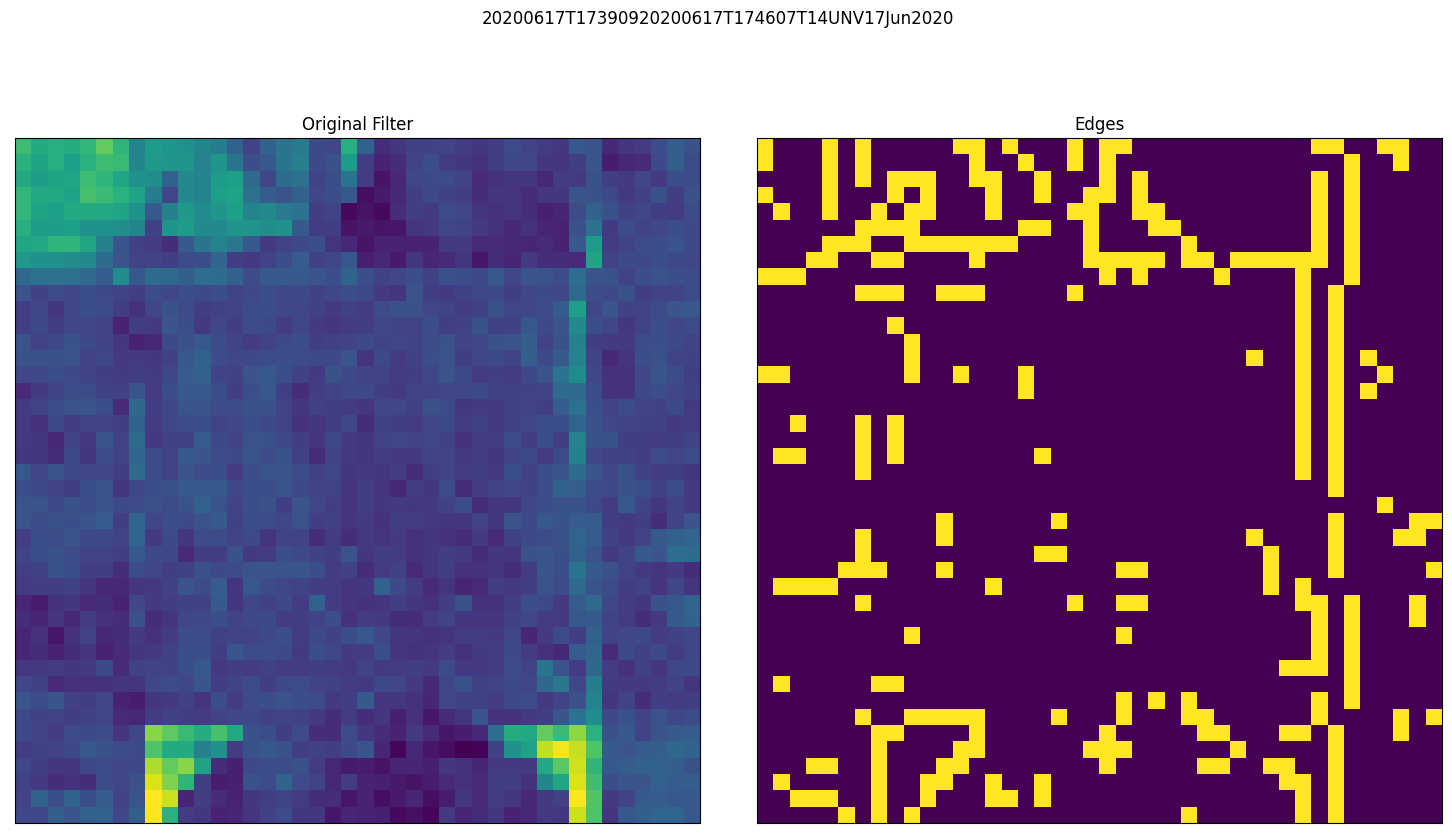

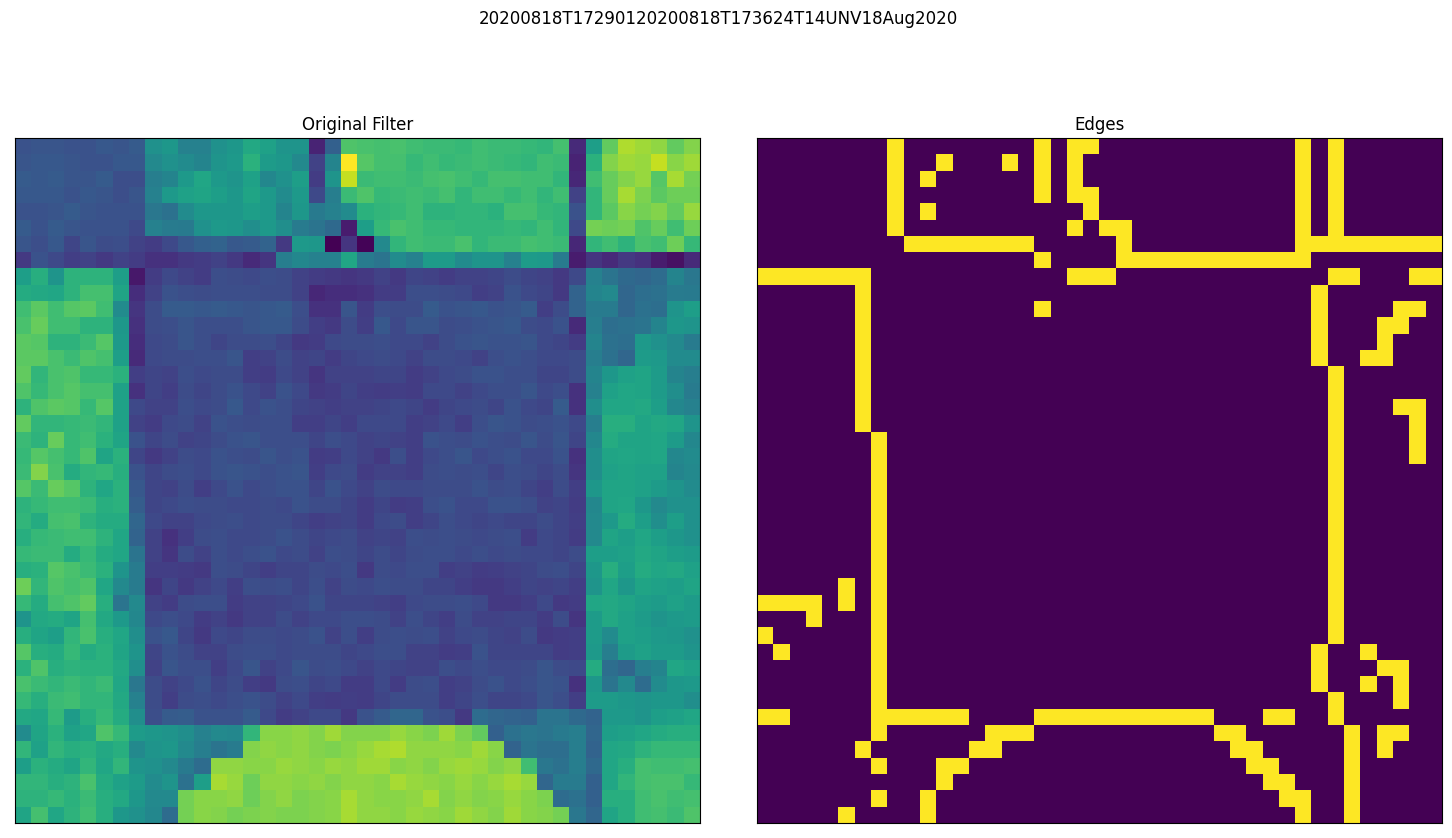

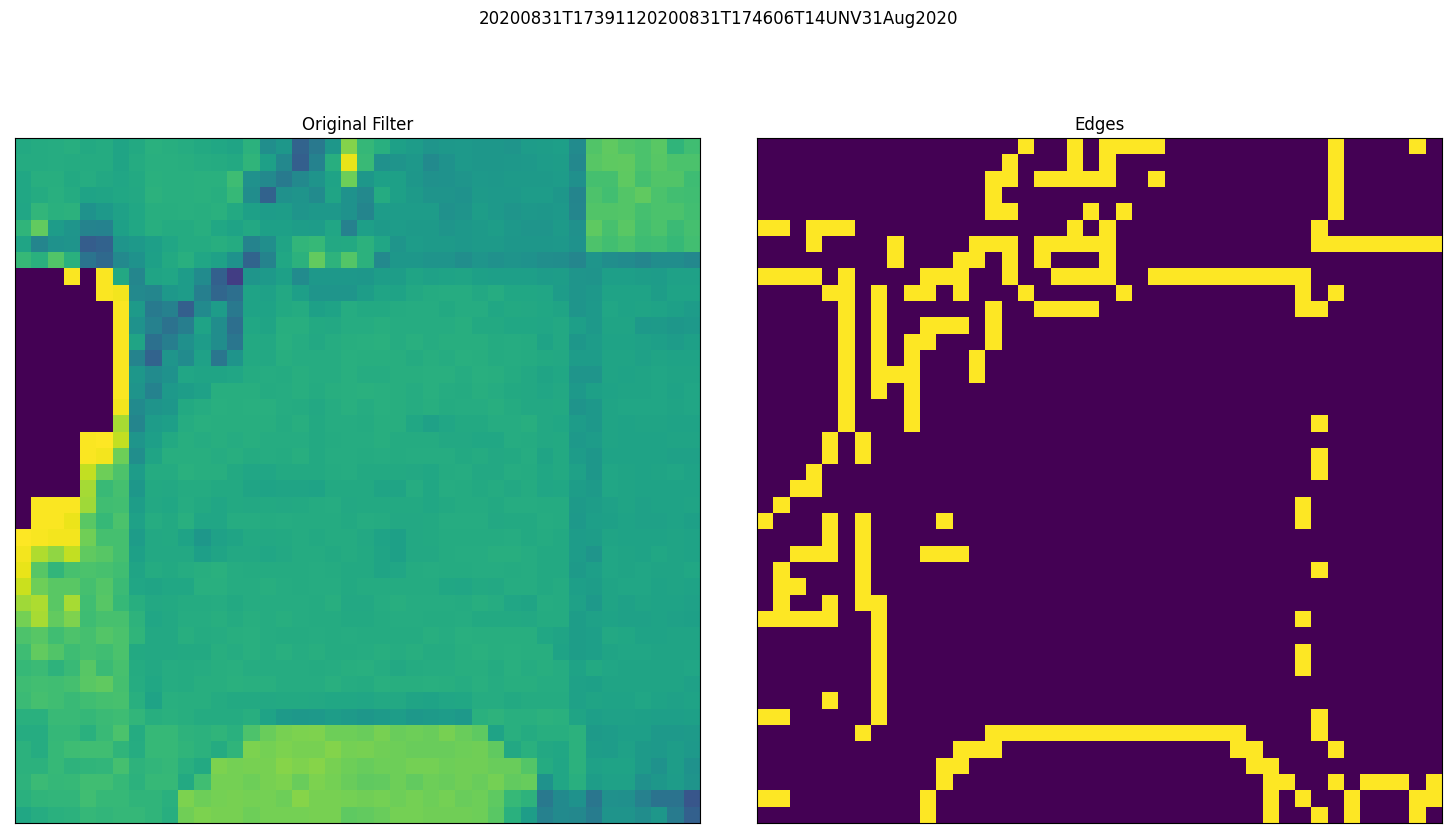

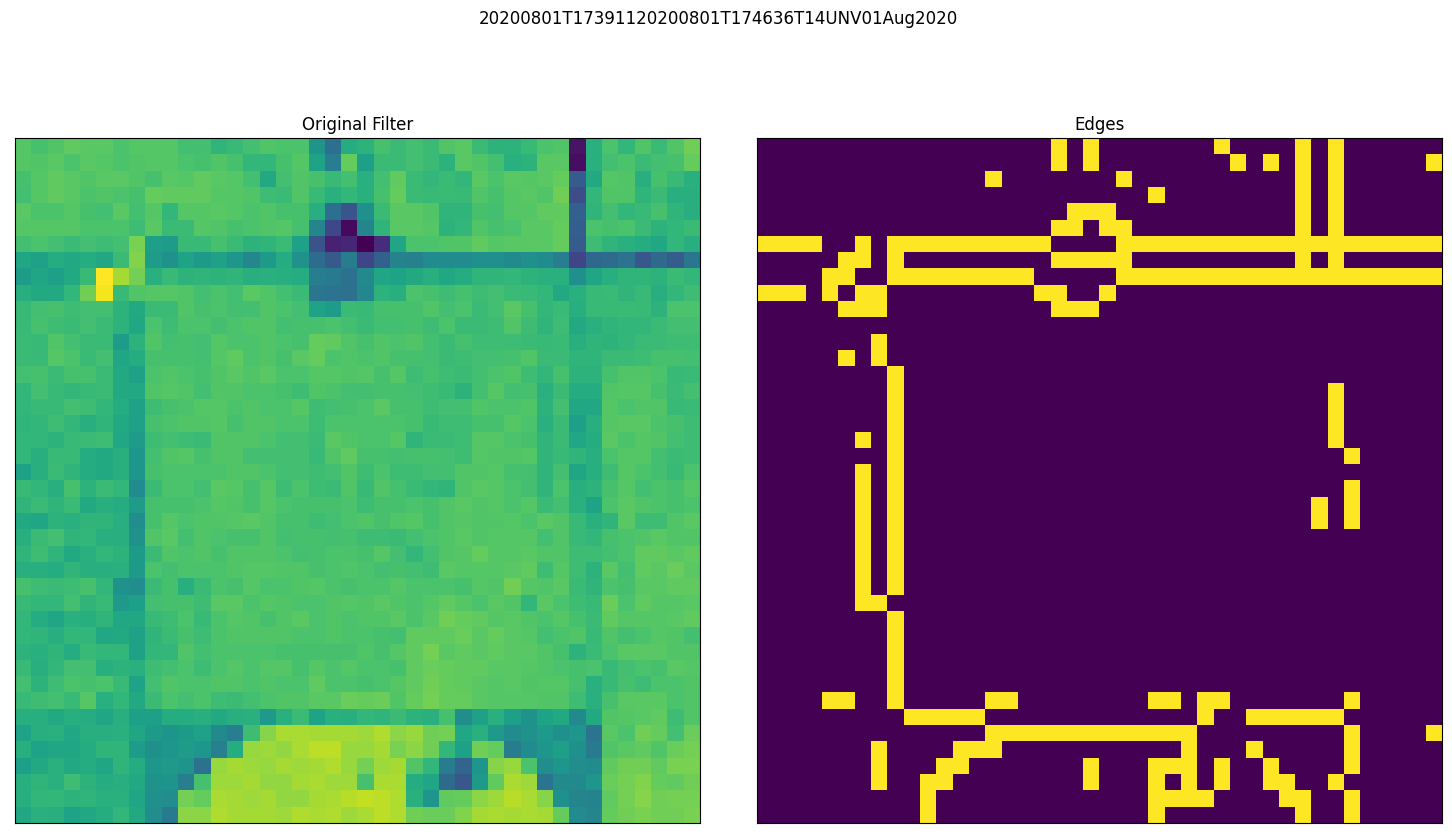

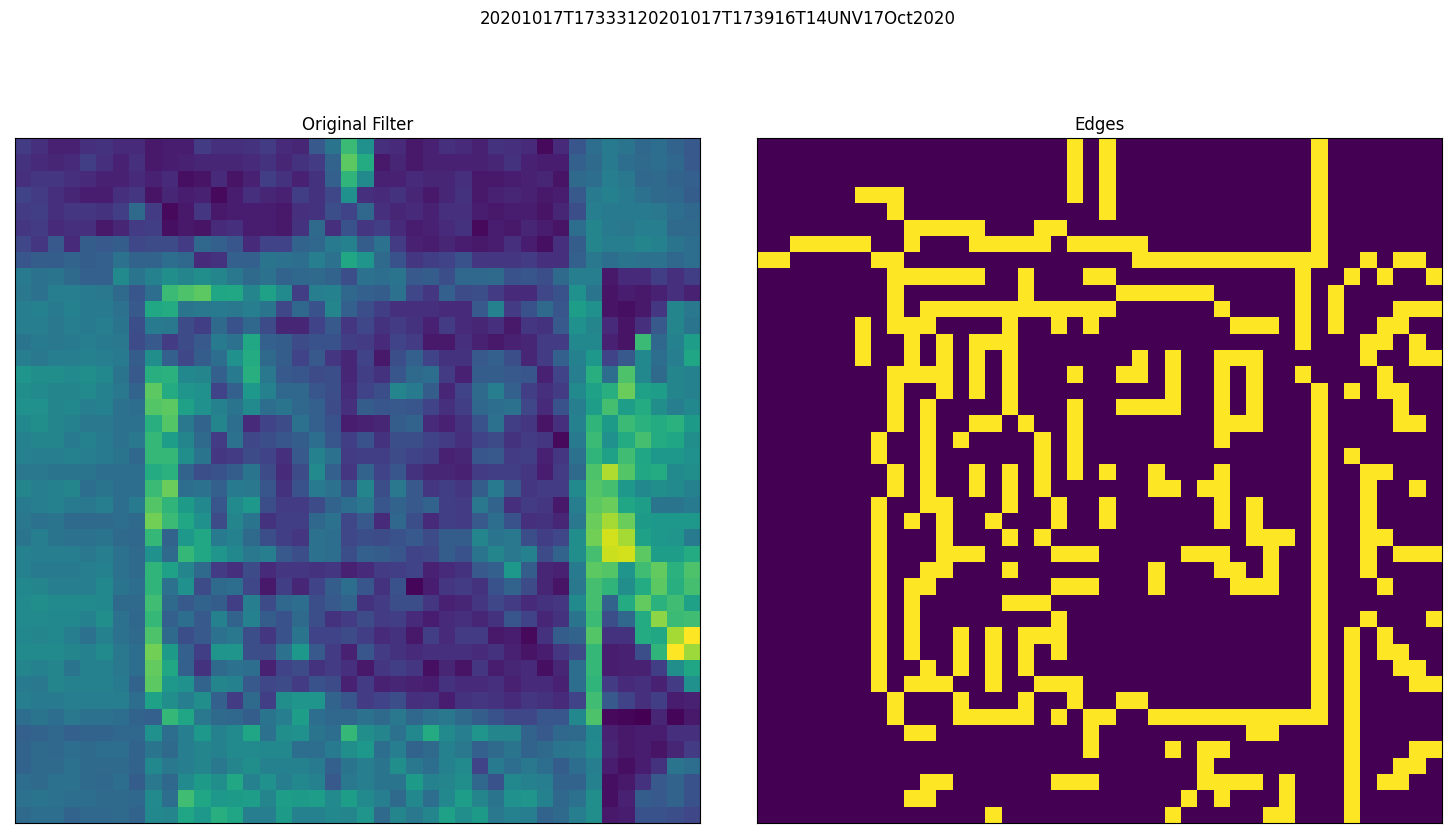

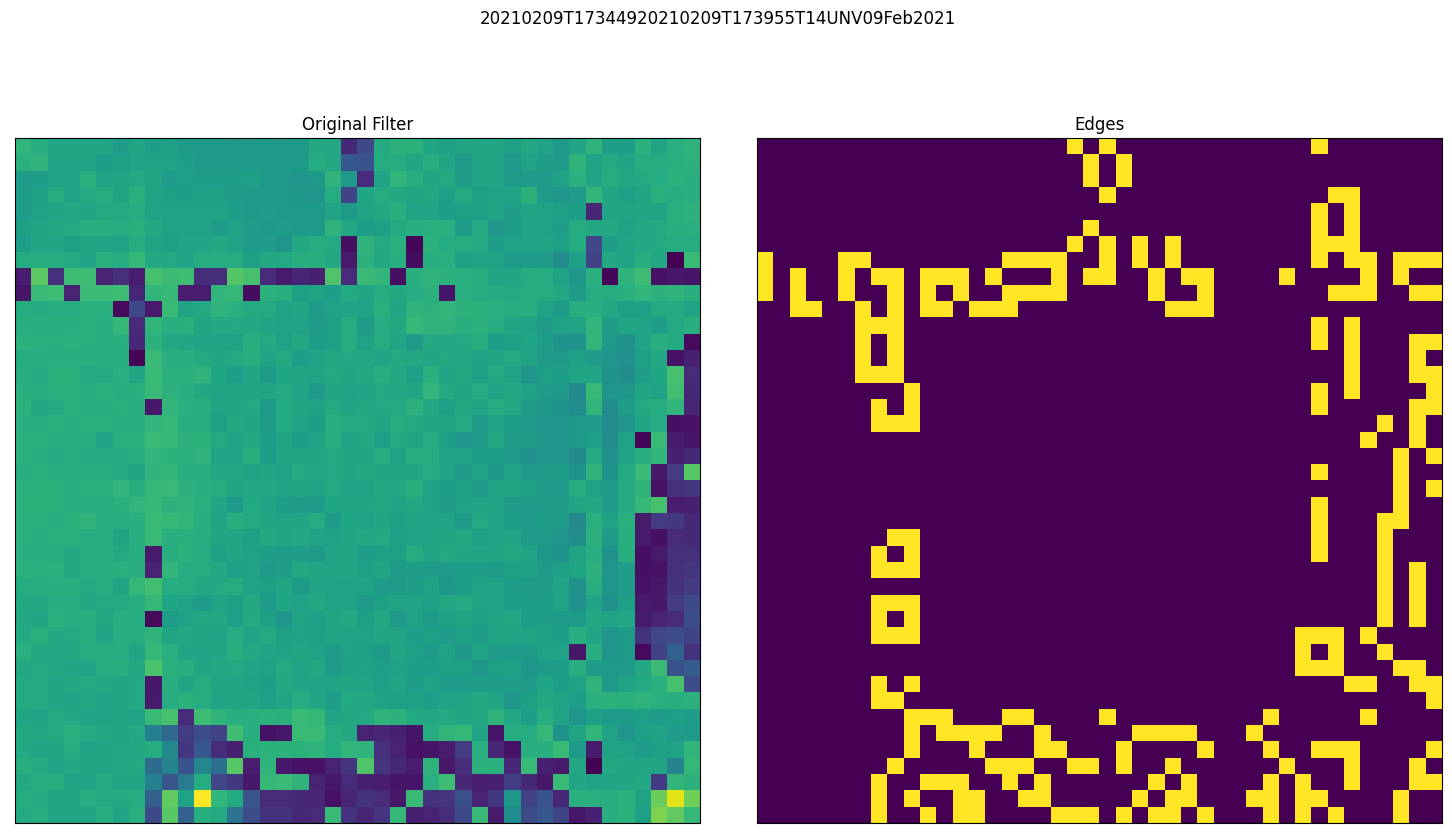

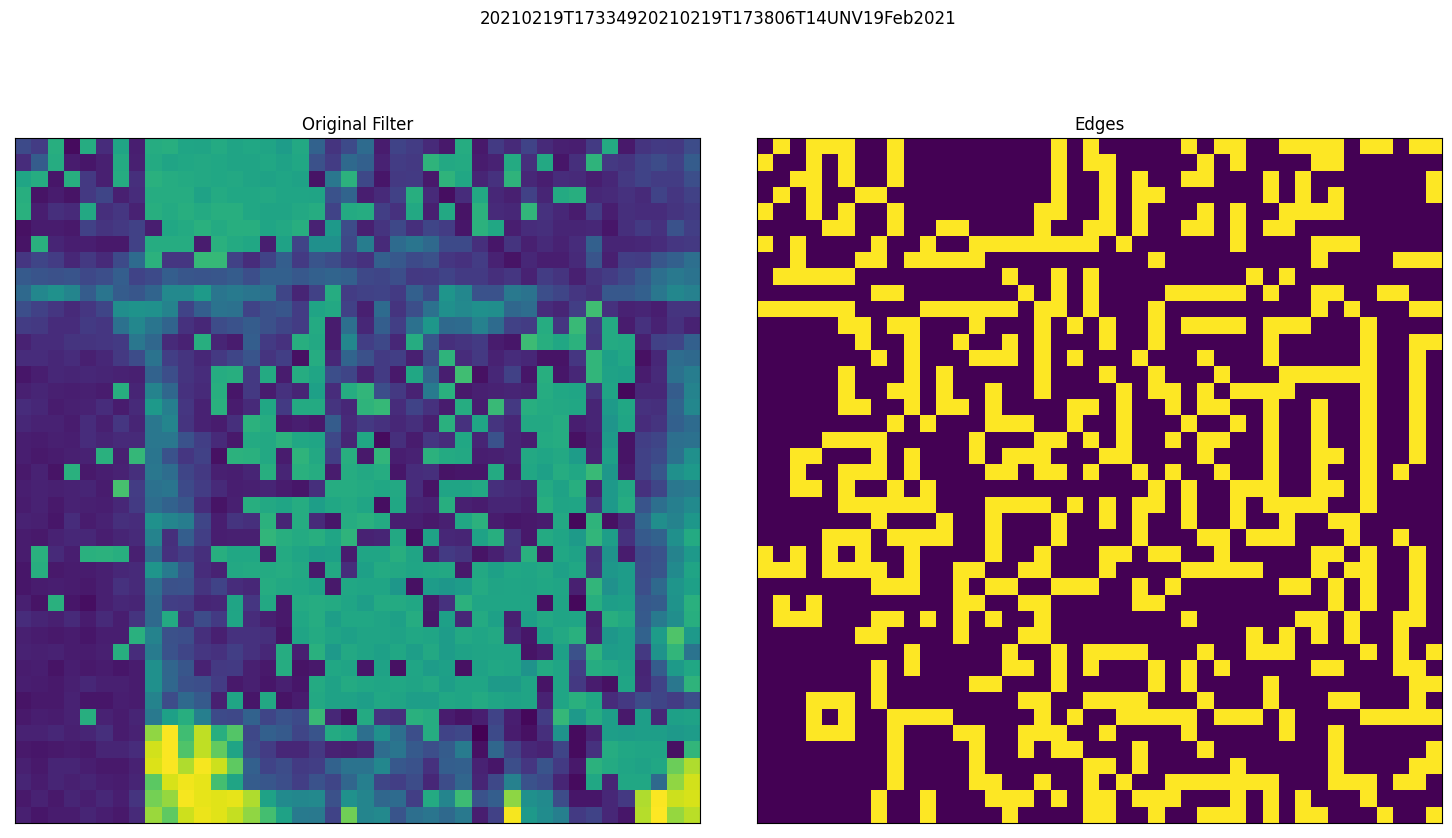

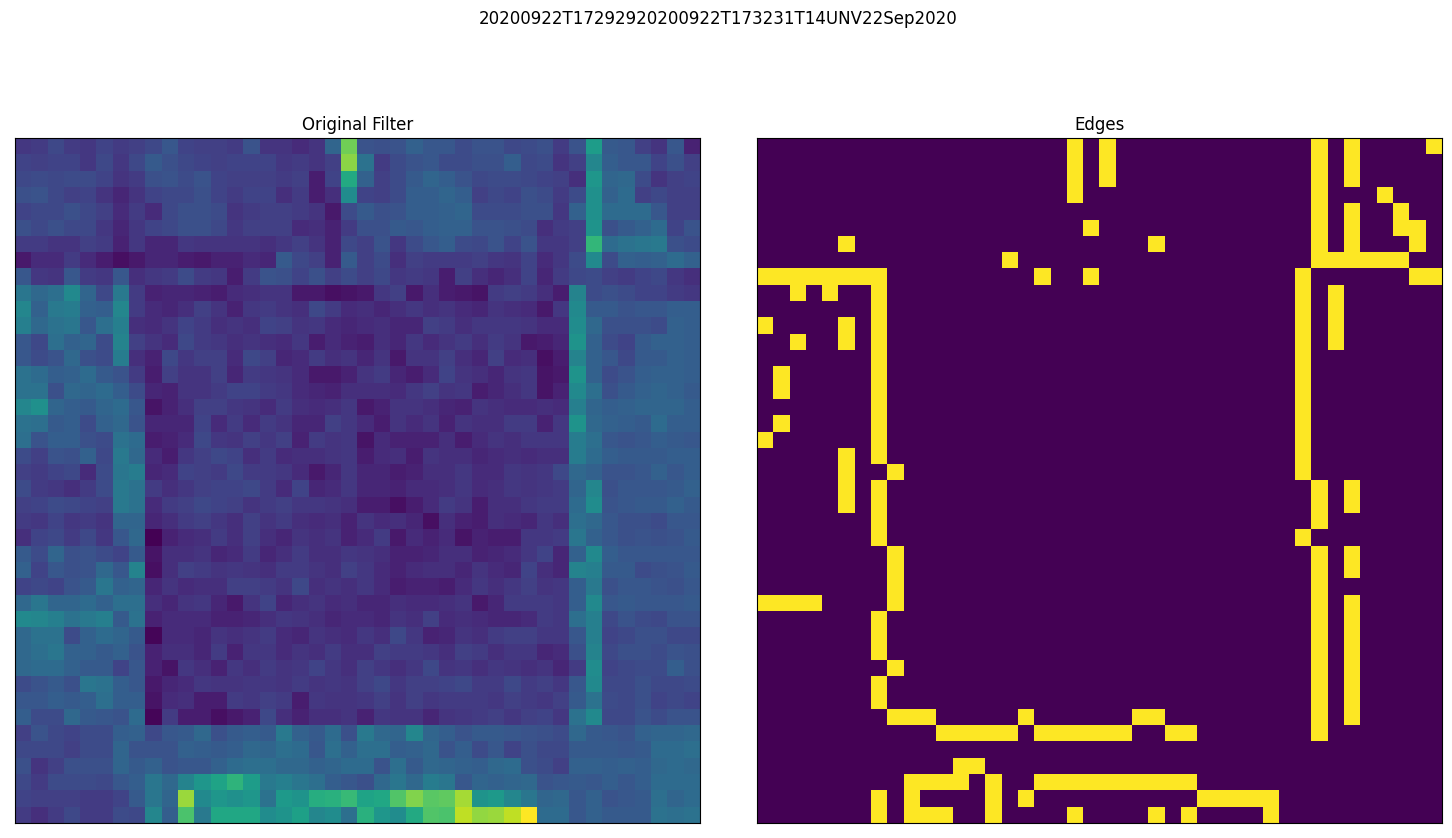

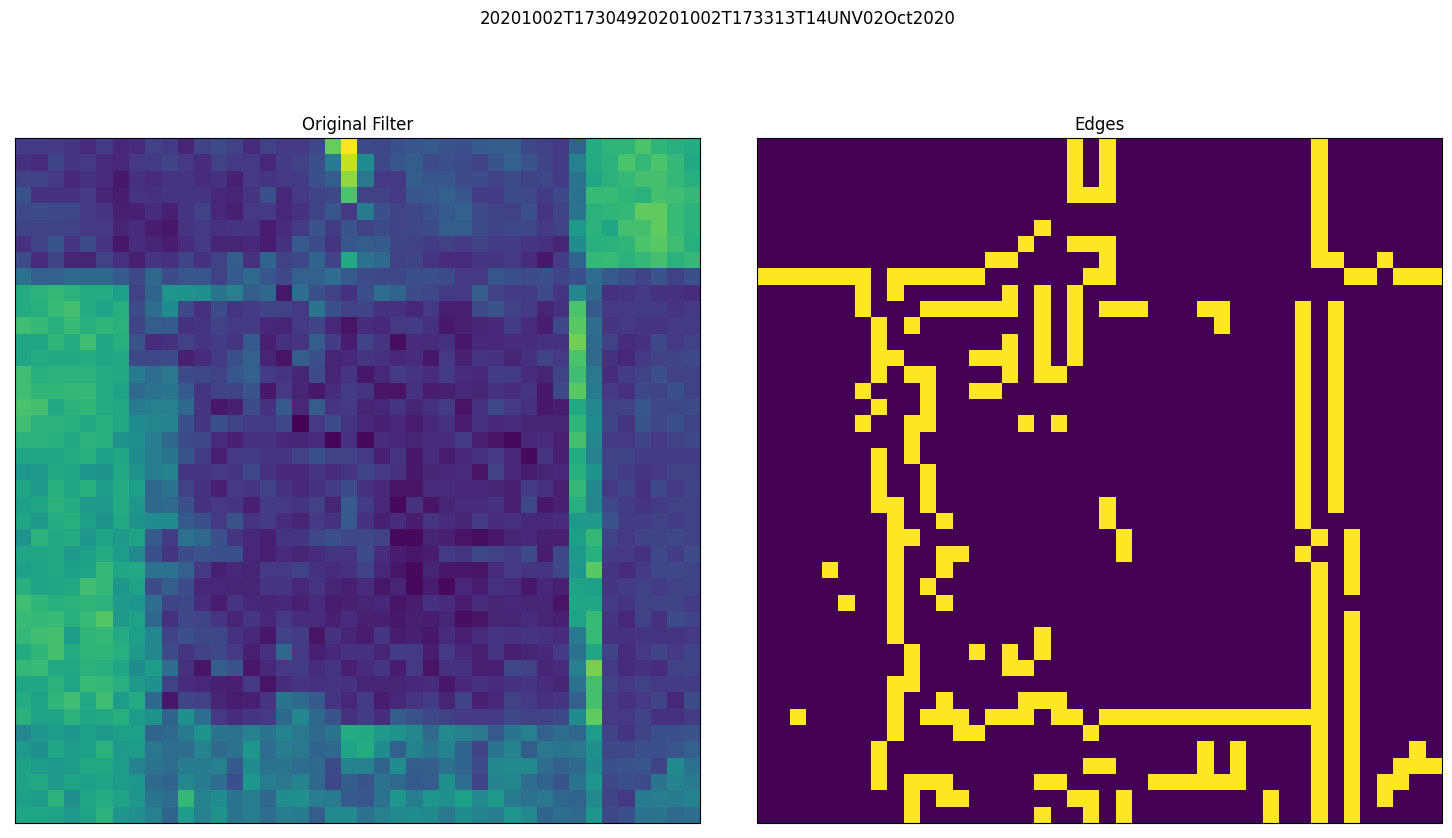

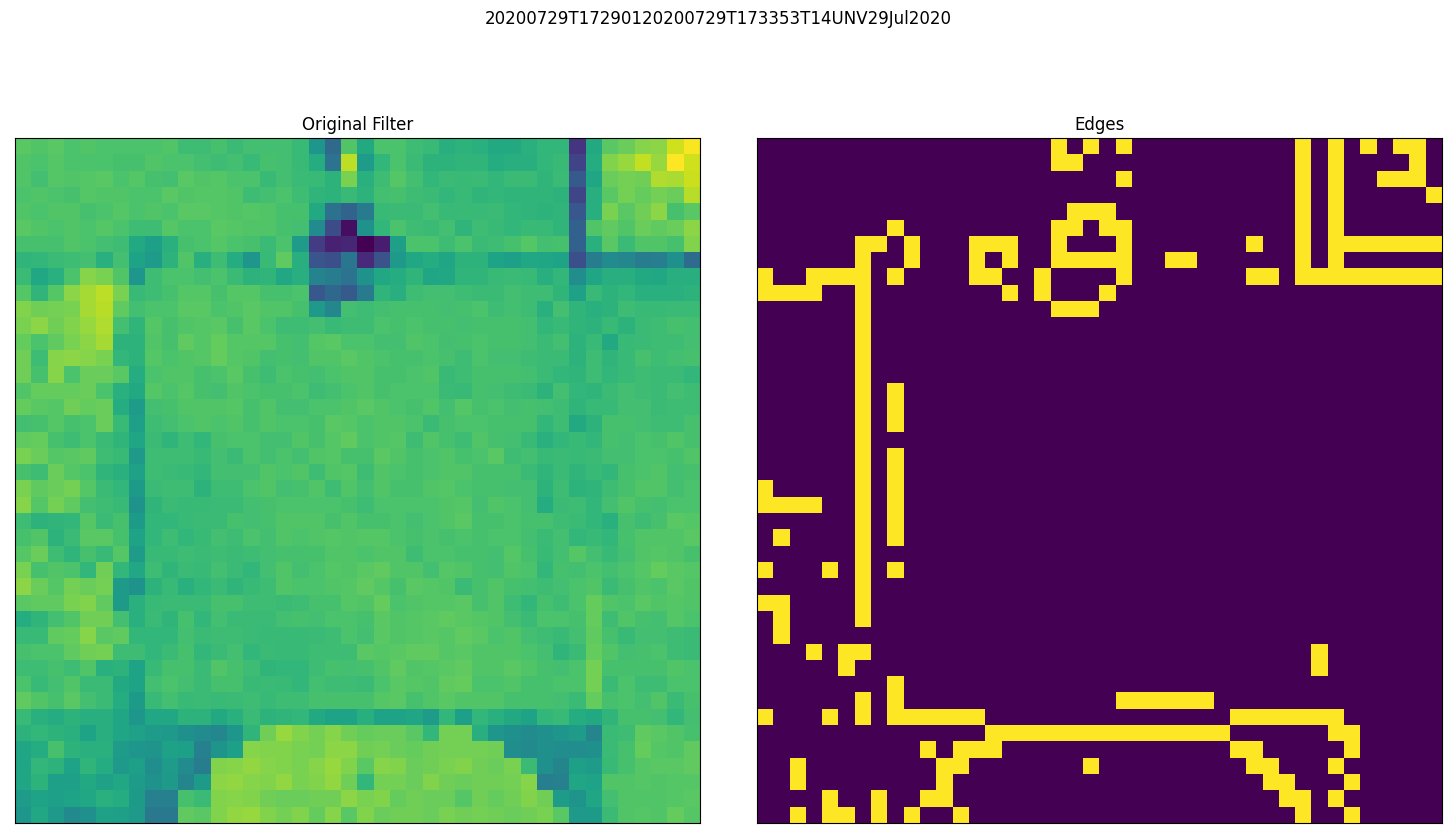

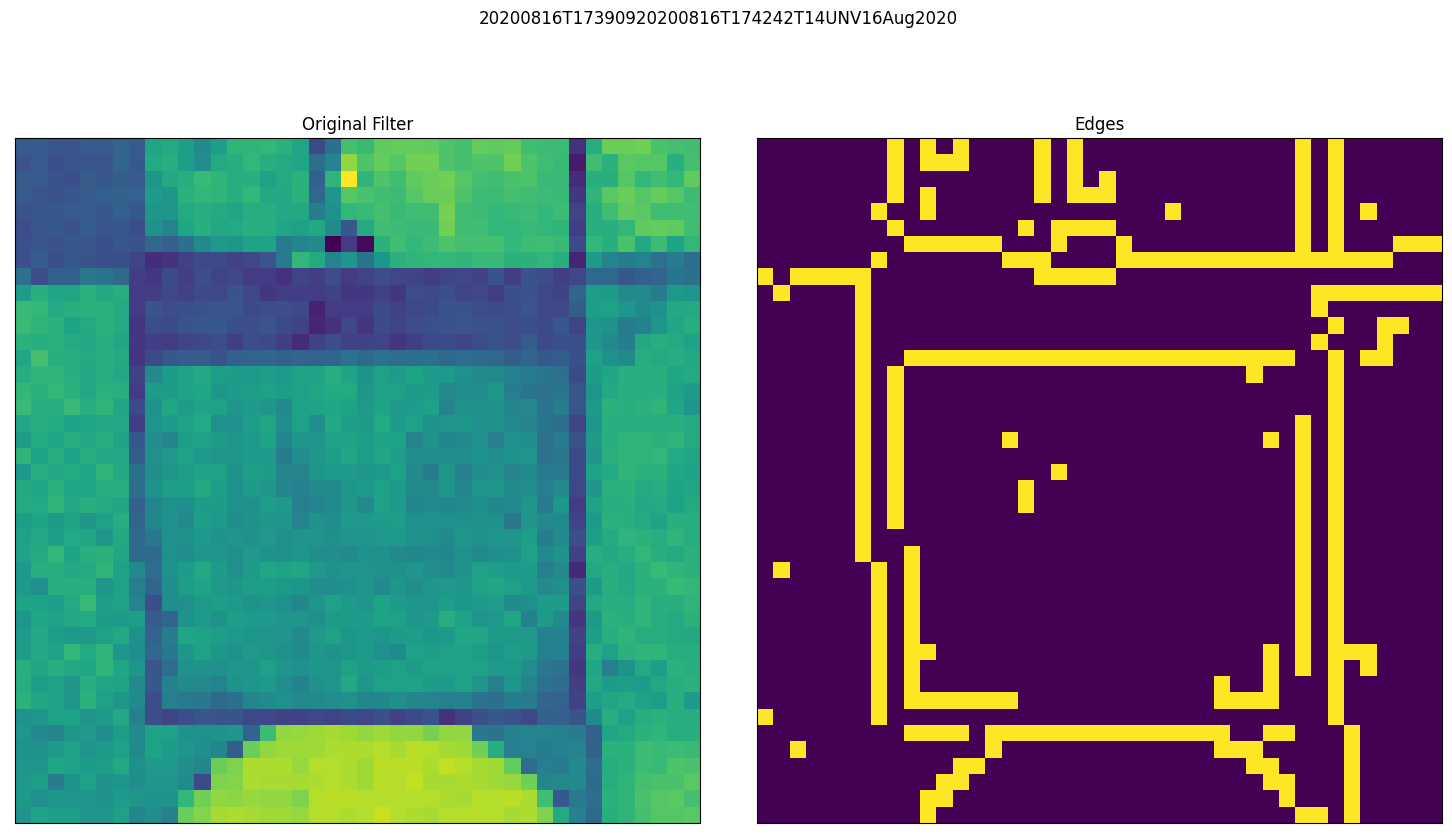

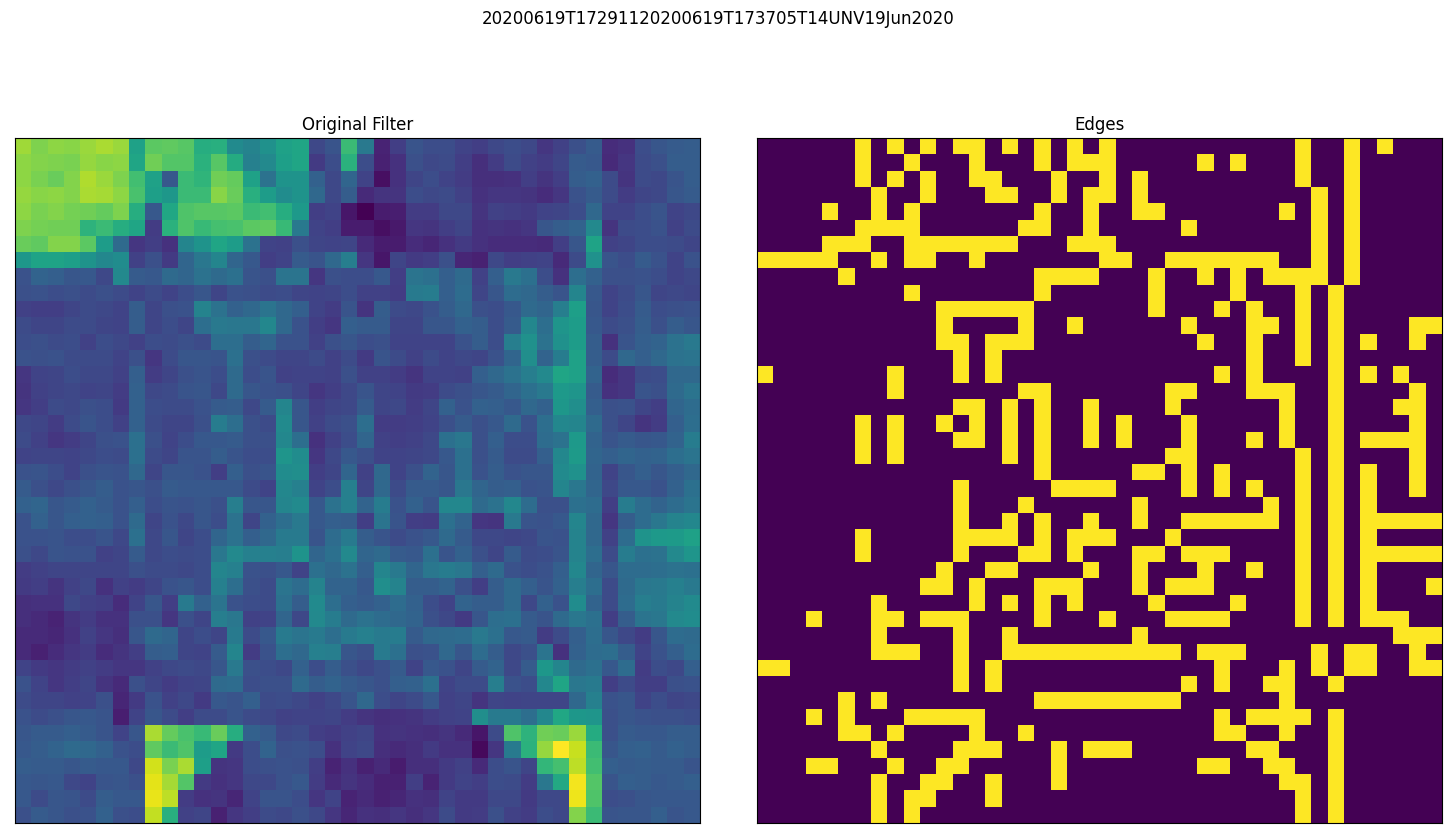

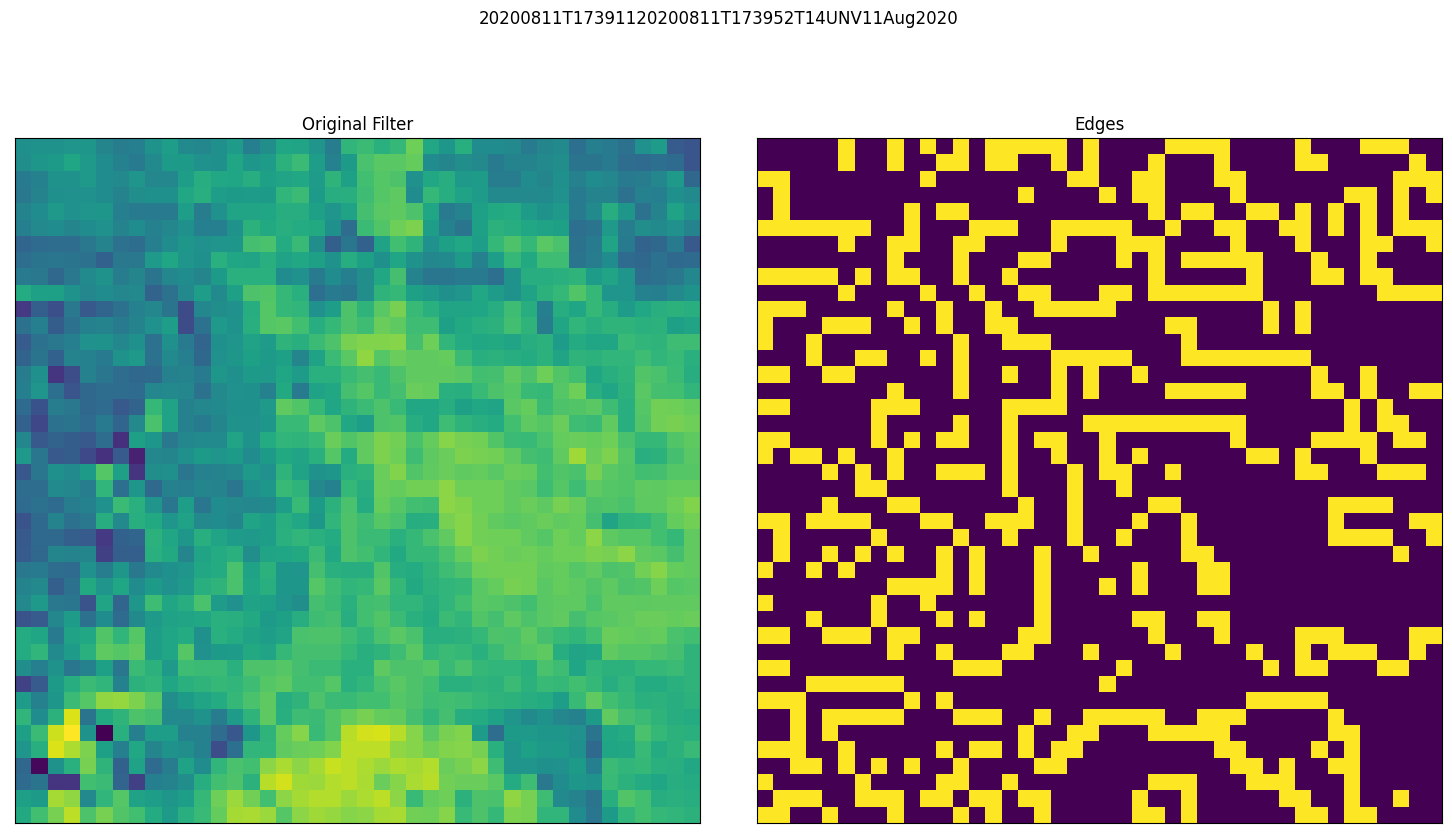

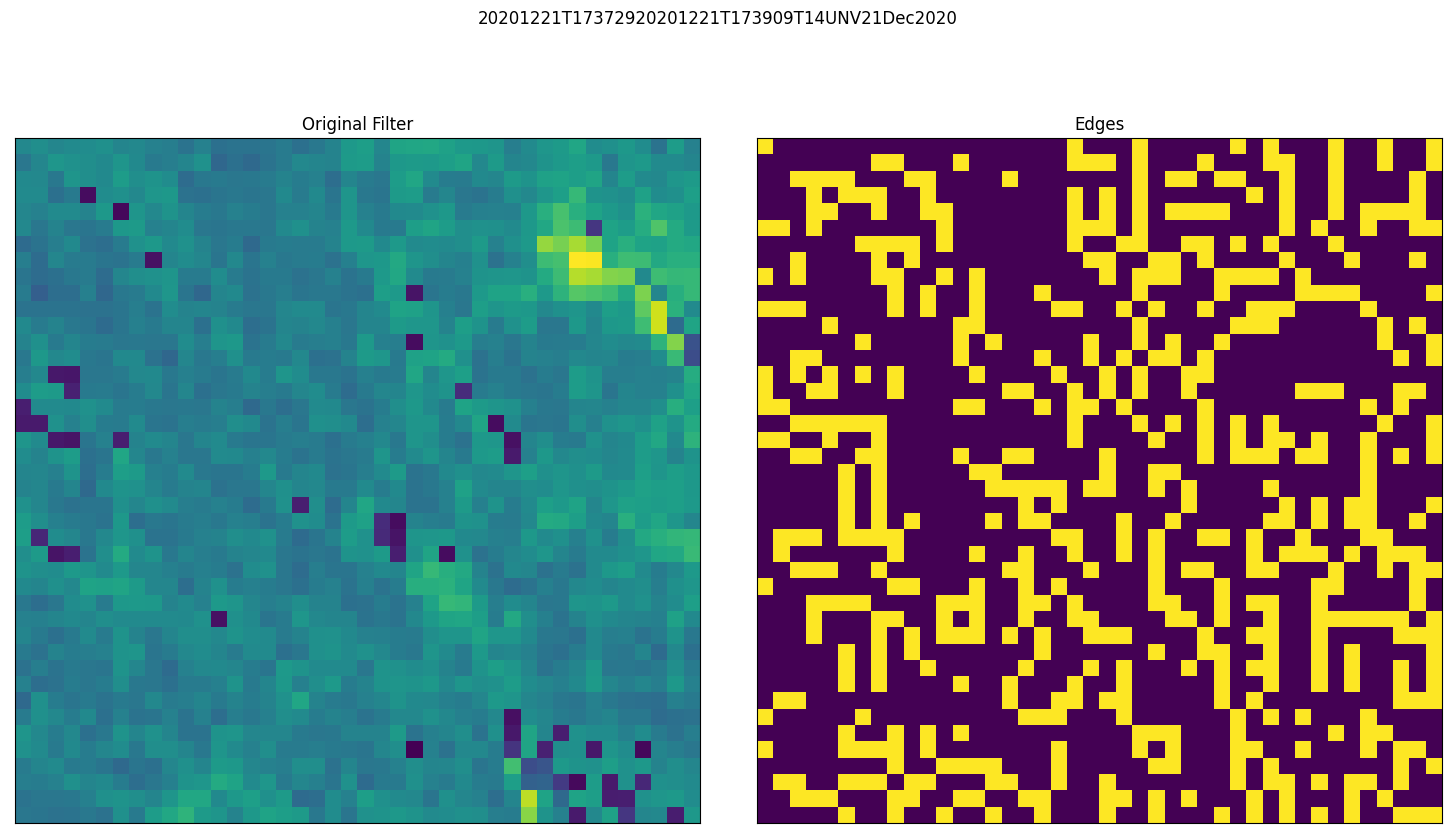

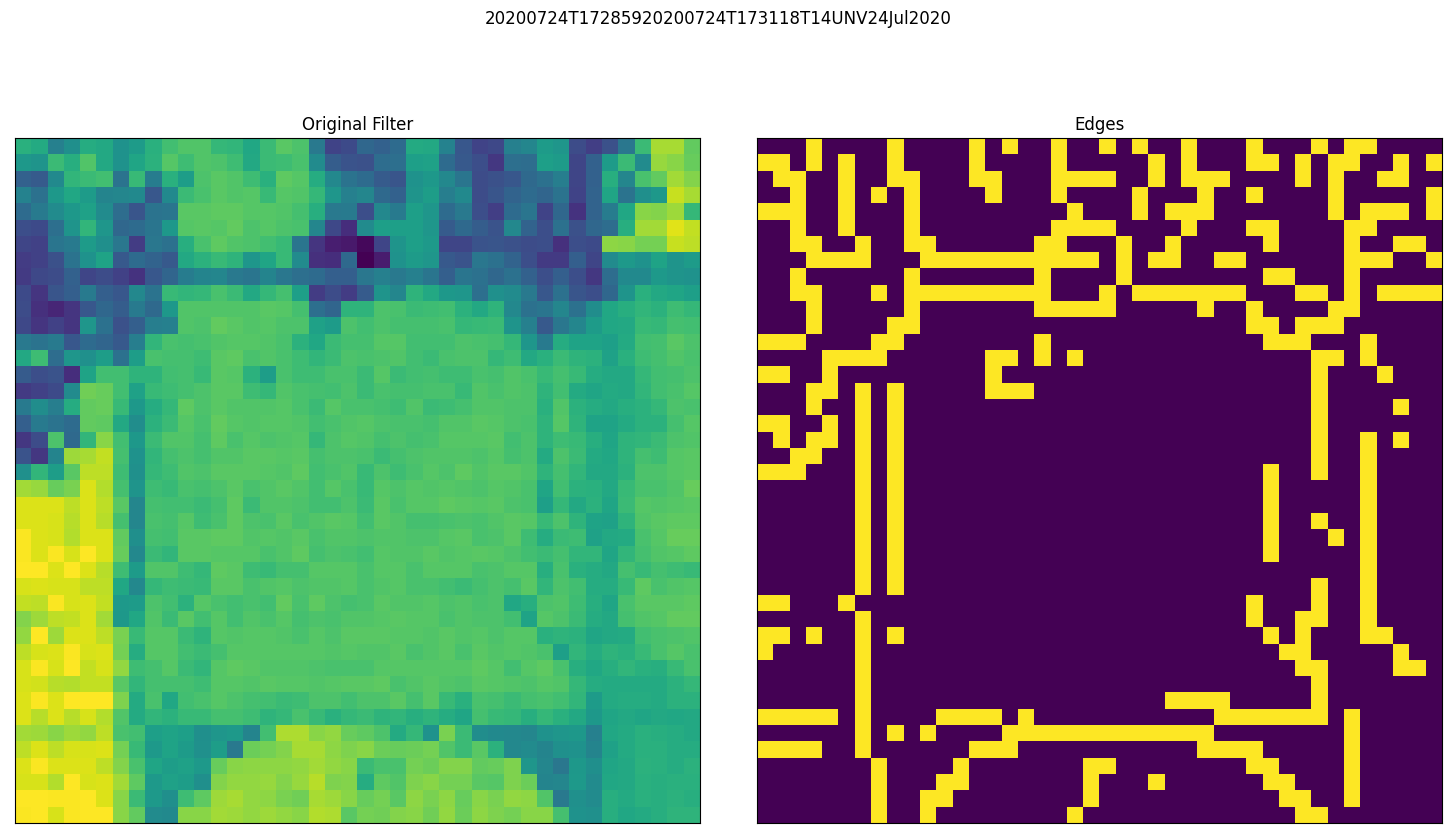

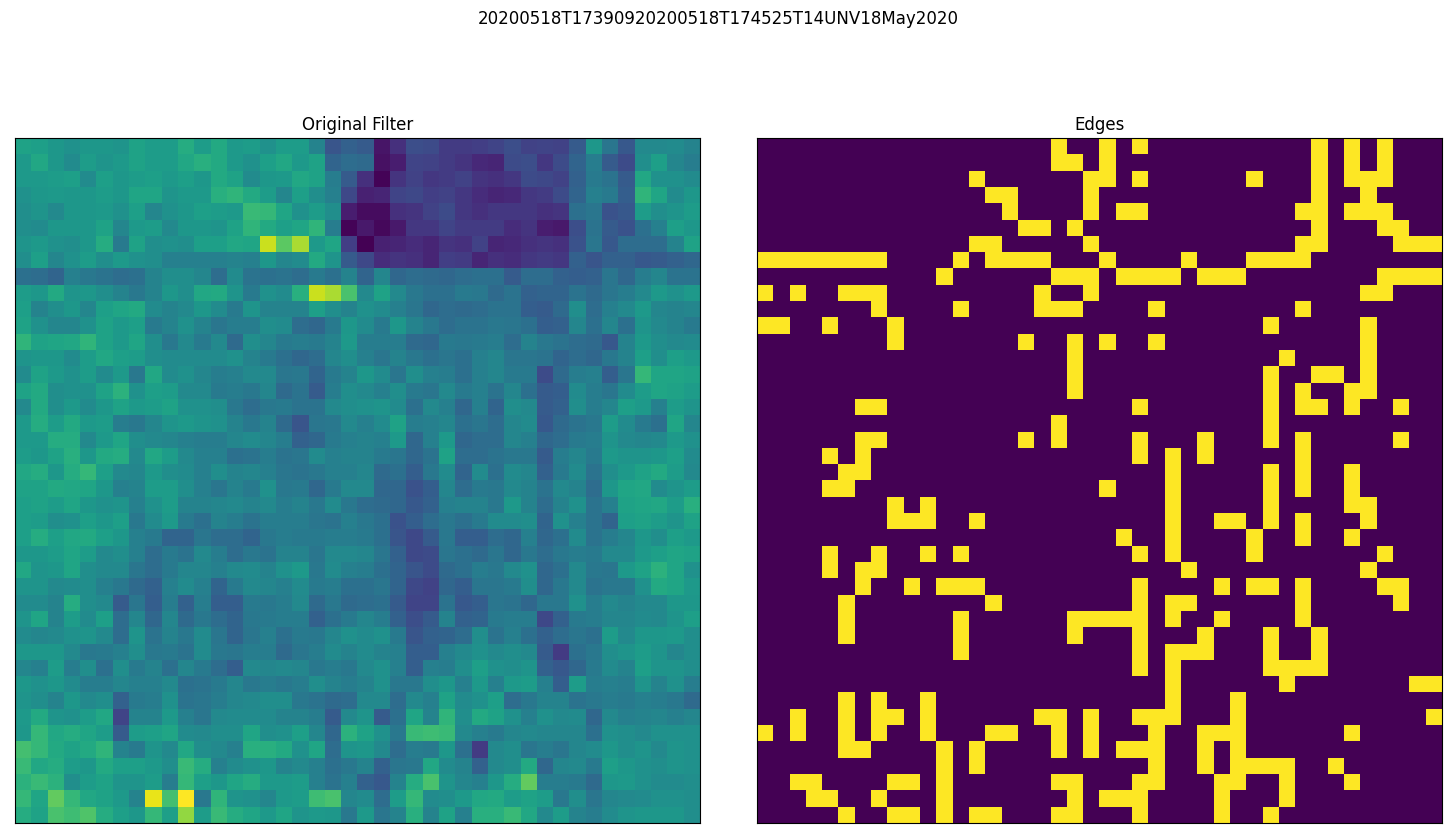

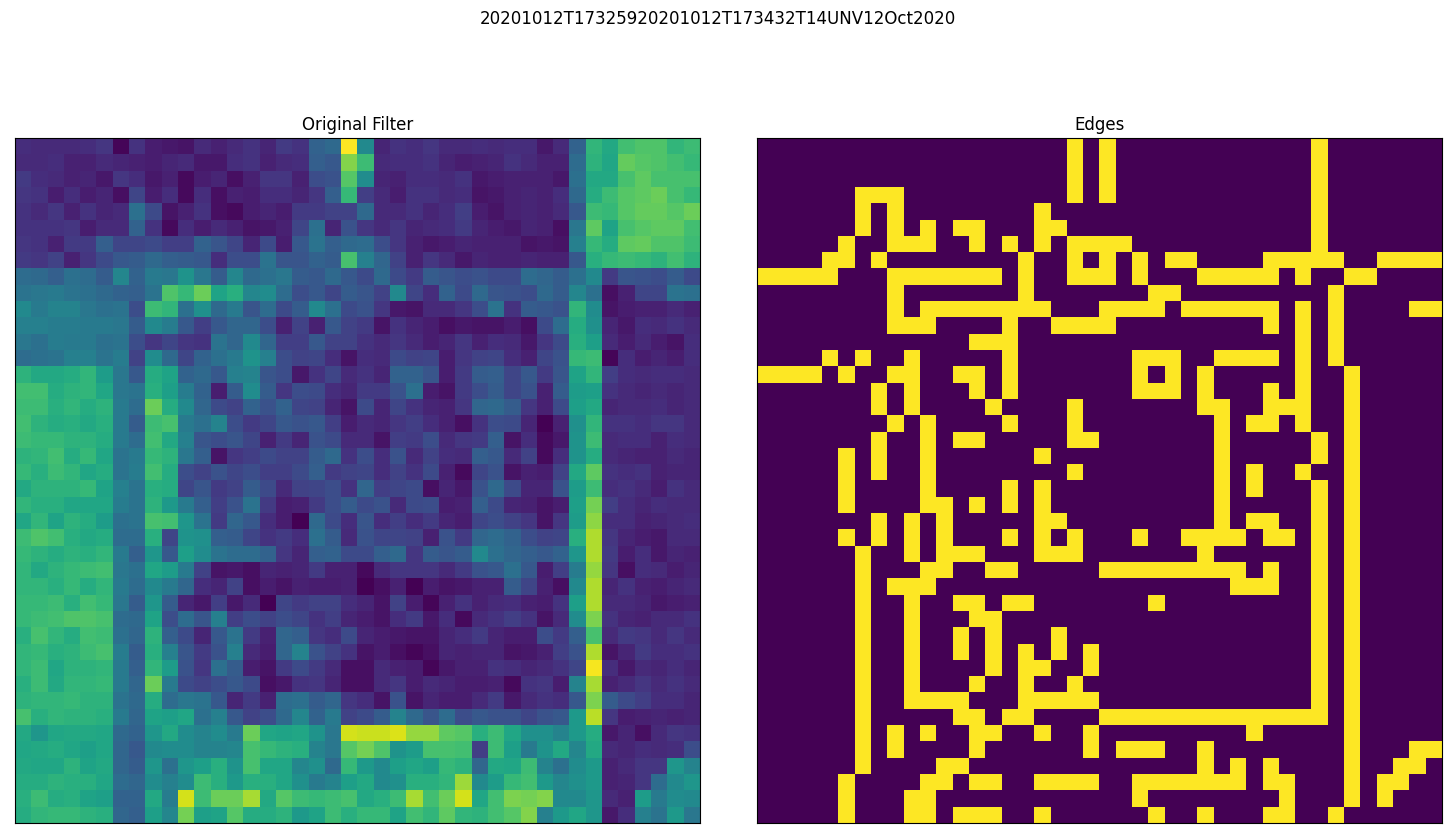

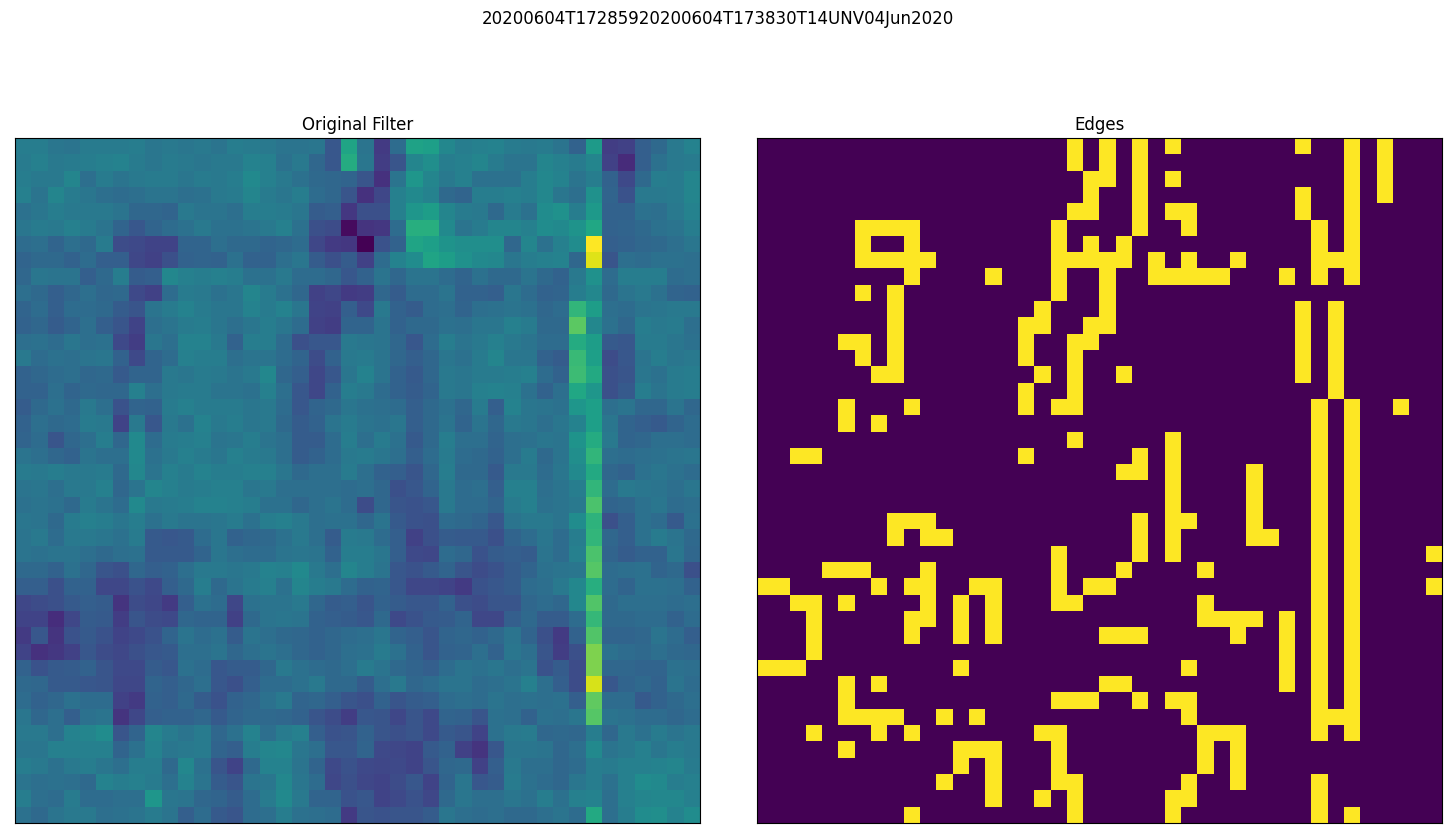

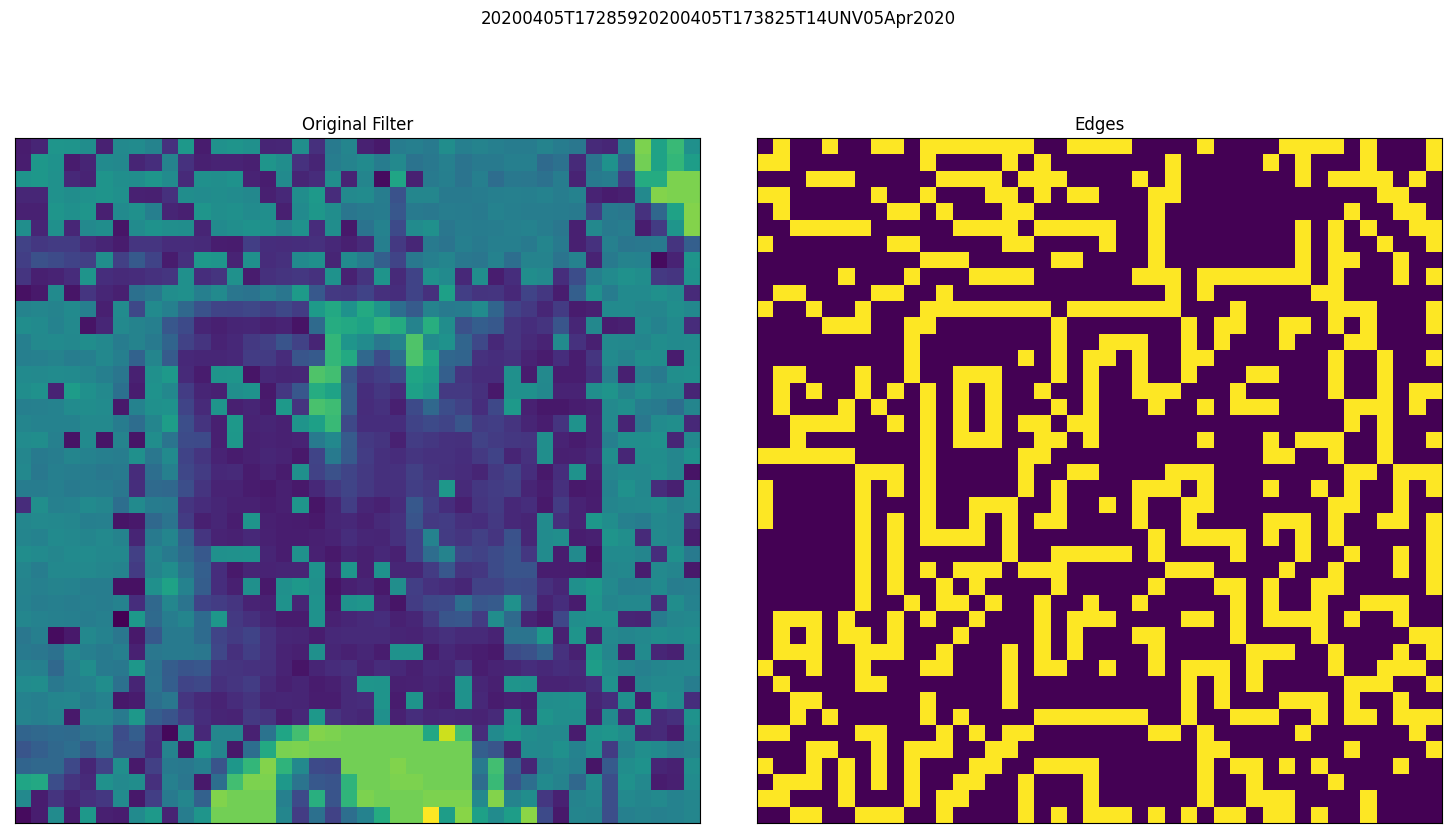

In [120]:
for key in img_keys:
    img = images[key]
    image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny = edge_detection_preprocessing(img, 50, 50)
    visualize_filter_edges(grayscale_gaussian_filter, grayscale_gaussian_canny, key)

In [121]:
im = convert_to_eight_bits(images[img_keys[0]])
#o = draw_grid(im)
#plt.imshow(o)

In [122]:
im[0]

array([[ 74,  38,  32],
       [ 75,  42,  26],
       [ 86,  46,  36],
       [ 81,  45,  32],
       [ 75,  41,  30],
       [ 73,  41,  32],
       [ 78,  42,  31],
       [ 71,  37,  30],
       [ 71,  36,  26],
       [ 70,  35,  28],
       [ 62,  30,  21],
       [ 64,  35,  25],
       [ 65,  36,  24],
       [ 86,  50,  35],
       [ 82,  42,  33],
       [ 74,  41,  31],
       [ 74,  39,  29],
       [ 74,  41,  29],
       [ 83,  49,  34],
       [118,  91,  64],
       [169, 127,  92],
       [174, 135, 100],
       [167, 135, 111],
       [186, 151, 122],
       [160, 120,  97],
       [162, 120, 100],
       [177, 133, 107],
       [193, 145, 124],
       [164, 120, 100],
       [173, 132, 104],
       [168, 121,  98],
       [184, 141, 112],
       [201, 155, 125],
       [175, 128, 105],
       [169, 129,  91],
       [142, 103,  77],
       [106,  79,  72],
       [112,  85,  72],
       [109,  73,  62],
       [115,  80,  64],
       [148, 104,  82],
       [149, 106

In [123]:
im[1]

array([[ 76,  41,  31],
       [ 77,  41,  28],
       [ 88,  50,  37],
       [ 85,  48,  36],
       [ 81,  44,  32],
       [ 76,  40,  31],
       [ 76,  42,  29],
       [ 74,  36,  29],
       [ 67,  33,  26],
       [ 69,  35,  27],
       [ 64,  31,  20],
       [ 58,  25,  22],
       [ 61,  30,  20],
       [ 79,  44,  33],
       [ 96,  58,  43],
       [ 81,  47,  33],
       [ 73,  39,  31],
       [ 74,  42,  30],
       [ 49,  20,  14],
       [124,  88,  64],
       [ 90,  74,  37],
       [127, 100,  64],
       [159, 128, 106],
       [186, 147, 118],
       [175, 126, 104],
       [173, 129, 106],
       [181, 137, 112],
       [216, 167, 138],
       [212, 169, 139],
       [190, 144, 119],
       [160, 115,  94],
       [173, 123, 102],
       [192, 140, 117],
       [159, 118,  97],
       [155, 117,  86],
       [137,  98,  76],
       [104,  76,  64],
       [135, 104,  89],
       [105,  74,  60],
       [110,  72,  62],
       [144,  96,  77],
       [149, 100

In [124]:
im[2]

array([[ 81,  44,  32],
       [ 82,  46,  32],
       [ 86,  50,  36],
       [ 86,  48,  33],
       [ 81,  44,  35],
       [ 80,  43,  31],
       [ 71,  38,  28],
       [ 67,  35,  25],
       [ 63,  30,  22],
       [ 68,  34,  28],
       [ 60,  31,  23],
       [ 69,  33,  27],
       [ 61,  28,  22],
       [ 61,  31,  20],
       [ 96,  56,  42],
       [ 98,  59,  43],
       [ 79,  43,  35],
       [ 72,  40,  32],
       [ 45,  20,  14],
       [ 73,  42,  33],
       [137, 107,  74],
       [125,  99,  74],
       [136, 109,  92],
       [171, 138, 113],
       [149, 110,  87],
       [145, 105,  85],
       [169, 130, 104],
       [212, 161, 135],
       [195, 149, 126],
       [210, 165, 135],
       [208, 159, 135],
       [192, 143, 122],
       [199, 146, 122],
       [179, 133, 106],
       [163, 123,  90],
       [161, 119,  98],
       [142, 110,  96],
       [128,  94,  80],
       [110,  73,  61],
       [114,  77,  65],
       [122,  81,  63],
       [129,  86

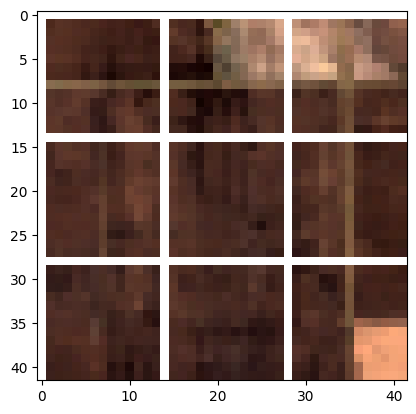

In [125]:
quadrants = split_image(im)

In [126]:
quadrants

{'0X_0Y_quadrant': array([[[ 74,  38,  32],
         [ 75,  42,  26],
         [ 86,  46,  36],
         [ 81,  45,  32],
         [ 75,  41,  30],
         [ 73,  41,  32],
         [ 78,  42,  31],
         [ 71,  37,  30],
         [ 71,  36,  26],
         [ 70,  35,  28],
         [ 62,  30,  21],
         [ 64,  35,  25],
         [ 65,  36,  24],
         [ 86,  50,  35]],
 
        [[ 76,  41,  31],
         [ 77,  41,  28],
         [ 88,  50,  37],
         [ 85,  48,  36],
         [ 81,  44,  32],
         [ 76,  40,  31],
         [ 76,  42,  29],
         [ 74,  36,  29],
         [ 67,  33,  26],
         [ 69,  35,  27],
         [ 64,  31,  20],
         [ 58,  25,  22],
         [ 61,  30,  20],
         [ 79,  44,  33]],
 
        [[ 81,  44,  32],
         [ 82,  46,  32],
         [ 86,  50,  36],
         [ 86,  48,  33],
         [ 81,  44,  35],
         [ 80,  43,  31],
         [ 71,  38,  28],
         [ 67,  35,  25],
         [ 63,  30,  22],
         [ 68,

In [127]:
for key in quadrants.keys():
    print(quadrants[key])

[[[ 74  38  32]
  [ 75  42  26]
  [ 86  46  36]
  [ 81  45  32]
  [ 75  41  30]
  [ 73  41  32]
  [ 78  42  31]
  [ 71  37  30]
  [ 71  36  26]
  [ 70  35  28]
  [ 62  30  21]
  [ 64  35  25]
  [ 65  36  24]
  [ 86  50  35]]

 [[ 76  41  31]
  [ 77  41  28]
  [ 88  50  37]
  [ 85  48  36]
  [ 81  44  32]
  [ 76  40  31]
  [ 76  42  29]
  [ 74  36  29]
  [ 67  33  26]
  [ 69  35  27]
  [ 64  31  20]
  [ 58  25  22]
  [ 61  30  20]
  [ 79  44  33]]

 [[ 81  44  32]
  [ 82  46  32]
  [ 86  50  36]
  [ 86  48  33]
  [ 81  44  35]
  [ 80  43  31]
  [ 71  38  28]
  [ 67  35  25]
  [ 63  30  22]
  [ 68  34  28]
  [ 60  31  23]
  [ 69  33  27]
  [ 61  28  22]
  [ 61  31  20]]

 [[ 84  48  32]
  [ 85  49  38]
  [ 87  47  34]
  [ 84  46  34]
  [ 79  44  30]
  [ 76  42  31]
  [ 68  37  28]
  [ 62  34  25]
  [ 64  33  24]
  [ 66  34  26]
  [ 60  30  23]
  [ 67  35  28]
  [ 53  26  17]
  [ 54  22  18]]

 [[ 88  50  37]
  [ 87  47  37]
  [ 84  47  36]
  [ 82  46  33]
  [ 77  43  32]
  [ 68  35  27]


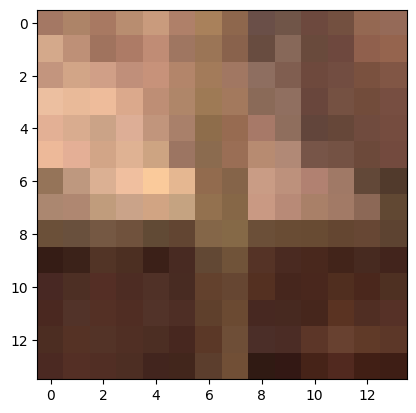

In [128]:
plt.imshow(quadrants[list(quadrants.keys())[2]])

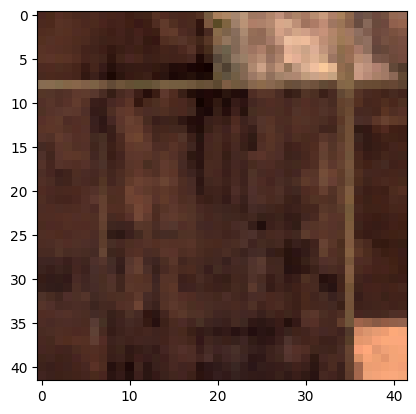

In [129]:
plt.imshow(im)

In [130]:
cv2.imread('/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/20200702T17391120200702T174635T14UNV02Jul2020')

[ WARN:0@76663.221] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/20200702T17391120200702T174635T14UNV02Jul2020'): can't open/read file: check file path/integrity


In [131]:
img_keys

['20200515T17285920200515T173444T14UNV15May2020',
 '20200714T17285920200714T172950T14UNV14Jul2020',
 '20200828T17290120200828T173729T14UNV28Aug2020',
 '20200722T17391120200722T174226T14UNV22Jul2020',
 '20200910T17391120200910T174620T14UNV10Sep2020',
 '20200403T17390120200403T174815T14UNV03Apr2020',
 '20200702T17391120200702T174635T14UNV02Jul2020',
 '20200510T17290120200510T173648T14UNV10May2020',
 '20210301T17313920210301T173533T14UNV01Mar2021',
 '20201015T17431920201015T174920T14UNV15Oct2020',
 '20200905T17390920200905T174333T14UNV05Sep2020',
 '20210319T17403120210319T174932T14UNV19Mar2021',
 '20200727T17390920200727T174220T14UNV27Jul2020',
 '20201129T17471120201129T174706T14UNV29Nov2020',
 '20200925T17400920200925T174809T14UNV25Sep2020',
 '20200607T17390920200607T174744T14UNV07Jun2020',
 '20200508T17385920200508T174740T14UNV08May2020',
 '20201010T17425120201010T174610T14UNV10Oct2020',
 '20201007T17321120201007T173833T14UNV07Oct2020',
 '20200530T17291120200530T173636T14UNV30May2020',


In [132]:
images[img_keys[0]]

{'B4': array([[ 755,  760,  820, ...,  977, 1160, 1167],
        [ 762,  768,  827, ...,  950, 1136, 1163],
        [ 789,  798,  821, ...,  972, 1017, 1053],
        ...,
        [ 697,  708,  687, ..., 1594, 1684, 1692],
        [ 683,  665,  690, ..., 1678, 1690, 1676],
        [ 703,  675,  679, ..., 1713, 1715, 1687]], dtype=int32),
 'B3': array([[ 555,  574,  601, ...,  786,  919,  929],
        [ 571,  572,  622, ...,  741,  872,  896],
        [ 588,  597,  620, ...,  769,  791,  818],
        ...,
        [ 550,  547,  535, ..., 1167, 1248, 1240],
        [ 530,  516,  524, ..., 1231, 1244, 1222],
        [ 543,  528,  526, ..., 1264, 1268, 1258]], dtype=int32),
 'B2': array([[ 519,  489,  545, ...,  698,  794,  830],
        [ 515,  499,  550, ...,  688,  770,  776],
        [ 521,  520,  542, ...,  704,  690,  723],
        ...,
        [ 494,  516,  477, ...,  938, 1001,  987],
        [ 495,  493,  488, ...,  980,  998,  995],
        [ 519,  497,  478, ..., 1015, 1030, 10

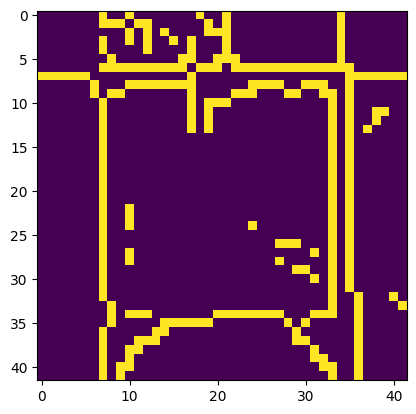

In [161]:
plt.imshow(cv2.Canny(convert_to_eight_bits(images[img_keys[4]]), 100, 100, L2gradient=True))